### Repeated Prisioner's Dilemma

- There are two agents that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or cooperate (C/1).
- Defect is dominant strategy, and (D,D) is Nash Eqbm of stage game. 
- Sustained Cooperation is best for everyone in repeated game. 
- Rewards for agents are 

    - (1,1) for (D,D) 
    - (3,0) for (D,C) 
    - (0,3) for (C,D) 
    - (2.5,2.5) for (C,C)

- There is just one state that does change
- There is "discounting". Agents value future profits - they do not seek to maximize discounted sum. 

### Import Packages

In [11]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(precision=2)
import random
from collections import namedtuple, deque
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [3]:
Transition = namedtuple('Transition',('state','next_state','action','reward'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [396]:
class DQN(nn.Module):
    # Takes in a vector of states and gives out valuations for each action
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.normalize(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [397]:
def getProbs(agent, BETA):
    return torch.exp(agent.policy_net(agent.state)/BETA)/torch.sum(torch.exp(agent.policy_net(agent.state)/BETA))

In [398]:
class Agent:
    def __init__(self, N_STATES, N_ACTIONS, N_MEMORY=10000, BATCH_SIZE=512, GAMMA=0, TAU = 0.0001, LR = 1e-5,
                 EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 1000, 
                 BETA_START = 0.1, BETA_END = 0.01, BETA_DECAY = 1000):
        self.N_STATES = N_STATES
        self.N_ACTIONS = N_ACTIONS
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.STEPS = 0
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.EPS_THRESHOLD = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*self.STEPS/EPS_DECAY)
        self.BETA_START = BETA_START
        self.BETA_END = BETA_END
        self.BETA_DECAY = BETA_DECAY
        self.BETA_THRESHOLD = BETA_END + (BETA_START-BETA_END)*math.exp(-1.*self.STEPS/BETA_DECAY)
        self.LR = LR
        self.TAU = TAU
        self.policy_net = DQN(N_STATES,N_ACTIONS)
        self.target_net = DQN(N_STATES,N_ACTIONS)
        self.state = torch.zeros(1,N_STATES)
        self.actions = torch.tensor(np.arange(N_ACTIONS))
        self.memory = ReplayMemory(N_MEMORY)
        self.optimizer = optim.AdamW(self.policy_net.parameters(),lr=LR,amsgrad=True)
        self.action_history = []
        self.loss = torch.tensor(1000)

In [399]:
def select_action(agent):
    # Given state selects action either from the DQN (Q values become probs) or randomly. 
    sample = random.random()
    agent.EPS_THRESHOLD = agent.EPS_END + (agent.EPS_START-agent.EPS_END)*math.exp(-1.*agent.STEPS/agent.EPS_DECAY)
    if np.max(getProbs(agent, agent.BETA_THRESHOLD).tolist())<0.95:
        agent.BETA_THRESHOLD = agent.BETA_END + (agent.BETA_START-agent.BETA_END)*math.exp(-1.*agent.STEPS/agent.BETA_DECAY)
    agent.STEPS += 1

    if sample>agent.EPS_THRESHOLD:
        with torch.no_grad():
            #probs = getProbs(agent, agent.BETA_THRESHOLD)     
            #try: 
            #    index = probs.multinomial(num_samples=1, replacement=True)
            #    choice = agent.actions[index]
            #    return torch.tensor([[choice]],dtype=torch.long)
            #except:
            try: 
                return agent.policy_net(agent.state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return agent.policy_net(agent.state).max(0)[1].view(1,1) # pick up action with largest expected reward

    else:
        randchoice = random.choice(np.arange(agent.N_ACTIONS))
        return torch.tensor([[randchoice]],dtype=torch.long)

In [400]:
def update_target_net(agent):
    target_net_state_dict = agent.target_net.state_dict()
    policy_net_state_dict = agent.policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*agent.TAU+target_net_state_dict[key]*(1-agent.TAU)
    agent.target_net.load_state_dict(target_net_state_dict)

In [401]:
def optimize_model(agent):
    if len(agent.memory)<agent.BATCH_SIZE:
        return
    
    # Load data
    transitions = agent.memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_batch = torch.cat(batch.state)
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = agent.policy_net(state_batch).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(agent.BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = agent.target_net(non_final_next_states).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*agent.GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    agent.loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    agent.optimizer.zero_grad()
    agent.loss.backward()
    torch.nn.utils.clip_grad_value_(agent.policy_net.parameters(),100)
    agent.optimizer.step()   

In [402]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx] 

In [403]:
def track(agent, test, action):
    with torch.no_grad():
        test = torch.tensor([[test]], dtype = torch.float32)
        q = agent1.policy_net(test)
        print(f'Action:{int(action.item()):0.2f}, Loss:{agent.loss.item():0.2f},BETA:{agent.BETA_THRESHOLD:0.2f},EPS:{agent.EPS_THRESHOLD:0.2f},P:{getProbs(agent,agent.BETA_THRESHOLD)},Q:{q}')
        

In [404]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


### Game

In [428]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (1,1)
    if (a1 == 0 and a2 == 1): # DC
        return (91,0)
    if (a1 == 1 and a2 == 0): # CD
        return (0,91)
    if (a1 == 1 and a2 == 1): # CC
        return (90,90) 
    


(1-0)/(90-0)

0.011111111111111112

### HyperParameters and Initializations

In [430]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0.9 # Discount factor
EPS_START = 0.99 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.0001 # update rate of target network
LR = 0.1 # Learning rate of Adam
BETA_START = 10 # temperature of the greedy-exploratory policy
BETA_END = 0.1 # End value of temperature
BETA_DECAY = 2000 # controls decay rate of temperature
N_MEMORY = 1000
N_STATES = 1
N_ACTIONS = 2

agent1 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA, TAU, LR,
                    EPS_START, EPS_END, EPS_DECAY,
                    BETA_START, BETA_END, BETA_DECAY)
agent2 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA, TAU, LR,
                    EPS_START, EPS_END, EPS_DECAY,
                    BETA_START, BETA_END, BETA_DECAY)

In [431]:
epochs = 10000
for t in range(epochs):
    print('\n Iteration:',t)

    # Take action
    a1 = select_action(agent1)
    a2 = select_action(agent2)

    #q2 = torch.tensor(np.maximum(q1,0), dtype = torch.float32)
    #q2 = torch.tensor(q2c, dtype = torch.float32)
    #a2 = torch.tensor(np.where(Qgrid==find_nearest(Qgrid,q2.item()))[0])

    # Obtain Reward
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])
    
    # Compute next state
    next_state1 = agent1.state 
    next_state1[0] = a2.item()
    #next_state1[0][1] = a2.item()
    next_state2 = agent2.state 
    next_state2[0] = a1.item()  
    #next_state2[0][1] = a1.item()  
   
    # store memory in transition
    agent1.memory.push(agent1.state, next_state1, a1, r1)
    agent2.memory.push(agent2.state, next_state2, a2, r2)

    # move to next state
    agent1.state = next_state1
    agent2.state = next_state2
    
    # optimize
    optimize_model(agent1)
    optimize_model(agent2)

    # soft update target_net
    update_target_net(agent1)
    update_target_net(agent2)
    
    # record actions
    agent1.action_history.append(a1.item())
    agent2.action_history.append(a2.item())
    
    # print loss
    track(agent1, [0], a1)
    track(agent2, [0], a2)


 Iteration: 0
Action:0.00, Loss:1000.00,BETA:10.00,EPS:0.99,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:0.00, Loss:1000.00,BETA:10.00,EPS:0.99,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 1
Action:1.00, Loss:1000.00,BETA:10.00,EPS:0.99,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:0.00, Loss:1000.00,BETA:10.00,EPS:0.99,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 2
Action:1.00, Loss:1000.00,BETA:9.99,EPS:0.99,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:1.00, Loss:1000.00,BETA:9.99,EPS:0.99,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 3
Action:1.00, Loss:1000.00,BETA:9.99,EPS:0.99,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:0.00, Loss:1000.00,BETA:9.99,EPS:0.99,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 4
Action:0.00, Loss:1000.00,BETA:9.98,EPS:0.99,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:0.00, Loss:1000.00,BETA:9.98,EPS:0.99,P:t

Action:1.00, Loss:1000.00,BETA:9.77,EPS:0.95,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:0.00, Loss:1000.00,BETA:9.77,EPS:0.95,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 47
Action:1.00, Loss:1000.00,BETA:9.77,EPS:0.95,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:1.00, Loss:1000.00,BETA:9.77,EPS:0.95,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 48
Action:1.00, Loss:1000.00,BETA:9.77,EPS:0.95,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:1.00, Loss:1000.00,BETA:9.77,EPS:0.95,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 49
Action:1.00, Loss:1000.00,BETA:9.76,EPS:0.95,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:1.00, Loss:1000.00,BETA:9.76,EPS:0.95,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 50
Action:0.00, Loss:1000.00,BETA:9.76,EPS:0.94,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:0.00, Loss:1000.00,BETA:9.76,EPS:0.94,P:tensor([[0.50, 0

Action:1.00, Loss:1000.00,BETA:9.55,EPS:0.91,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 94
Action:1.00, Loss:1000.00,BETA:9.55,EPS:0.91,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:0.00, Loss:1000.00,BETA:9.55,EPS:0.91,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 95
Action:0.00, Loss:1000.00,BETA:9.54,EPS:0.90,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:1.00, Loss:1000.00,BETA:9.54,EPS:0.90,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 96
Action:0.00, Loss:1000.00,BETA:9.54,EPS:0.90,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:1.00, Loss:1000.00,BETA:9.54,EPS:0.90,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 97
Action:1.00, Loss:1000.00,BETA:9.53,EPS:0.90,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])
Action:1.00, Loss:1000.00,BETA:9.53,EPS:0.90,P:tensor([[0.50, 0.50]]),Q:tensor([[[0.05, 0.05]]])

 Iteration: 98
Action:1.00, Loss:1000.00,BETA:9.53,EPS:0.90,P:

Action:1.00, Loss:43.34,BETA:9.27,EPS:0.86,P:tensor([[0., nan]]),Q:tensor([[[805.38, 859.71]]])
Action:0.00, Loss:74.85,BETA:9.34,EPS:0.86,P:tensor([[nan, nan]]),Q:tensor([[[805.38, 859.71]]])

 Iteration: 154
Action:1.00, Loss:46.46,BETA:9.27,EPS:0.86,P:tensor([[0., nan]]),Q:tensor([[[777.22, 853.20]]])
Action:0.00, Loss:55.44,BETA:9.34,EPS:0.86,P:tensor([[nan, nan]]),Q:tensor([[[777.22, 853.20]]])

 Iteration: 155
Action:1.00, Loss:44.15,BETA:9.27,EPS:0.86,P:tensor([[6.88e-05, 1.00e+00]]),Q:tensor([[[762.39, 860.40]]])
Action:1.00, Loss:38.28,BETA:9.34,EPS:0.86,P:tensor([[nan, nan]]),Q:tensor([[[762.39, 860.40]]])

 Iteration: 156
Action:1.00, Loss:49.44,BETA:9.27,EPS:0.85,P:tensor([[0., nan]]),Q:tensor([[[822.49, 894.03]]])
Action:1.00, Loss:52.17,BETA:9.34,EPS:0.85,P:tensor([[nan, nan]]),Q:tensor([[[822.49, 894.03]]])

 Iteration: 157
Action:1.00, Loss:44.82,BETA:9.27,EPS:0.85,P:tensor([[0.95, 0.05]]),Q:tensor([[[846.27, 817.65]]])
Action:1.00, Loss:69.91,BETA:9.34,EPS:0.85,P:tenso

Action:0.00, Loss:45.18,BETA:9.13,EPS:0.81,P:tensor([[0.97, 0.03]]),Q:tensor([[[759.09, 728.35]]])
Action:0.00, Loss:45.29,BETA:9.04,EPS:0.81,P:tensor([[0., nan]]),Q:tensor([[[759.09, 728.35]]])

 Iteration: 208
Action:0.00, Loss:45.03,BETA:9.13,EPS:0.81,P:tensor([[nan, nan]]),Q:tensor([[[707.52, 744.02]]])
Action:1.00, Loss:49.60,BETA:9.04,EPS:0.81,P:tensor([[0., nan]]),Q:tensor([[[707.52, 744.02]]])

 Iteration: 209
Action:0.00, Loss:44.20,BETA:9.13,EPS:0.81,P:tensor([[1.85e-05, 1.00e+00]]),Q:tensor([[[655.55, 755.05]]])
Action:0.00, Loss:43.59,BETA:9.04,EPS:0.81,P:tensor([[nan, nan]]),Q:tensor([[[655.55, 755.05]]])

 Iteration: 210
Action:1.00, Loss:55.75,BETA:9.13,EPS:0.81,P:tensor([[0., nan]]),Q:tensor([[[639.26, 722.64]]])
Action:1.00, Loss:44.72,BETA:9.04,EPS:0.81,P:tensor([[nan, nan]]),Q:tensor([[[639.26, 722.64]]])

 Iteration: 211
Action:1.00, Loss:48.71,BETA:9.13,EPS:0.81,P:tensor([[0.01, 0.99]]),Q:tensor([[[678.38, 723.86]]])
Action:0.00, Loss:40.52,BETA:9.04,EPS:0.81,P:ten

Action:1.00, Loss:43.69,BETA:8.81,EPS:0.78,P:tensor([[0.23, 0.77]]),Q:tensor([[[748.20, 742.38]]])

 Iteration: 257
Action:1.00, Loss:43.30,BETA:8.81,EPS:0.78,P:tensor([[0.40, 0.60]]),Q:tensor([[[753.25, 756.85]]])
Action:0.00, Loss:44.29,BETA:8.81,EPS:0.78,P:tensor([[0.14, 0.86]]),Q:tensor([[[753.25, 756.85]]])

 Iteration: 258
Action:1.00, Loss:41.98,BETA:8.80,EPS:0.78,P:tensor([[0., nan]]),Q:tensor([[[761.93, 777.99]]])
Action:1.00, Loss:44.79,BETA:8.80,EPS:0.78,P:tensor([[0.08, 0.92]]),Q:tensor([[[761.93, 777.99]]])

 Iteration: 259
Action:0.00, Loss:45.09,BETA:8.80,EPS:0.78,P:tensor([[0., nan]]),Q:tensor([[[765.56, 795.32]]])
Action:1.00, Loss:42.82,BETA:8.80,EPS:0.78,P:tensor([[nan, nan]]),Q:tensor([[[765.56, 795.32]]])

 Iteration: 260
Action:0.00, Loss:43.50,BETA:8.80,EPS:0.77,P:tensor([[nan, nan]]),Q:tensor([[[777.67, 816.42]]])
Action:1.00, Loss:39.83,BETA:8.80,EPS:0.77,P:tensor([[nan, nan]]),Q:tensor([[[777.67, 816.42]]])

 Iteration: 261
Action:0.00, Loss:44.53,BETA:8.80,EP

Action:1.00, Loss:42.77,BETA:8.65,EPS:0.75,P:tensor([[nan, nan]]),Q:tensor([[[684.27, 645.67]]])

 Iteration: 299
Action:1.00, Loss:45.52,BETA:8.69,EPS:0.75,P:tensor([[0.97, 0.03]]),Q:tensor([[[700.33, 667.36]]])
Action:1.00, Loss:46.87,BETA:8.65,EPS:0.75,P:tensor([[0., nan]]),Q:tensor([[[700.33, 667.36]]])

 Iteration: 300
Action:1.00, Loss:43.69,BETA:8.69,EPS:0.75,P:tensor([[0.96, 0.04]]),Q:tensor([[[729.56, 701.81]]])
Action:0.00, Loss:39.95,BETA:8.65,EPS:0.75,P:tensor([[0., nan]]),Q:tensor([[[729.56, 701.81]]])

 Iteration: 301
Action:0.00, Loss:40.84,BETA:8.69,EPS:0.75,P:tensor([[0.96, 0.04]]),Q:tensor([[[777.46, 749.88]]])
Action:1.00, Loss:41.67,BETA:8.65,EPS:0.75,P:tensor([[nan, nan]]),Q:tensor([[[777.46, 749.88]]])

 Iteration: 302
Action:1.00, Loss:46.42,BETA:8.69,EPS:0.74,P:tensor([[nan, nan]]),Q:tensor([[[810.28, 792.71]]])
Action:0.00, Loss:43.68,BETA:8.65,EPS:0.74,P:tensor([[0., nan]]),Q:tensor([[[810.28, 792.71]]])

 Iteration: 303
Action:1.00, Loss:35.72,BETA:8.69,EPS:0

Action:0.00, Loss:56.85,BETA:8.55,EPS:0.72,P:tensor([[0., nan]]),Q:tensor([[[717.15, 855.14]]])
Action:0.00, Loss:46.32,BETA:8.49,EPS:0.72,P:tensor([[nan, nan]]),Q:tensor([[[717.15, 855.14]]])

 Iteration: 345
Action:1.00, Loss:63.97,BETA:8.55,EPS:0.72,P:tensor([[0., nan]]),Q:tensor([[[769.50, 915.83]]])
Action:1.00, Loss:45.38,BETA:8.49,EPS:0.72,P:tensor([[0.70, 0.30]]),Q:tensor([[[769.50, 915.83]]])

 Iteration: 346
Action:1.00, Loss:69.02,BETA:8.55,EPS:0.72,P:tensor([[nan, nan]]),Q:tensor([[[837.94, 929.78]]])
Action:0.00, Loss:43.84,BETA:8.43,EPS:0.72,P:tensor([[0.42, 0.58]]),Q:tensor([[[837.94, 929.78]]])

 Iteration: 347
Action:0.00, Loss:46.23,BETA:8.55,EPS:0.71,P:tensor([[nan, nan]]),Q:tensor([[[863.80, 869.34]]])
Action:0.00, Loss:44.90,BETA:8.42,EPS:0.71,P:tensor([[0.19, 0.81]]),Q:tensor([[[863.80, 869.34]]])

 Iteration: 348
Action:1.00, Loss:46.00,BETA:8.55,EPS:0.71,P:tensor([[nan, nan]]),Q:tensor([[[874.35, 814.81]]])
Action:1.00, Loss:46.81,BETA:8.42,EPS:0.71,P:tensor([[0

Action:0.00, Loss:38.03,BETA:8.55,EPS:0.69,P:tensor([[nan, nan]]),Q:tensor([[[852.25, 887.80]]])
Action:0.00, Loss:40.81,BETA:8.29,EPS:0.69,P:tensor([[nan, nan]]),Q:tensor([[[852.25, 887.80]]])

 Iteration: 393
Action:0.00, Loss:39.59,BETA:8.55,EPS:0.68,P:tensor([[nan, nan]]),Q:tensor([[[845.93, 899.64]]])
Action:0.00, Loss:43.05,BETA:8.29,EPS:0.68,P:tensor([[nan, nan]]),Q:tensor([[[845.93, 899.64]]])

 Iteration: 394
Action:1.00, Loss:43.51,BETA:8.55,EPS:0.68,P:tensor([[nan, nan]]),Q:tensor([[[825.66, 894.42]]])
Action:1.00, Loss:42.87,BETA:8.29,EPS:0.68,P:tensor([[nan, nan]]),Q:tensor([[[825.66, 894.42]]])

 Iteration: 395
Action:0.00, Loss:44.50,BETA:8.55,EPS:0.68,P:tensor([[nan, nan]]),Q:tensor([[[805.68, 886.79]]])
Action:0.00, Loss:46.65,BETA:8.29,EPS:0.68,P:tensor([[nan, nan]]),Q:tensor([[[805.68, 886.79]]])

 Iteration: 396
Action:1.00, Loss:46.01,BETA:8.55,EPS:0.68,P:tensor([[nan, nan]]),Q:tensor([[[809.01, 900.75]]])
Action:0.00, Loss:43.40,BETA:8.29,EPS:0.68,P:tensor([[nan, 

Action:0.00, Loss:43.42,BETA:8.55,EPS:0.66,P:tensor([[nan, nan]]),Q:tensor([[[895.43, 846.28]]])
Action:1.00, Loss:41.56,BETA:8.13,EPS:0.66,P:tensor([[2.81e-04, 1.00e+00]]),Q:tensor([[[895.43, 846.28]]])

 Iteration: 436
Action:0.00, Loss:44.58,BETA:8.55,EPS:0.66,P:tensor([[nan, nan]]),Q:tensor([[[879.56, 864.62]]])
Action:1.00, Loss:42.88,BETA:8.13,EPS:0.66,P:tensor([[9.27e-05, 1.00e+00]]),Q:tensor([[[879.56, 864.62]]])

 Iteration: 437
Action:1.00, Loss:45.07,BETA:8.55,EPS:0.66,P:tensor([[nan, nan]]),Q:tensor([[[858.32, 890.96]]])
Action:0.00, Loss:47.62,BETA:8.13,EPS:0.66,P:tensor([[3.10e-04, 1.00e+00]]),Q:tensor([[[858.32, 890.96]]])

 Iteration: 438
Action:1.00, Loss:45.58,BETA:8.55,EPS:0.66,P:tensor([[nan, nan]]),Q:tensor([[[816.03, 842.49]]])
Action:1.00, Loss:43.47,BETA:8.13,EPS:0.66,P:tensor([[2.70e-04, 1.00e+00]]),Q:tensor([[[816.03, 842.49]]])

 Iteration: 439
Action:0.00, Loss:39.70,BETA:8.55,EPS:0.66,P:tensor([[nan, nan]]),Q:tensor([[[798.53, 818.89]]])
Action:0.00, Loss:4

Action:0.00, Loss:42.20,BETA:7.97,EPS:0.63,P:tensor([[nan, nan]]),Q:tensor([[[881.03, 896.98]]])
Action:0.00, Loss:47.92,BETA:7.97,EPS:0.63,P:tensor([[nan, nan]]),Q:tensor([[[881.03, 896.98]]])

 Iteration: 482
Action:1.00, Loss:44.10,BETA:7.97,EPS:0.63,P:tensor([[nan, nan]]),Q:tensor([[[859.56, 892.19]]])
Action:1.00, Loss:43.62,BETA:7.97,EPS:0.63,P:tensor([[nan, nan]]),Q:tensor([[[859.56, 892.19]]])

 Iteration: 483
Action:1.00, Loss:40.78,BETA:7.97,EPS:0.63,P:tensor([[nan, nan]]),Q:tensor([[[846.73, 896.61]]])
Action:1.00, Loss:50.95,BETA:7.97,EPS:0.63,P:tensor([[nan, nan]]),Q:tensor([[[846.73, 896.61]]])

 Iteration: 484
Action:0.00, Loss:43.73,BETA:7.97,EPS:0.63,P:tensor([[nan, nan]]),Q:tensor([[[839.26, 903.73]]])
Action:1.00, Loss:47.44,BETA:7.97,EPS:0.63,P:tensor([[nan, nan]]),Q:tensor([[[839.26, 903.73]]])

 Iteration: 485
Action:0.00, Loss:43.61,BETA:7.97,EPS:0.63,P:tensor([[nan, nan]]),Q:tensor([[[813.07, 876.93]]])
Action:1.00, Loss:44.32,BETA:7.97,EPS:0.63,P:tensor([[nan, 

Action:0.00, Loss:45.28,BETA:7.97,EPS:0.61,P:tensor([[nan, nan]]),Q:tensor([[[787.50, 726.61]]])
Action:1.00, Loss:56.47,BETA:7.97,EPS:0.61,P:tensor([[nan, nan]]),Q:tensor([[[787.50, 726.61]]])

 Iteration: 521
Action:0.00, Loss:45.03,BETA:7.97,EPS:0.61,P:tensor([[nan, nan]]),Q:tensor([[[799.43, 760.37]]])
Action:0.00, Loss:43.60,BETA:7.97,EPS:0.61,P:tensor([[nan, nan]]),Q:tensor([[[799.43, 760.37]]])

 Iteration: 522
Action:0.00, Loss:43.50,BETA:7.97,EPS:0.61,P:tensor([[nan, nan]]),Q:tensor([[[814.61, 795.98]]])
Action:0.00, Loss:39.02,BETA:7.97,EPS:0.61,P:tensor([[nan, nan]]),Q:tensor([[[814.61, 795.98]]])

 Iteration: 523
Action:0.00, Loss:43.73,BETA:7.97,EPS:0.61,P:tensor([[nan, nan]]),Q:tensor([[[830.72, 833.16]]])
Action:0.00, Loss:70.73,BETA:7.97,EPS:0.61,P:tensor([[nan, nan]]),Q:tensor([[[830.72, 833.16]]])

 Iteration: 524
Action:1.00, Loss:38.93,BETA:7.97,EPS:0.61,P:tensor([[nan, nan]]),Q:tensor([[[857.56, 878.01]]])
Action:0.00, Loss:78.29,BETA:7.97,EPS:0.61,P:tensor([[nan, 

Action:0.00, Loss:44.24,BETA:7.54,EPS:0.58,P:tensor([[0.12, 0.88]]),Q:tensor([[[595.08, 610.08]]])
Action:0.00, Loss:45.23,BETA:7.54,EPS:0.58,P:tensor([[0.92, 0.08]]),Q:tensor([[[595.08, 610.08]]])

 Iteration: 572
Action:1.00, Loss:44.10,BETA:7.54,EPS:0.58,P:tensor([[0.01, 0.99]]),Q:tensor([[[581.88, 623.64]]])
Action:1.00, Loss:45.01,BETA:7.54,EPS:0.58,P:tensor([[0.89, 0.11]]),Q:tensor([[[581.88, 623.64]]])

 Iteration: 573
Action:1.00, Loss:43.08,BETA:7.54,EPS:0.58,P:tensor([[3.23e-05, 1.00e+00]]),Q:tensor([[[562.49, 640.42]]])
Action:0.00, Loss:45.07,BETA:7.53,EPS:0.58,P:tensor([[0.79, 0.21]]),Q:tensor([[[562.49, 640.42]]])

 Iteration: 574
Action:1.00, Loss:46.18,BETA:7.54,EPS:0.58,P:tensor([[0., nan]]),Q:tensor([[[588.22, 667.94]]])
Action:1.00, Loss:43.89,BETA:7.53,EPS:0.58,P:tensor([[0.68, 0.32]]),Q:tensor([[[588.22, 667.94]]])

 Iteration: 575
Action:1.00, Loss:44.41,BETA:7.54,EPS:0.58,P:tensor([[0., nan]]),Q:tensor([[[649.34, 715.70]]])
Action:0.00, Loss:47.11,BETA:7.53,EPS:0

Action:1.00, Loss:44.55,BETA:7.54,EPS:0.56,P:tensor([[nan, nan]]),Q:tensor([[[808.34, 860.52]]])
Action:0.00, Loss:43.58,BETA:7.52,EPS:0.56,P:tensor([[0.93, 0.07]]),Q:tensor([[[808.34, 860.52]]])

 Iteration: 615
Action:1.00, Loss:40.74,BETA:7.54,EPS:0.56,P:tensor([[nan, nan]]),Q:tensor([[[824.59, 854.25]]])
Action:0.00, Loss:45.23,BETA:7.38,EPS:0.56,P:tensor([[0.76, 0.24]]),Q:tensor([[[824.59, 854.25]]])

 Iteration: 616
Action:0.00, Loss:43.47,BETA:7.54,EPS:0.56,P:tensor([[nan, nan]]),Q:tensor([[[807.77, 801.46]]])
Action:1.00, Loss:44.41,BETA:7.38,EPS:0.56,P:tensor([[0.45, 0.55]]),Q:tensor([[[807.77, 801.46]]])

 Iteration: 617
Action:0.00, Loss:48.08,BETA:7.54,EPS:0.56,P:tensor([[nan, nan]]),Q:tensor([[[784.12, 751.08]]])
Action:1.00, Loss:45.81,BETA:7.37,EPS:0.56,P:tensor([[0.15, 0.85]]),Q:tensor([[[784.12, 751.08]]])

 Iteration: 618
Action:0.00, Loss:43.07,BETA:7.54,EPS:0.56,P:tensor([[nan, nan]]),Q:tensor([[[773.25, 719.32]]])
Action:0.00, Loss:42.98,BETA:7.37,EPS:0.56,P:tensor

Action:1.00, Loss:46.18,BETA:7.54,EPS:0.54,P:tensor([[nan, nan]]),Q:tensor([[[1019.49,  997.86]]])
Action:1.00, Loss:44.46,BETA:7.37,EPS:0.54,P:tensor([[nan, nan]]),Q:tensor([[[1019.49,  997.86]]])

 Iteration: 660
Action:0.00, Loss:53.48,BETA:7.54,EPS:0.54,P:tensor([[nan, nan]]),Q:tensor([[[971.74, 949.40]]])
Action:0.00, Loss:48.25,BETA:7.37,EPS:0.54,P:tensor([[nan, nan]]),Q:tensor([[[971.74, 949.40]]])

 Iteration: 661
Action:0.00, Loss:41.97,BETA:7.54,EPS:0.54,P:tensor([[nan, nan]]),Q:tensor([[[880.09, 880.24]]])
Action:0.00, Loss:42.46,BETA:7.37,EPS:0.54,P:tensor([[nan, nan]]),Q:tensor([[[880.09, 880.24]]])

 Iteration: 662
Action:1.00, Loss:44.88,BETA:7.54,EPS:0.53,P:tensor([[nan, nan]]),Q:tensor([[[802.53, 819.55]]])
Action:1.00, Loss:43.97,BETA:7.37,EPS:0.53,P:tensor([[nan, nan]]),Q:tensor([[[802.53, 819.55]]])

 Iteration: 663
Action:0.00, Loss:45.65,BETA:7.54,EPS:0.53,P:tensor([[nan, nan]]),Q:tensor([[[730.94, 763.05]]])
Action:0.00, Loss:40.94,BETA:7.37,EPS:0.53,P:tensor([[n

Action:0.00, Loss:46.97,BETA:7.08,EPS:0.51,P:tensor([[nan, nan]]),Q:tensor([[[829.89, 785.21]]])
Action:0.00, Loss:61.18,BETA:7.09,EPS:0.51,P:tensor([[nan, nan]]),Q:tensor([[[829.89, 785.21]]])

 Iteration: 713
Action:1.00, Loss:45.18,BETA:7.08,EPS:0.51,P:tensor([[nan, nan]]),Q:tensor([[[807.00, 754.38]]])
Action:0.00, Loss:46.52,BETA:7.09,EPS:0.51,P:tensor([[nan, nan]]),Q:tensor([[[807.00, 754.38]]])

 Iteration: 714
Action:0.00, Loss:48.06,BETA:7.08,EPS:0.51,P:tensor([[nan, nan]]),Q:tensor([[[785.81, 730.56]]])
Action:1.00, Loss:54.97,BETA:7.09,EPS:0.51,P:tensor([[nan, nan]]),Q:tensor([[[785.81, 730.56]]])

 Iteration: 715
Action:0.00, Loss:47.26,BETA:7.08,EPS:0.51,P:tensor([[nan, nan]]),Q:tensor([[[776.23, 721.45]]])
Action:0.00, Loss:48.19,BETA:7.09,EPS:0.51,P:tensor([[nan, nan]]),Q:tensor([[[776.23, 721.45]]])

 Iteration: 716
Action:1.00, Loss:42.69,BETA:7.08,EPS:0.51,P:tensor([[nan, nan]]),Q:tensor([[[771.09, 714.55]]])
Action:1.00, Loss:52.45,BETA:7.09,EPS:0.51,P:tensor([[nan, 

Action:1.00, Loss:46.56,BETA:7.08,EPS:0.49,P:tensor([[nan, nan]]),Q:tensor([[[757.21, 732.61]]])
Action:0.00, Loss:45.34,BETA:7.09,EPS:0.49,P:tensor([[nan, nan]]),Q:tensor([[[757.21, 732.61]]])

 Iteration: 769
Action:1.00, Loss:45.18,BETA:7.08,EPS:0.49,P:tensor([[nan, nan]]),Q:tensor([[[751.56, 733.81]]])
Action:1.00, Loss:46.10,BETA:7.09,EPS:0.49,P:tensor([[nan, nan]]),Q:tensor([[[751.56, 733.81]]])

 Iteration: 770
Action:0.00, Loss:43.53,BETA:7.08,EPS:0.49,P:tensor([[nan, nan]]),Q:tensor([[[750.05, 739.16]]])
Action:1.00, Loss:45.80,BETA:7.09,EPS:0.49,P:tensor([[nan, nan]]),Q:tensor([[[750.05, 739.16]]])

 Iteration: 771
Action:1.00, Loss:42.06,BETA:7.08,EPS:0.48,P:tensor([[nan, nan]]),Q:tensor([[[755.44, 751.80]]])
Action:1.00, Loss:45.53,BETA:7.09,EPS:0.48,P:tensor([[nan, nan]]),Q:tensor([[[755.44, 751.80]]])

 Iteration: 772
Action:1.00, Loss:42.73,BETA:7.08,EPS:0.48,P:tensor([[nan, nan]]),Q:tensor([[[763.22, 768.36]]])
Action:1.00, Loss:41.92,BETA:7.09,EPS:0.48,P:tensor([[nan, 

Action:0.00, Loss:43.25,BETA:7.08,EPS:0.46,P:tensor([[nan, nan]]),Q:tensor([[[864.52, 887.29]]])
Action:0.00, Loss:45.98,BETA:7.09,EPS:0.46,P:tensor([[nan, nan]]),Q:tensor([[[864.52, 887.29]]])

 Iteration: 825
Action:1.00, Loss:39.59,BETA:7.08,EPS:0.46,P:tensor([[nan, nan]]),Q:tensor([[[895.24, 898.01]]])
Action:1.00, Loss:48.05,BETA:7.09,EPS:0.46,P:tensor([[nan, nan]]),Q:tensor([[[895.24, 898.01]]])

 Iteration: 826
Action:1.00, Loss:41.69,BETA:7.08,EPS:0.46,P:tensor([[nan, nan]]),Q:tensor([[[928.86, 912.36]]])
Action:1.00, Loss:49.09,BETA:7.09,EPS:0.46,P:tensor([[nan, nan]]),Q:tensor([[[928.86, 912.36]]])

 Iteration: 827
Action:0.00, Loss:48.42,BETA:7.08,EPS:0.46,P:tensor([[nan, nan]]),Q:tensor([[[951.16, 919.98]]])
Action:1.00, Loss:46.38,BETA:7.09,EPS:0.46,P:tensor([[nan, nan]]),Q:tensor([[[951.16, 919.98]]])

 Iteration: 828
Action:0.00, Loss:39.35,BETA:7.08,EPS:0.46,P:tensor([[nan, nan]]),Q:tensor([[[983.98, 938.58]]])
Action:1.00, Loss:47.72,BETA:7.09,EPS:0.46,P:tensor([[nan, 

Action:1.00, Loss:40.49,BETA:6.51,EPS:0.44,P:tensor([[nan, nan]]),Q:tensor([[[657.92, 663.94]]])
Action:1.00, Loss:40.77,BETA:6.50,EPS:0.44,P:tensor([[0.00, 1.00]]),Q:tensor([[[657.92, 663.94]]])

 Iteration: 882
Action:1.00, Loss:40.62,BETA:6.51,EPS:0.44,P:tensor([[nan, nan]]),Q:tensor([[[662.24, 644.87]]])
Action:1.00, Loss:44.03,BETA:6.50,EPS:0.44,P:tensor([[0.00, 1.00]]),Q:tensor([[[662.24, 644.87]]])

 Iteration: 883
Action:1.00, Loss:44.49,BETA:6.51,EPS:0.44,P:tensor([[nan, nan]]),Q:tensor([[[665.62, 626.27]]])
Action:1.00, Loss:48.08,BETA:6.50,EPS:0.44,P:tensor([[0.00, 1.00]]),Q:tensor([[[665.62, 626.27]]])

 Iteration: 884
Action:0.00, Loss:44.76,BETA:6.51,EPS:0.44,P:tensor([[nan, nan]]),Q:tensor([[[667.44, 608.75]]])
Action:1.00, Loss:44.18,BETA:6.50,EPS:0.44,P:tensor([[0.01, 0.99]]),Q:tensor([[[667.44, 608.75]]])

 Iteration: 885
Action:0.00, Loss:47.23,BETA:6.51,EPS:0.44,P:tensor([[nan, nan]]),Q:tensor([[[671.10, 597.19]]])
Action:1.00, Loss:46.87,BETA:6.50,EPS:0.44,P:tensor

Action:0.00, Loss:43.90,BETA:6.51,EPS:0.42,P:tensor([[nan, nan]]),Q:tensor([[[878.32, 841.22]]])
Action:1.00, Loss:42.65,BETA:6.44,EPS:0.42,P:tensor([[0., nan]]),Q:tensor([[[878.32, 841.22]]])

 Iteration: 937
Action:0.00, Loss:42.47,BETA:6.51,EPS:0.42,P:tensor([[nan, nan]]),Q:tensor([[[895.37, 847.02]]])
Action:1.00, Loss:45.12,BETA:6.44,EPS:0.42,P:tensor([[nan, nan]]),Q:tensor([[[895.37, 847.02]]])

 Iteration: 938
Action:0.00, Loss:43.78,BETA:6.51,EPS:0.42,P:tensor([[nan, nan]]),Q:tensor([[[893.43, 847.14]]])
Action:0.00, Loss:43.93,BETA:6.44,EPS:0.42,P:tensor([[nan, nan]]),Q:tensor([[[893.43, 847.14]]])

 Iteration: 939
Action:0.00, Loss:43.56,BETA:6.51,EPS:0.42,P:tensor([[nan, nan]]),Q:tensor([[[894.65, 850.02]]])
Action:1.00, Loss:44.76,BETA:6.44,EPS:0.42,P:tensor([[nan, nan]]),Q:tensor([[[894.65, 850.02]]])

 Iteration: 940
Action:0.00, Loss:42.14,BETA:6.51,EPS:0.42,P:tensor([[nan, nan]]),Q:tensor([[[899.20, 853.18]]])
Action:1.00, Loss:42.09,BETA:6.44,EPS:0.42,P:tensor([[nan, n

Action:1.00, Loss:42.78,BETA:6.51,EPS:0.40,P:tensor([[nan, nan]]),Q:tensor([[[746.26, 747.04]]])
Action:0.00, Loss:43.15,BETA:6.44,EPS:0.40,P:tensor([[nan, nan]]),Q:tensor([[[746.26, 747.04]]])

 Iteration: 987
Action:1.00, Loss:41.49,BETA:6.51,EPS:0.40,P:tensor([[nan, nan]]),Q:tensor([[[766.77, 769.27]]])
Action:1.00, Loss:43.11,BETA:6.44,EPS:0.40,P:tensor([[nan, nan]]),Q:tensor([[[766.77, 769.27]]])

 Iteration: 988
Action:0.00, Loss:40.22,BETA:6.51,EPS:0.40,P:tensor([[nan, nan]]),Q:tensor([[[796.12, 795.21]]])
Action:0.00, Loss:43.53,BETA:6.44,EPS:0.40,P:tensor([[nan, nan]]),Q:tensor([[[796.12, 795.21]]])

 Iteration: 989
Action:0.00, Loss:44.76,BETA:6.51,EPS:0.40,P:tensor([[nan, nan]]),Q:tensor([[[788.85, 786.87]]])
Action:1.00, Loss:44.85,BETA:6.44,EPS:0.40,P:tensor([[nan, nan]]),Q:tensor([[[788.85, 786.87]]])

 Iteration: 990
Action:0.00, Loss:44.01,BETA:6.51,EPS:0.40,P:tensor([[nan, nan]]),Q:tensor([[[782.80, 780.33]]])
Action:0.00, Loss:42.19,BETA:6.44,EPS:0.40,P:tensor([[nan, 

Action:0.00, Loss:43.77,BETA:6.51,EPS:0.39,P:tensor([[nan, nan]]),Q:tensor([[[788.46, 854.15]]])
Action:0.00, Loss:40.98,BETA:6.44,EPS:0.39,P:tensor([[nan, nan]]),Q:tensor([[[788.46, 854.15]]])

 Iteration: 1029
Action:0.00, Loss:43.05,BETA:6.51,EPS:0.39,P:tensor([[nan, nan]]),Q:tensor([[[782.39, 854.43]]])
Action:0.00, Loss:44.24,BETA:6.44,EPS:0.39,P:tensor([[nan, nan]]),Q:tensor([[[782.39, 854.43]]])

 Iteration: 1030
Action:1.00, Loss:46.50,BETA:6.51,EPS:0.39,P:tensor([[nan, nan]]),Q:tensor([[[791.47, 867.03]]])
Action:0.00, Loss:44.38,BETA:6.44,EPS:0.39,P:tensor([[nan, nan]]),Q:tensor([[[791.47, 867.03]]])

 Iteration: 1031
Action:1.00, Loss:44.00,BETA:6.51,EPS:0.39,P:tensor([[nan, nan]]),Q:tensor([[[806.37, 885.44]]])
Action:0.00, Loss:44.41,BETA:6.44,EPS:0.39,P:tensor([[nan, nan]]),Q:tensor([[[806.37, 885.44]]])

 Iteration: 1032
Action:1.00, Loss:42.05,BETA:6.51,EPS:0.38,P:tensor([[nan, nan]]),Q:tensor([[[820.63, 905.19]]])
Action:1.00, Loss:45.44,BETA:6.44,EPS:0.38,P:tensor([[n

Action:1.00, Loss:45.34,BETA:6.51,EPS:0.37,P:tensor([[nan, nan]]),Q:tensor([[[889.67, 904.87]]])
Action:0.00, Loss:42.31,BETA:6.44,EPS:0.37,P:tensor([[nan, nan]]),Q:tensor([[[889.67, 904.87]]])

 Iteration: 1074
Action:1.00, Loss:43.57,BETA:6.51,EPS:0.37,P:tensor([[nan, nan]]),Q:tensor([[[865.23, 870.04]]])
Action:1.00, Loss:40.85,BETA:6.44,EPS:0.37,P:tensor([[nan, nan]]),Q:tensor([[[865.23, 870.04]]])

 Iteration: 1075
Action:1.00, Loss:40.21,BETA:6.51,EPS:0.37,P:tensor([[nan, nan]]),Q:tensor([[[855.94, 848.99]]])
Action:1.00, Loss:42.87,BETA:6.44,EPS:0.37,P:tensor([[nan, nan]]),Q:tensor([[[855.94, 848.99]]])

 Iteration: 1076
Action:0.00, Loss:41.19,BETA:6.51,EPS:0.37,P:tensor([[nan, nan]]),Q:tensor([[[856.14, 836.10]]])
Action:1.00, Loss:45.44,BETA:6.44,EPS:0.37,P:tensor([[nan, nan]]),Q:tensor([[[856.14, 836.10]]])

 Iteration: 1077
Action:1.00, Loss:51.49,BETA:6.51,EPS:0.37,P:tensor([[nan, nan]]),Q:tensor([[[837.14, 810.24]]])
Action:1.00, Loss:55.29,BETA:6.44,EPS:0.37,P:tensor([[n

Action:0.00, Loss:40.22,BETA:6.51,EPS:0.36,P:tensor([[nan, nan]]),Q:tensor([[[892.95, 846.09]]])
Action:0.00, Loss:44.51,BETA:6.44,EPS:0.36,P:tensor([[nan, nan]]),Q:tensor([[[892.95, 846.09]]])

 Iteration: 1115
Action:0.00, Loss:45.33,BETA:6.51,EPS:0.36,P:tensor([[nan, nan]]),Q:tensor([[[858.24, 828.27]]])
Action:1.00, Loss:45.99,BETA:6.44,EPS:0.36,P:tensor([[nan, nan]]),Q:tensor([[[858.24, 828.27]]])

 Iteration: 1116
Action:1.00, Loss:44.43,BETA:6.51,EPS:0.36,P:tensor([[nan, nan]]),Q:tensor([[[824.53, 803.48]]])
Action:1.00, Loss:42.10,BETA:6.44,EPS:0.36,P:tensor([[nan, nan]]),Q:tensor([[[824.53, 803.48]]])

 Iteration: 1117
Action:0.00, Loss:44.13,BETA:6.51,EPS:0.36,P:tensor([[nan, nan]]),Q:tensor([[[795.73, 782.32]]])
Action:1.00, Loss:46.30,BETA:6.44,EPS:0.36,P:tensor([[nan, nan]]),Q:tensor([[[795.73, 782.32]]])

 Iteration: 1118
Action:1.00, Loss:46.22,BETA:6.51,EPS:0.36,P:tensor([[nan, nan]]),Q:tensor([[[765.93, 760.27]]])
Action:0.00, Loss:44.96,BETA:6.44,EPS:0.36,P:tensor([[n

Action:1.00, Loss:43.45,BETA:6.51,EPS:0.35,P:tensor([[nan, nan]]),Q:tensor([[[751.08, 779.72]]])
Action:1.00, Loss:45.80,BETA:6.44,EPS:0.35,P:tensor([[0.01, 0.99]]),Q:tensor([[[751.08, 779.72]]])

 Iteration: 1159
Action:1.00, Loss:42.61,BETA:6.51,EPS:0.34,P:tensor([[nan, nan]]),Q:tensor([[[770.48, 799.44]]])
Action:1.00, Loss:40.28,BETA:6.44,EPS:0.34,P:tensor([[0.02, 0.98]]),Q:tensor([[[770.48, 799.44]]])

 Iteration: 1160
Action:1.00, Loss:41.26,BETA:6.51,EPS:0.34,P:tensor([[nan, nan]]),Q:tensor([[[797.04, 825.71]]])
Action:1.00, Loss:45.61,BETA:6.44,EPS:0.34,P:tensor([[0.02, 0.98]]),Q:tensor([[[797.04, 825.71]]])

 Iteration: 1161
Action:0.00, Loss:38.43,BETA:6.51,EPS:0.34,P:tensor([[nan, nan]]),Q:tensor([[[833.12, 863.81]]])
Action:0.00, Loss:40.07,BETA:6.44,EPS:0.34,P:tensor([[0.03, 0.97]]),Q:tensor([[[833.12, 863.81]]])

 Iteration: 1162
Action:1.00, Loss:37.56,BETA:6.51,EPS:0.34,P:tensor([[nan, nan]]),Q:tensor([[[846.63, 852.76]]])
Action:1.00, Loss:40.88,BETA:6.44,EPS:0.34,P:te

Action:1.00, Loss:40.12,BETA:6.51,EPS:0.33,P:tensor([[nan, nan]]),Q:tensor([[[810.40, 801.21]]])
Action:0.00, Loss:46.76,BETA:5.53,EPS:0.33,P:tensor([[0.94, 0.06]]),Q:tensor([[[810.40, 801.21]]])

 Iteration: 1204
Action:0.00, Loss:43.21,BETA:6.51,EPS:0.33,P:tensor([[nan, nan]]),Q:tensor([[[813.49, 790.62]]])
Action:1.00, Loss:45.87,BETA:5.52,EPS:0.33,P:tensor([[0.89, 0.11]]),Q:tensor([[[813.49, 790.62]]])

 Iteration: 1205
Action:0.00, Loss:41.80,BETA:6.51,EPS:0.33,P:tensor([[nan, nan]]),Q:tensor([[[822.99, 787.51]]])
Action:0.00, Loss:44.43,BETA:5.52,EPS:0.33,P:tensor([[0.26, 0.74]]),Q:tensor([[[822.99, 787.51]]])

 Iteration: 1206
Action:0.00, Loss:45.10,BETA:6.51,EPS:0.33,P:tensor([[nan, nan]]),Q:tensor([[[829.98, 783.78]]])
Action:1.00, Loss:42.90,BETA:5.52,EPS:0.33,P:tensor([[0.03, 0.97]]),Q:tensor([[[829.98, 783.78]]])

 Iteration: 1207
Action:0.00, Loss:44.95,BETA:6.51,EPS:0.33,P:tensor([[nan, nan]]),Q:tensor([[[838.86, 785.02]]])
Action:1.00, Loss:40.48,BETA:5.52,EPS:0.33,P:te

Action:0.00, Loss:42.59,BETA:6.51,EPS:0.32,P:tensor([[nan, nan]]),Q:tensor([[[864.21, 809.79]]])
Action:0.00, Loss:41.79,BETA:5.38,EPS:0.32,P:tensor([[0.79, 0.21]]),Q:tensor([[[864.21, 809.79]]])

 Iteration: 1257
Action:0.00, Loss:40.84,BETA:6.51,EPS:0.32,P:tensor([[nan, nan]]),Q:tensor([[[880.07, 826.78]]])
Action:0.00, Loss:42.96,BETA:5.38,EPS:0.32,P:tensor([[0.79, 0.21]]),Q:tensor([[[880.07, 826.78]]])

 Iteration: 1258
Action:0.00, Loss:36.63,BETA:6.51,EPS:0.32,P:tensor([[nan, nan]]),Q:tensor([[[918.89, 861.26]]])
Action:0.00, Loss:43.62,BETA:5.38,EPS:0.32,P:tensor([[0.79, 0.21]]),Q:tensor([[[918.89, 861.26]]])

 Iteration: 1259
Action:0.00, Loss:41.42,BETA:6.51,EPS:0.32,P:tensor([[nan, nan]]),Q:tensor([[[898.96, 861.65]]])
Action:0.00, Loss:45.29,BETA:5.38,EPS:0.32,P:tensor([[0.79, 0.21]]),Q:tensor([[[898.96, 861.65]]])

 Iteration: 1260
Action:0.00, Loss:39.10,BETA:6.51,EPS:0.32,P:tensor([[nan, nan]]),Q:tensor([[[891.67, 864.89]]])
Action:0.00, Loss:46.54,BETA:5.37,EPS:0.32,P:te

Action:0.00, Loss:41.27,BETA:6.51,EPS:0.31,P:tensor([[nan, nan]]),Q:tensor([[[796.11, 722.53]]])
Action:1.00, Loss:42.54,BETA:5.27,EPS:0.31,P:tensor([[0.63, 0.37]]),Q:tensor([[[796.11, 722.53]]])

 Iteration: 1299
Action:0.00, Loss:47.37,BETA:6.51,EPS:0.31,P:tensor([[nan, nan]]),Q:tensor([[[811.23, 738.55]]])
Action:0.00, Loss:42.46,BETA:5.27,EPS:0.31,P:tensor([[0.62, 0.38]]),Q:tensor([[[811.23, 738.55]]])

 Iteration: 1300
Action:0.00, Loss:45.00,BETA:6.51,EPS:0.31,P:tensor([[nan, nan]]),Q:tensor([[[829.35, 757.66]]])
Action:0.00, Loss:43.10,BETA:5.27,EPS:0.31,P:tensor([[0.62, 0.38]]),Q:tensor([[[829.35, 757.66]]])

 Iteration: 1301
Action:1.00, Loss:46.97,BETA:6.51,EPS:0.31,P:tensor([[nan, nan]]),Q:tensor([[[839.24, 771.25]]])
Action:0.00, Loss:43.09,BETA:5.27,EPS:0.31,P:tensor([[0.61, 0.39]]),Q:tensor([[[839.24, 771.25]]])

 Iteration: 1302
Action:1.00, Loss:43.58,BETA:6.51,EPS:0.31,P:tensor([[nan, nan]]),Q:tensor([[[862.07, 796.37]]])
Action:1.00, Loss:38.99,BETA:5.26,EPS:0.31,P:te

Action:1.00, Loss:47.75,BETA:6.51,EPS:0.30,P:tensor([[nan, nan]]),Q:tensor([[[871.33, 912.35]]])
Action:0.00, Loss:41.76,BETA:5.17,EPS:0.30,P:tensor([[0.53, 0.47]]),Q:tensor([[[871.33, 912.35]]])

 Iteration: 1341
Action:0.00, Loss:50.77,BETA:6.51,EPS:0.30,P:tensor([[nan, nan]]),Q:tensor([[[874.31, 862.28]]])
Action:1.00, Loss:36.93,BETA:5.16,EPS:0.30,P:tensor([[0.54, 0.46]]),Q:tensor([[[874.31, 862.28]]])

 Iteration: 1342
Action:0.00, Loss:41.70,BETA:6.51,EPS:0.30,P:tensor([[nan, nan]]),Q:tensor([[[882.68, 820.63]]])
Action:0.00, Loss:40.38,BETA:5.16,EPS:0.30,P:tensor([[0.54, 0.46]]),Q:tensor([[[882.68, 820.63]]])

 Iteration: 1343
Action:0.00, Loss:44.00,BETA:6.51,EPS:0.30,P:tensor([[nan, nan]]),Q:tensor([[[894.68, 789.02]]])
Action:0.00, Loss:36.23,BETA:5.16,EPS:0.30,P:tensor([[0.55, 0.45]]),Q:tensor([[[894.68, 789.02]]])

 Iteration: 1344
Action:0.00, Loss:51.96,BETA:6.51,EPS:0.30,P:tensor([[nan, nan]]),Q:tensor([[[914.12, 792.62]]])
Action:0.00, Loss:46.62,BETA:5.16,EPS:0.30,P:te

Action:1.00, Loss:40.36,BETA:5.05,EPS:0.28,P:tensor([[0.04, 0.96]]),Q:tensor([[[288.75, 304.68]]])
Action:0.00, Loss:41.75,BETA:5.03,EPS:0.28,P:tensor([[0.54, 0.46]]),Q:tensor([[[288.75, 304.68]]])

 Iteration: 1394
Action:1.00, Loss:43.06,BETA:5.05,EPS:0.28,P:tensor([[0.04, 0.96]]),Q:tensor([[[276.25, 291.81]]])
Action:0.00, Loss:36.23,BETA:5.03,EPS:0.28,P:tensor([[0.54, 0.46]]),Q:tensor([[[276.25, 291.81]]])

 Iteration: 1395
Action:1.00, Loss:44.55,BETA:5.05,EPS:0.28,P:tensor([[0.05, 0.95]]),Q:tensor([[[265.01, 279.15]]])
Action:1.00, Loss:38.30,BETA:5.03,EPS:0.28,P:tensor([[0.54, 0.46]]),Q:tensor([[[265.01, 279.15]]])

 Iteration: 1396
Action:1.00, Loss:46.78,BETA:5.03,EPS:0.28,P:tensor([[0.08, 0.92]]),Q:tensor([[[256.22, 268.21]]])
Action:0.00, Loss:36.92,BETA:5.03,EPS:0.28,P:tensor([[0.54, 0.46]]),Q:tensor([[[256.22, 268.21]]])

 Iteration: 1397
Action:1.00, Loss:42.28,BETA:5.02,EPS:0.28,P:tensor([[0.10, 0.90]]),Q:tensor([[[247.27, 258.39]]])
Action:0.00, Loss:33.45,BETA:5.02,EPS

Action:0.00, Loss:43.74,BETA:4.93,EPS:0.27,P:tensor([[0.67, 0.33]]),Q:tensor([[[82.15, 78.82]]])
Action:1.00, Loss:41.74,BETA:4.93,EPS:0.27,P:tensor([[0.52, 0.48]]),Q:tensor([[[82.15, 78.82]]])

 Iteration: 1435
Action:0.00, Loss:43.78,BETA:4.93,EPS:0.27,P:tensor([[0.67, 0.33]]),Q:tensor([[[80.61, 77.03]]])
Action:0.00, Loss:43.80,BETA:4.93,EPS:0.27,P:tensor([[0.52, 0.48]]),Q:tensor([[[80.61, 77.03]]])

 Iteration: 1436
Action:0.00, Loss:38.33,BETA:4.93,EPS:0.27,P:tensor([[0.68, 0.32]]),Q:tensor([[[78.70, 74.90]]])
Action:0.00, Loss:39.00,BETA:4.93,EPS:0.27,P:tensor([[0.52, 0.48]]),Q:tensor([[[78.70, 74.90]]])

 Iteration: 1437
Action:0.00, Loss:39.26,BETA:4.93,EPS:0.27,P:tensor([[0.68, 0.32]]),Q:tensor([[[76.36, 72.65]]])
Action:1.00, Loss:38.27,BETA:4.93,EPS:0.27,P:tensor([[0.52, 0.48]]),Q:tensor([[[76.36, 72.65]]])

 Iteration: 1438
Action:0.00, Loss:47.60,BETA:4.92,EPS:0.27,P:tensor([[0.68, 0.32]]),Q:tensor([[[74.53, 70.87]]])
Action:0.00, Loss:37.62,BETA:4.92,EPS:0.27,P:tensor([[0

Action:0.00, Loss:36.95,BETA:4.83,EPS:0.26,P:tensor([[0.51, 0.49]]),Q:tensor([[[13.58, 13.31]]])
Action:1.00, Loss:36.22,BETA:4.83,EPS:0.26,P:tensor([[0.53, 0.47]]),Q:tensor([[[13.58, 13.31]]])

 Iteration: 1479
Action:0.00, Loss:37.65,BETA:4.83,EPS:0.26,P:tensor([[0.52, 0.48]]),Q:tensor([[[13.00, 12.69]]])
Action:0.00, Loss:41.06,BETA:4.83,EPS:0.26,P:tensor([[0.53, 0.47]]),Q:tensor([[[13.00, 12.69]]])

 Iteration: 1480
Action:0.00, Loss:43.18,BETA:4.82,EPS:0.26,P:tensor([[0.52, 0.48]]),Q:tensor([[[12.77, 12.41]]])
Action:0.00, Loss:34.86,BETA:4.82,EPS:0.26,P:tensor([[0.53, 0.47]]),Q:tensor([[[12.77, 12.41]]])

 Iteration: 1481
Action:1.00, Loss:39.03,BETA:4.82,EPS:0.26,P:tensor([[0.52, 0.48]]),Q:tensor([[[12.74, 12.30]]])
Action:1.00, Loss:42.46,BETA:4.82,EPS:0.26,P:tensor([[0.54, 0.46]]),Q:tensor([[[12.74, 12.30]]])

 Iteration: 1482
Action:0.00, Loss:36.97,BETA:4.82,EPS:0.26,P:tensor([[0.53, 0.47]]),Q:tensor([[[12.86, 12.31]]])
Action:0.00, Loss:33.46,BETA:4.82,EPS:0.26,P:tensor([[0

Action:0.00, Loss:41.04,BETA:4.71,EPS:0.25,P:tensor([[0.57, 0.43]]),Q:tensor([[[19.82, 18.47]]])
Action:0.00, Loss:39.73,BETA:4.71,EPS:0.25,P:tensor([[0.48, 0.52]]),Q:tensor([[[19.82, 18.47]]])

 Iteration: 1528
Action:0.00, Loss:41.05,BETA:4.71,EPS:0.25,P:tensor([[0.57, 0.43]]),Q:tensor([[[20.03, 18.67]]])
Action:1.00, Loss:39.13,BETA:4.71,EPS:0.25,P:tensor([[0.47, 0.53]]),Q:tensor([[[20.03, 18.67]]])

 Iteration: 1529
Action:0.00, Loss:33.49,BETA:4.71,EPS:0.25,P:tensor([[0.57, 0.43]]),Q:tensor([[[20.04, 18.69]]])
Action:1.00, Loss:44.43,BETA:4.71,EPS:0.25,P:tensor([[0.49, 0.51]]),Q:tensor([[[20.04, 18.69]]])

 Iteration: 1530
Action:1.00, Loss:43.18,BETA:4.71,EPS:0.25,P:tensor([[0.57, 0.43]]),Q:tensor([[[20.02, 18.75]]])
Action:1.00, Loss:41.48,BETA:4.71,EPS:0.25,P:tensor([[0.41, 0.59]]),Q:tensor([[[20.02, 18.75]]])

 Iteration: 1531
Action:1.00, Loss:43.14,BETA:4.70,EPS:0.25,P:tensor([[0.54, 0.46]]),Q:tensor([[[19.80, 19.01]]])
Action:1.00, Loss:42.01,BETA:4.70,EPS:0.25,P:tensor([[0

Action:0.00, Loss:31.41,BETA:4.62,EPS:0.25,P:tensor([[0.56, 0.44]]),Q:tensor([[[19.53, 18.37]]])
Action:0.00, Loss:39.03,BETA:4.62,EPS:0.25,P:tensor([[0.50, 0.50]]),Q:tensor([[[19.53, 18.37]]])

 Iteration: 1569
Action:0.00, Loss:41.75,BETA:4.62,EPS:0.25,P:tensor([[0.56, 0.44]]),Q:tensor([[[19.46, 18.37]]])
Action:0.00, Loss:41.82,BETA:4.62,EPS:0.25,P:tensor([[0.50, 0.50]]),Q:tensor([[[19.46, 18.37]]])

 Iteration: 1570
Action:0.00, Loss:41.75,BETA:4.62,EPS:0.25,P:tensor([[0.55, 0.45]]),Q:tensor([[[19.37, 18.37]]])
Action:0.00, Loss:41.73,BETA:4.62,EPS:0.25,P:tensor([[0.50, 0.50]]),Q:tensor([[[19.37, 18.37]]])

 Iteration: 1571
Action:0.00, Loss:37.62,BETA:4.61,EPS:0.25,P:tensor([[0.55, 0.45]]),Q:tensor([[[19.19, 18.26]]])
Action:0.00, Loss:36.99,BETA:4.61,EPS:0.25,P:tensor([[0.50, 0.50]]),Q:tensor([[[19.19, 18.26]]])

 Iteration: 1572
Action:1.00, Loss:28.67,BETA:4.61,EPS:0.25,P:tensor([[0.54, 0.46]]),Q:tensor([[[18.72, 17.90]]])
Action:1.00, Loss:32.83,BETA:4.61,EPS:0.25,P:tensor([[0

Action:0.00, Loss:40.37,BETA:4.53,EPS:0.24,P:tensor([[0.54, 0.46]]),Q:tensor([[[18.06, 17.24]]])
Action:0.00, Loss:31.46,BETA:4.53,EPS:0.24,P:tensor([[0.51, 0.49]]),Q:tensor([[[18.06, 17.24]]])

 Iteration: 1611
Action:1.00, Loss:46.58,BETA:4.52,EPS:0.24,P:tensor([[0.55, 0.45]]),Q:tensor([[[17.98, 17.16]]])
Action:0.00, Loss:36.26,BETA:4.52,EPS:0.24,P:tensor([[0.51, 0.49]]),Q:tensor([[[17.98, 17.16]]])

 Iteration: 1612
Action:0.00, Loss:42.45,BETA:4.52,EPS:0.24,P:tensor([[0.55, 0.45]]),Q:tensor([[[17.93, 17.08]]])
Action:0.00, Loss:28.72,BETA:4.52,EPS:0.24,P:tensor([[0.51, 0.49]]),Q:tensor([[[17.93, 17.08]]])

 Iteration: 1613
Action:0.00, Loss:41.05,BETA:4.52,EPS:0.24,P:tensor([[0.55, 0.45]]),Q:tensor([[[17.88, 17.01]]])
Action:1.00, Loss:29.36,BETA:4.52,EPS:0.24,P:tensor([[0.51, 0.49]]),Q:tensor([[[17.88, 17.01]]])

 Iteration: 1614
Action:0.00, Loss:42.44,BETA:4.52,EPS:0.24,P:tensor([[0.55, 0.45]]),Q:tensor([[[17.86, 16.96]]])
Action:1.00, Loss:34.17,BETA:4.52,EPS:0.24,P:tensor([[0

Action:0.00, Loss:38.98,BETA:4.41,EPS:0.23,P:tensor([[0.55, 0.45]]),Q:tensor([[[16.80, 15.96]]])
Action:0.00, Loss:34.87,BETA:4.41,EPS:0.23,P:tensor([[0.57, 0.43]]),Q:tensor([[[16.80, 15.96]]])

 Iteration: 1662
Action:0.00, Loss:38.98,BETA:4.41,EPS:0.23,P:tensor([[0.55, 0.45]]),Q:tensor([[[16.77, 15.94]]])
Action:0.00, Loss:27.22,BETA:4.41,EPS:0.23,P:tensor([[0.58, 0.42]]),Q:tensor([[[16.77, 15.94]]])

 Iteration: 1663
Action:0.00, Loss:34.84,BETA:4.41,EPS:0.23,P:tensor([[0.55, 0.45]]),Q:tensor([[[16.70, 15.87]]])
Action:0.00, Loss:30.73,BETA:4.41,EPS:0.23,P:tensor([[0.58, 0.42]]),Q:tensor([[[16.70, 15.87]]])

 Iteration: 1664
Action:0.00, Loss:40.36,BETA:4.41,EPS:0.23,P:tensor([[0.55, 0.45]]),Q:tensor([[[16.66, 15.85]]])
Action:0.00, Loss:37.71,BETA:4.41,EPS:0.23,P:tensor([[0.59, 0.41]]),Q:tensor([[[16.66, 15.85]]])

 Iteration: 1665
Action:0.00, Loss:32.06,BETA:4.41,EPS:0.23,P:tensor([[0.54, 0.46]]),Q:tensor([[[16.55, 15.77]]])
Action:0.00, Loss:34.92,BETA:4.41,EPS:0.23,P:tensor([[0

Action:0.00, Loss:39.66,BETA:4.33,EPS:0.22,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.78, 15.03]]])
Action:1.00, Loss:36.29,BETA:4.33,EPS:0.22,P:tensor([[0.58, 0.42]]),Q:tensor([[[15.78, 15.03]]])

 Iteration: 1702
Action:0.00, Loss:41.06,BETA:4.33,EPS:0.22,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.77, 15.01]]])
Action:0.00, Loss:33.53,BETA:4.33,EPS:0.22,P:tensor([[0.58, 0.42]]),Q:tensor([[[15.77, 15.01]]])

 Iteration: 1703
Action:1.00, Loss:36.90,BETA:4.33,EPS:0.22,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.77, 15.02]]])
Action:0.00, Loss:30.74,BETA:4.33,EPS:0.22,P:tensor([[0.58, 0.42]]),Q:tensor([[[15.77, 15.02]]])

 Iteration: 1704
Action:0.00, Loss:37.60,BETA:4.32,EPS:0.22,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.80, 15.05]]])
Action:0.00, Loss:30.73,BETA:4.32,EPS:0.22,P:tensor([[0.59, 0.41]]),Q:tensor([[[15.80, 15.05]]])

 Iteration: 1705
Action:0.00, Loss:36.21,BETA:4.32,EPS:0.22,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.82, 15.09]]])
Action:0.00, Loss:30.74,BETA:4.32,EPS:0.22,P:tensor([[0

Action:0.00, Loss:29.99,BETA:4.24,EPS:0.21,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.98, 15.33]]])
Action:0.00, Loss:27.20,BETA:4.24,EPS:0.21,P:tensor([[0.57, 0.43]]),Q:tensor([[[15.98, 15.33]]])

 Iteration: 1745
Action:0.00, Loss:34.84,BETA:4.24,EPS:0.21,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.85, 15.25]]])
Action:0.00, Loss:29.30,BETA:4.24,EPS:0.21,P:tensor([[0.57, 0.43]]),Q:tensor([[[15.85, 15.25]]])

 Iteration: 1746
Action:1.00, Loss:34.86,BETA:4.24,EPS:0.21,P:tensor([[0.53, 0.47]]),Q:tensor([[[15.72, 15.13]]])
Action:0.00, Loss:26.51,BETA:4.24,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[15.72, 15.13]]])

 Iteration: 1747
Action:1.00, Loss:30.69,BETA:4.23,EPS:0.21,P:tensor([[0.53, 0.47]]),Q:tensor([[[15.54, 14.96]]])
Action:0.00, Loss:33.46,BETA:4.23,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[15.54, 14.96]]])

 Iteration: 1748
Action:0.00, Loss:39.00,BETA:4.23,EPS:0.21,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.42, 14.81]]])
Action:1.00, Loss:32.07,BETA:4.23,EPS:0.21,P:tensor([[0

Action:0.00, Loss:30.68,BETA:4.16,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.64, 13.73]]])

 Iteration: 1785
Action:0.00, Loss:32.76,BETA:4.16,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.66, 13.71]]])
Action:0.00, Loss:25.82,BETA:4.16,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.66, 13.71]]])

 Iteration: 1786
Action:0.00, Loss:43.87,BETA:4.15,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.80, 13.81]]])
Action:0.00, Loss:34.84,BETA:4.15,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.80, 13.81]]])

 Iteration: 1787
Action:0.00, Loss:33.45,BETA:4.15,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.95, 13.92]]])
Action:0.00, Loss:30.68,BETA:4.15,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.95, 13.92]]])

 Iteration: 1788
Action:0.00, Loss:27.20,BETA:4.15,EPS:0.21,P:tensor([[0.56, 0.44]]),Q:tensor([[[15.06, 14.00]]])
Action:0.00, Loss:29.98,BETA:4.15,EPS:0.21,P:tensor([[0.55, 0.45]]),Q:tensor([[[15.06, 14.00]]])

 Iteration: 1789
Action:0.00, Loss:34.15,BETA:4.15,EPS

Action:0.00, Loss:37.60,BETA:4.07,EPS:0.20,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.77, 15.03]]])
Action:0.00, Loss:23.75,BETA:4.07,EPS:0.20,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.77, 15.03]]])

 Iteration: 1829
Action:0.00, Loss:32.06,BETA:4.07,EPS:0.20,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.76, 15.06]]])
Action:0.00, Loss:32.07,BETA:4.07,EPS:0.20,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.76, 15.06]]])

 Iteration: 1830
Action:0.00, Loss:34.83,BETA:4.07,EPS:0.20,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.74, 15.06]]])
Action:0.00, Loss:28.59,BETA:4.07,EPS:0.20,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.74, 15.06]]])

 Iteration: 1831
Action:0.00, Loss:38.98,BETA:4.06,EPS:0.20,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.76, 15.10]]])
Action:0.00, Loss:27.92,BETA:4.06,EPS:0.20,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.76, 15.10]]])

 Iteration: 1832
Action:0.00, Loss:28.60,BETA:4.06,EPS:0.20,P:tensor([[0.54, 0.46]]),Q:tensor([[[15.70, 15.07]]])
Action:0.00, Loss:31.36,BETA:4.06,EPS:0.20,P:tensor([[0

Action:0.00, Loss:25.81,BETA:3.97,EPS:0.19,P:tensor([[0.55, 0.45]]),Q:tensor([[[14.13, 13.30]]])
Action:0.00, Loss:29.99,BETA:3.97,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.13, 13.30]]])

 Iteration: 1879
Action:0.00, Loss:27.90,BETA:3.97,EPS:0.19,P:tensor([[0.55, 0.45]]),Q:tensor([[[14.10, 13.23]]])
Action:0.00, Loss:30.68,BETA:3.97,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.10, 13.23]]])

 Iteration: 1880
Action:1.00, Loss:27.90,BETA:3.97,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.08, 13.16]]])
Action:0.00, Loss:25.12,BETA:3.97,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.08, 13.16]]])

 Iteration: 1881
Action:0.00, Loss:29.28,BETA:3.97,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.07, 13.11]]])
Action:0.00, Loss:36.25,BETA:3.97,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.07, 13.11]]])

 Iteration: 1882
Action:1.00, Loss:37.63,BETA:3.96,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.13, 13.14]]])
Action:0.00, Loss:27.90,BETA:3.96,EPS:0.19,P:tensor([[0

Action:0.00, Loss:23.72,BETA:3.88,EPS:0.19,P:tensor([[0.57, 0.43]]),Q:tensor([[[14.10, 13.01]]])
Action:0.00, Loss:26.51,BETA:3.88,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.10, 13.01]]])

 Iteration: 1924
Action:0.00, Loss:28.60,BETA:3.88,EPS:0.19,P:tensor([[0.57, 0.43]]),Q:tensor([[[14.24, 13.16]]])
Action:1.00, Loss:25.12,BETA:3.88,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.24, 13.16]]])

 Iteration: 1925
Action:0.00, Loss:29.99,BETA:3.88,EPS:0.19,P:tensor([[0.57, 0.43]]),Q:tensor([[[14.37, 13.33]]])
Action:0.00, Loss:24.42,BETA:3.88,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.37, 13.33]]])

 Iteration: 1926
Action:1.00, Loss:25.81,BETA:3.88,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.48, 13.47]]])
Action:0.00, Loss:25.81,BETA:3.88,EPS:0.19,P:tensor([[0.57, 0.43]]),Q:tensor([[[14.48, 13.47]]])

 Iteration: 1927
Action:0.00, Loss:26.51,BETA:3.88,EPS:0.19,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.55, 13.59]]])
Action:0.00, Loss:32.08,BETA:3.88,EPS:0.19,P:tensor([[0

Action:0.00, Loss:26.51,BETA:3.81,EPS:0.18,P:tensor([[0.58, 0.42]]),Q:tensor([[[14.64, 13.37]]])
Action:0.00, Loss:29.99,BETA:3.81,EPS:0.18,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.64, 13.37]]])

 Iteration: 1963
Action:0.00, Loss:25.82,BETA:3.81,EPS:0.18,P:tensor([[0.58, 0.42]]),Q:tensor([[[14.82, 13.60]]])
Action:0.00, Loss:20.94,BETA:3.81,EPS:0.18,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.82, 13.60]]])

 Iteration: 1964
Action:0.00, Loss:22.35,BETA:3.81,EPS:0.18,P:tensor([[0.58, 0.42]]),Q:tensor([[[14.94, 13.79]]])
Action:0.00, Loss:23.72,BETA:3.81,EPS:0.18,P:tensor([[0.56, 0.44]]),Q:tensor([[[14.94, 13.79]]])

 Iteration: 1965
Action:0.00, Loss:23.03,BETA:3.81,EPS:0.18,P:tensor([[0.57, 0.43]]),Q:tensor([[[15.00, 13.92]]])
Action:0.00, Loss:28.60,BETA:3.81,EPS:0.18,P:tensor([[0.56, 0.44]]),Q:tensor([[[15.00, 13.92]]])

 Iteration: 1966
Action:0.00, Loss:27.90,BETA:3.80,EPS:0.18,P:tensor([[0.57, 0.43]]),Q:tensor([[[15.05, 14.04]]])
Action:0.00, Loss:19.55,BETA:3.80,EPS:0.18,P:tensor([[0

Action:0.00, Loss:23.75,BETA:3.73,EPS:0.18,P:tensor([[0.53, 0.47]]),Q:tensor([[[13.85, 13.44]]])
Action:0.00, Loss:20.94,BETA:3.73,EPS:0.18,P:tensor([[0.55, 0.45]]),Q:tensor([[[13.85, 13.44]]])

 Iteration: 2009
Action:0.00, Loss:22.38,BETA:3.73,EPS:0.18,P:tensor([[0.53, 0.47]]),Q:tensor([[[13.66, 13.28]]])
Action:0.00, Loss:25.12,BETA:3.73,EPS:0.18,P:tensor([[0.55, 0.45]]),Q:tensor([[[13.66, 13.28]]])

 Iteration: 2010
Action:0.00, Loss:26.54,BETA:3.72,EPS:0.18,P:tensor([[0.53, 0.47]]),Q:tensor([[[13.48, 13.10]]])
Action:0.00, Loss:25.82,BETA:3.72,EPS:0.18,P:tensor([[0.55, 0.45]]),Q:tensor([[[13.48, 13.10]]])

 Iteration: 2011
Action:0.00, Loss:19.56,BETA:3.72,EPS:0.18,P:tensor([[0.53, 0.47]]),Q:tensor([[[13.27, 12.89]]])
Action:0.00, Loss:26.50,BETA:3.72,EPS:0.18,P:tensor([[0.55, 0.45]]),Q:tensor([[[13.27, 12.89]]])

 Iteration: 2012
Action:0.00, Loss:22.36,BETA:3.72,EPS:0.18,P:tensor([[0.53, 0.47]]),Q:tensor([[[13.05, 12.65]]])
Action:0.00, Loss:19.56,BETA:3.72,EPS:0.18,P:tensor([[0

Action:0.00, Loss:18.85,BETA:3.66,EPS:0.17,P:tensor([[0.53, 0.47]]),Q:tensor([[[13.15, 12.74]]])
Action:0.00, Loss:17.45,BETA:3.66,EPS:0.17,P:tensor([[0.55, 0.45]]),Q:tensor([[[13.15, 12.74]]])

 Iteration: 2048
Action:0.00, Loss:18.18,BETA:3.66,EPS:0.17,P:tensor([[0.52, 0.48]]),Q:tensor([[[12.94, 12.58]]])
Action:0.00, Loss:31.36,BETA:3.66,EPS:0.17,P:tensor([[0.54, 0.46]]),Q:tensor([[[12.94, 12.58]]])

 Iteration: 2049
Action:0.00, Loss:18.89,BETA:3.65,EPS:0.17,P:tensor([[0.52, 0.48]]),Q:tensor([[[12.72, 12.38]]])
Action:0.00, Loss:25.12,BETA:3.65,EPS:0.17,P:tensor([[0.54, 0.46]]),Q:tensor([[[12.72, 12.38]]])

 Iteration: 2050
Action:0.00, Loss:23.04,BETA:3.65,EPS:0.17,P:tensor([[0.52, 0.48]]),Q:tensor([[[12.52, 12.18]]])
Action:0.00, Loss:18.87,BETA:3.65,EPS:0.17,P:tensor([[0.54, 0.46]]),Q:tensor([[[12.52, 12.18]]])

 Iteration: 2051
Action:0.00, Loss:14.02,BETA:3.65,EPS:0.17,P:tensor([[0.53, 0.47]]),Q:tensor([[[12.30, 11.93]]])
Action:0.00, Loss:20.94,BETA:3.65,EPS:0.17,P:tensor([[0

Action:0.00, Loss:18.85,BETA:3.59,EPS:0.17,P:tensor([[0.55, 0.45]]),Q:tensor([[[12.65, 12.22]]])

 Iteration: 2088
Action:1.00, Loss:17.48,BETA:3.59,EPS:0.17,P:tensor([[0.53, 0.47]]),Q:tensor([[[12.50, 12.07]]])
Action:0.00, Loss:20.25,BETA:3.59,EPS:0.17,P:tensor([[0.55, 0.45]]),Q:tensor([[[12.50, 12.07]]])

 Iteration: 2089
Action:0.00, Loss:20.96,BETA:3.58,EPS:0.17,P:tensor([[0.53, 0.47]]),Q:tensor([[[12.38, 11.92]]])
Action:0.00, Loss:22.34,BETA:3.58,EPS:0.17,P:tensor([[0.55, 0.45]]),Q:tensor([[[12.38, 11.92]]])

 Iteration: 2090
Action:0.00, Loss:23.73,BETA:3.58,EPS:0.17,P:tensor([[0.53, 0.47]]),Q:tensor([[[12.28, 11.79]]])
Action:0.00, Loss:18.85,BETA:3.58,EPS:0.17,P:tensor([[0.55, 0.45]]),Q:tensor([[[12.28, 11.79]]])

 Iteration: 2091
Action:0.00, Loss:23.04,BETA:3.58,EPS:0.17,P:tensor([[0.54, 0.46]]),Q:tensor([[[12.20, 11.67]]])
Action:0.00, Loss:20.24,BETA:3.58,EPS:0.17,P:tensor([[0.56, 0.44]]),Q:tensor([[[12.20, 11.67]]])

 Iteration: 2092
Action:0.00, Loss:21.66,BETA:3.58,EPS

Action:0.00, Loss:18.87,BETA:3.50,EPS:0.16,P:tensor([[0.59, 0.41]]),Q:tensor([[[12.39, 11.05]]])
Action:0.00, Loss:17.46,BETA:3.50,EPS:0.16,P:tensor([[0.59, 0.41]]),Q:tensor([[[12.39, 11.05]]])

 Iteration: 2137
Action:0.00, Loss:27.94,BETA:3.50,EPS:0.16,P:tensor([[0.60, 0.40]]),Q:tensor([[[12.52, 11.14]]])
Action:0.00, Loss:21.65,BETA:3.50,EPS:0.16,P:tensor([[0.58, 0.42]]),Q:tensor([[[12.52, 11.14]]])

 Iteration: 2138
Action:0.00, Loss:18.17,BETA:3.50,EPS:0.16,P:tensor([[0.60, 0.40]]),Q:tensor([[[12.65, 11.24]]])
Action:0.00, Loss:18.16,BETA:3.50,EPS:0.16,P:tensor([[0.58, 0.42]]),Q:tensor([[[12.65, 11.24]]])

 Iteration: 2139
Action:0.00, Loss:17.47,BETA:3.50,EPS:0.16,P:tensor([[0.60, 0.40]]),Q:tensor([[[12.76, 11.33]]])
Action:0.00, Loss:19.55,BETA:3.50,EPS:0.16,P:tensor([[0.58, 0.42]]),Q:tensor([[[12.76, 11.33]]])

 Iteration: 2140
Action:0.00, Loss:17.47,BETA:3.50,EPS:0.16,P:tensor([[0.60, 0.40]]),Q:tensor([[[12.86, 11.44]]])
Action:0.00, Loss:15.37,BETA:3.50,EPS:0.16,P:tensor([[0

Action:0.00, Loss:18.15,BETA:3.42,EPS:0.16,P:tensor([[0.58, 0.42]]),Q:tensor([[[12.48, 11.40]]])
Action:0.00, Loss:16.76,BETA:3.42,EPS:0.16,P:tensor([[0.55, 0.45]]),Q:tensor([[[12.48, 11.40]]])

 Iteration: 2184
Action:0.00, Loss:19.55,BETA:3.42,EPS:0.16,P:tensor([[0.57, 0.43]]),Q:tensor([[[12.50, 11.48]]])
Action:0.00, Loss:16.77,BETA:3.42,EPS:0.16,P:tensor([[0.55, 0.45]]),Q:tensor([[[12.50, 11.48]]])

 Iteration: 2185
Action:0.00, Loss:16.76,BETA:3.42,EPS:0.16,P:tensor([[0.57, 0.43]]),Q:tensor([[[12.51, 11.56]]])
Action:0.00, Loss:13.28,BETA:3.42,EPS:0.16,P:tensor([[0.55, 0.45]]),Q:tensor([[[12.51, 11.56]]])

 Iteration: 2186
Action:0.00, Loss:18.15,BETA:3.42,EPS:0.16,P:tensor([[0.57, 0.43]]),Q:tensor([[[12.51, 11.62]]])
Action:0.00, Loss:13.98,BETA:3.42,EPS:0.16,P:tensor([[0.55, 0.45]]),Q:tensor([[[12.51, 11.62]]])

 Iteration: 2187
Action:0.00, Loss:14.67,BETA:3.42,EPS:0.16,P:tensor([[0.56, 0.44]]),Q:tensor([[[12.50, 11.65]]])
Action:0.00, Loss:16.77,BETA:3.42,EPS:0.16,P:tensor([[0

Action:1.00, Loss:9.08,BETA:3.35,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.54, 10.72]]])
Action:0.00, Loss:14.67,BETA:3.35,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.54, 10.72]]])

 Iteration: 2227
Action:0.00, Loss:13.27,BETA:3.35,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.49, 10.69]]])
Action:0.00, Loss:15.36,BETA:3.35,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.49, 10.69]]])

 Iteration: 2228
Action:0.00, Loss:14.67,BETA:3.35,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.45, 10.67]]])
Action:0.00, Loss:15.36,BETA:3.35,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.45, 10.67]]])

 Iteration: 2229
Action:0.00, Loss:9.79,BETA:3.35,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.40, 10.62]]])
Action:0.00, Loss:16.06,BETA:3.35,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.40, 10.62]]])

 Iteration: 2230
Action:0.00, Loss:13.27,BETA:3.35,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.35, 10.58]]])
Action:0.00, Loss:13.27,BETA:3.35,EPS:0.15,P:tensor([[0.5

Action:1.00, Loss:14.67,BETA:3.29,EPS:0.15,P:tensor([[0.55, 0.45]]),Q:tensor([[[11.26, 10.55]]])
Action:0.00, Loss:15.37,BETA:3.29,EPS:0.15,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.26, 10.55]]])

 Iteration: 2269
Action:0.00, Loss:12.57,BETA:3.28,EPS:0.15,P:tensor([[0.55, 0.45]]),Q:tensor([[[11.20, 10.50]]])
Action:0.00, Loss:20.25,BETA:3.28,EPS:0.15,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.20, 10.50]]])

 Iteration: 2270
Action:0.00, Loss:12.58,BETA:3.28,EPS:0.15,P:tensor([[0.55, 0.45]]),Q:tensor([[[11.15, 10.45]]])
Action:0.00, Loss:16.06,BETA:3.28,EPS:0.15,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.15, 10.45]]])

 Iteration: 2271
Action:0.00, Loss:7.00,BETA:3.28,EPS:0.15,P:tensor([[0.55, 0.45]]),Q:tensor([[[11.09, 10.38]]])
Action:0.00, Loss:20.25,BETA:3.28,EPS:0.15,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.09, 10.38]]])

 Iteration: 2272
Action:0.00, Loss:11.19,BETA:3.28,EPS:0.15,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.04, 10.31]]])
Action:0.00, Loss:14.67,BETA:3.28,EPS:0.15,P:tensor([[0.

Action:0.00, Loss:13.98,BETA:3.22,EPS:0.14,P:tensor([[0.54, 0.46]]),Q:tensor([[[11.69, 11.11]]])
Action:0.00, Loss:11.88,BETA:3.22,EPS:0.14,P:tensor([[0.58, 0.42]]),Q:tensor([[[11.69, 11.11]]])

 Iteration: 2309
Action:0.00, Loss:13.97,BETA:3.22,EPS:0.14,P:tensor([[0.54, 0.46]]),Q:tensor([[[11.59, 11.04]]])
Action:0.00, Loss:11.88,BETA:3.22,EPS:0.14,P:tensor([[0.58, 0.42]]),Q:tensor([[[11.59, 11.04]]])

 Iteration: 2310
Action:0.00, Loss:13.96,BETA:3.22,EPS:0.14,P:tensor([[0.54, 0.46]]),Q:tensor([[[11.50, 10.97]]])
Action:1.00, Loss:14.67,BETA:3.22,EPS:0.14,P:tensor([[0.58, 0.42]]),Q:tensor([[[11.50, 10.97]]])

 Iteration: 2311
Action:0.00, Loss:7.71,BETA:3.22,EPS:0.14,P:tensor([[0.54, 0.46]]),Q:tensor([[[11.40, 10.88]]])
Action:0.00, Loss:11.18,BETA:3.22,EPS:0.14,P:tensor([[0.58, 0.42]]),Q:tensor([[[11.40, 10.88]]])

 Iteration: 2312
Action:0.00, Loss:12.59,BETA:3.22,EPS:0.14,P:tensor([[0.54, 0.46]]),Q:tensor([[[11.30, 10.78]]])
Action:0.00, Loss:10.48,BETA:3.22,EPS:0.14,P:tensor([[0.

Action:0.00, Loss:11.88,BETA:3.15,EPS:0.14,P:tensor([[0.54, 0.46]]),Q:tensor([[[11.44, 10.89]]])
Action:0.00, Loss:12.57,BETA:3.15,EPS:0.14,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.44, 10.89]]])

 Iteration: 2354
Action:0.00, Loss:12.58,BETA:3.15,EPS:0.14,P:tensor([[0.54, 0.46]]),Q:tensor([[[11.35, 10.82]]])
Action:0.00, Loss:14.67,BETA:3.15,EPS:0.14,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.35, 10.82]]])

 Iteration: 2355
Action:0.00, Loss:16.07,BETA:3.15,EPS:0.14,P:tensor([[0.54, 0.46]]),Q:tensor([[[11.29, 10.76]]])
Action:0.00, Loss:11.18,BETA:3.15,EPS:0.14,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.29, 10.76]]])

 Iteration: 2356
Action:0.00, Loss:13.28,BETA:3.15,EPS:0.14,P:tensor([[0.54, 0.46]]),Q:tensor([[[11.25, 10.69]]])
Action:0.00, Loss:9.78,BETA:3.15,EPS:0.14,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.25, 10.69]]])

 Iteration: 2357
Action:0.00, Loss:9.79,BETA:3.15,EPS:0.14,P:tensor([[0.55, 0.45]]),Q:tensor([[[11.19, 10.62]]])
Action:0.00, Loss:11.17,BETA:3.15,EPS:0.14,P:tensor([[0.5

Action:0.00, Loss:14.67,BETA:3.09,EPS:0.14,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.34, 10.53]]])
Action:0.00, Loss:8.39,BETA:3.09,EPS:0.14,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.34, 10.53]]])

 Iteration: 2396
Action:0.00, Loss:10.48,BETA:3.09,EPS:0.14,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.32, 10.52]]])
Action:0.00, Loss:7.69,BETA:3.09,EPS:0.14,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.32, 10.52]]])

 Iteration: 2397
Action:0.00, Loss:7.69,BETA:3.09,EPS:0.14,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.29, 10.50]]])
Action:0.00, Loss:5.60,BETA:3.09,EPS:0.14,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.29, 10.50]]])

 Iteration: 2398
Action:0.00, Loss:11.19,BETA:3.08,EPS:0.14,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.26, 10.47]]])
Action:0.00, Loss:8.39,BETA:3.08,EPS:0.14,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.26, 10.47]]])

 Iteration: 2399
Action:1.00, Loss:10.48,BETA:3.08,EPS:0.14,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.24, 10.44]]])
Action:0.00, Loss:9.09,BETA:3.08,EPS:0.14,P:tensor([[0.56, 0

Action:0.00, Loss:13.27,BETA:3.01,EPS:0.13,P:tensor([[0.58, 0.42]]),Q:tensor([[[11.15, 10.12]]])
Action:0.00, Loss:9.08,BETA:3.01,EPS:0.13,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.15, 10.12]]])

 Iteration: 2449
Action:0.00, Loss:9.08,BETA:3.01,EPS:0.13,P:tensor([[0.59, 0.41]]),Q:tensor([[[11.16, 10.11]]])
Action:0.00, Loss:12.57,BETA:3.01,EPS:0.13,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.16, 10.11]]])

 Iteration: 2450
Action:0.00, Loss:6.99,BETA:3.01,EPS:0.13,P:tensor([[0.59, 0.41]]),Q:tensor([[[11.15, 10.09]]])
Action:0.00, Loss:9.09,BETA:3.01,EPS:0.13,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.15, 10.09]]])

 Iteration: 2451
Action:0.00, Loss:14.67,BETA:3.01,EPS:0.13,P:tensor([[0.59, 0.41]]),Q:tensor([[[11.17, 10.09]]])
Action:0.00, Loss:9.78,BETA:3.01,EPS:0.13,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.17, 10.09]]])

 Iteration: 2452
Action:0.00, Loss:11.18,BETA:3.01,EPS:0.13,P:tensor([[0.59, 0.41]]),Q:tensor([[[11.19, 10.08]]])
Action:0.00, Loss:6.99,BETA:3.01,EPS:0.13,P:tensor([[0.57, 0

Action:0.00, Loss:9.09,BETA:2.94,EPS:0.13,P:tensor([[0.56, 0.44]]),Q:tensor([[[11.04, 10.02]]])

 Iteration: 2497
Action:1.00, Loss:5.59,BETA:2.94,EPS:0.13,P:tensor([[0.59, 0.41]]),Q:tensor([[[11.02,  9.99]]])
Action:0.00, Loss:7.69,BETA:2.94,EPS:0.13,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.02,  9.99]]])

 Iteration: 2498
Action:0.00, Loss:10.48,BETA:2.94,EPS:0.13,P:tensor([[0.59, 0.41]]),Q:tensor([[[11.01,  9.97]]])
Action:0.00, Loss:9.09,BETA:2.94,EPS:0.13,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.01,  9.97]]])

 Iteration: 2499
Action:0.00, Loss:14.67,BETA:2.94,EPS:0.13,P:tensor([[0.59, 0.41]]),Q:tensor([[[11.02,  9.96]]])
Action:0.00, Loss:11.18,BETA:2.94,EPS:0.13,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.02,  9.96]]])

 Iteration: 2500
Action:1.00, Loss:13.27,BETA:2.94,EPS:0.13,P:tensor([[0.59, 0.41]]),Q:tensor([[[11.05,  9.97]]])
Action:0.00, Loss:4.89,BETA:2.94,EPS:0.13,P:tensor([[0.57, 0.43]]),Q:tensor([[[11.05,  9.97]]])

 Iteration: 2501
Action:0.00, Loss:10.48,BETA:2.93,EPS:0.13

Action:0.00, Loss:6.99,BETA:2.87,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.85,  9.75]]])
Action:0.00, Loss:11.88,BETA:2.87,EPS:0.12,P:tensor([[0.58, 0.42]]),Q:tensor([[[10.85,  9.75]]])

 Iteration: 2547
Action:0.00, Loss:6.99,BETA:2.87,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.85,  9.75]]])
Action:0.00, Loss:12.58,BETA:2.87,EPS:0.12,P:tensor([[0.58, 0.42]]),Q:tensor([[[10.85,  9.75]]])

 Iteration: 2548
Action:0.00, Loss:6.29,BETA:2.87,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.85,  9.75]]])
Action:0.00, Loss:9.08,BETA:2.87,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.85,  9.75]]])

 Iteration: 2549
Action:0.00, Loss:9.09,BETA:2.87,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.86,  9.75]]])
Action:0.00, Loss:11.18,BETA:2.87,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.86,  9.75]]])

 Iteration: 2550
Action:0.00, Loss:8.39,BETA:2.87,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.87,  9.75]]])
Action:0.00, Loss:6.99,BETA:2.87,EPS:0.12,P:tensor([[0.60, 0.

Action:1.00, Loss:5.59,BETA:2.82,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.94,  9.78]]])
Action:0.00, Loss:8.39,BETA:2.82,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.94,  9.78]]])

 Iteration: 2586
Action:0.00, Loss:6.29,BETA:2.82,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.94,  9.78]]])
Action:0.00, Loss:9.78,BETA:2.82,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.94,  9.78]]])

 Iteration: 2587
Action:0.00, Loss:7.69,BETA:2.82,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.94,  9.79]]])
Action:0.00, Loss:9.78,BETA:2.82,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.94,  9.79]]])

 Iteration: 2588
Action:0.00, Loss:7.69,BETA:2.81,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.93,  9.79]]])
Action:0.00, Loss:11.18,BETA:2.81,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.93,  9.79]]])

 Iteration: 2589
Action:0.00, Loss:4.19,BETA:2.81,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.92,  9.79]]])
Action:1.00, Loss:11.88,BETA:2.81,EPS:0.12,P:tensor([[0.60, 0.4

Action:0.00, Loss:4.89,BETA:2.76,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.80,  9.73]]])
Action:0.00, Loss:3.50,BETA:2.76,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.80,  9.73]]])

 Iteration: 2626
Action:0.00, Loss:4.89,BETA:2.76,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.77,  9.72]]])
Action:0.00, Loss:6.29,BETA:2.76,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.77,  9.72]]])

 Iteration: 2627
Action:0.00, Loss:6.29,BETA:2.76,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.75,  9.71]]])
Action:0.00, Loss:8.39,BETA:2.76,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.75,  9.71]]])

 Iteration: 2628
Action:0.00, Loss:8.39,BETA:2.76,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.73,  9.71]]])
Action:0.00, Loss:9.09,BETA:2.76,EPS:0.12,P:tensor([[0.60, 0.40]]),Q:tensor([[[10.73,  9.71]]])

 Iteration: 2629
Action:0.00, Loss:7.69,BETA:2.76,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.72,  9.71]]])
Action:0.00, Loss:6.29,BETA:2.76,EPS:0.12,P:tensor([[0.60, 0.40]

Action:0.00, Loss:7.69,BETA:2.71,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.88,  9.70]]])

 Iteration: 2666
Action:0.00, Loss:6.99,BETA:2.71,EPS:0.12,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.90,  9.72]]])
Action:0.00, Loss:6.99,BETA:2.71,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.90,  9.72]]])

 Iteration: 2667
Action:0.00, Loss:6.29,BETA:2.71,EPS:0.12,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.91,  9.73]]])
Action:0.00, Loss:6.99,BETA:2.71,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.91,  9.73]]])

 Iteration: 2668
Action:0.00, Loss:6.99,BETA:2.71,EPS:0.12,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.91,  9.74]]])
Action:0.00, Loss:7.69,BETA:2.71,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.91,  9.74]]])

 Iteration: 2669
Action:0.00, Loss:4.19,BETA:2.71,EPS:0.12,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.91,  9.75]]])
Action:0.00, Loss:7.69,BETA:2.71,EPS:0.12,P:tensor([[0.59, 0.41]]),Q:tensor([[[10.91,  9.75]]])

 Iteration: 2670
Action:0.00, Loss:2.80,BETA:2.71,EPS:0.12,P:te

Action:0.00, Loss:3.50,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.61,  9.45]]])
Action:0.00, Loss:4.89,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.61,  9.45]]])

 Iteration: 2721
Action:0.00, Loss:3.50,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.45]]])
Action:0.00, Loss:8.39,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.45]]])

 Iteration: 2722
Action:0.00, Loss:8.39,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.46]]])
Action:0.00, Loss:5.59,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.46]]])

 Iteration: 2723
Action:0.00, Loss:6.29,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.47]]])
Action:0.00, Loss:5.59,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.47]]])

 Iteration: 2724
Action:0.00, Loss:4.89,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.48]]])
Action:0.00, Loss:6.29,BETA:2.64,EPS:0.11,P:tensor([[0.61, 0.39]

Action:0.00, Loss:5.59,BETA:2.57,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.56,  9.41]]])
Action:0.00, Loss:6.29,BETA:2.57,EPS:0.11,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.56,  9.41]]])

 Iteration: 2774
Action:0.00, Loss:6.99,BETA:2.57,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.59,  9.42]]])
Action:0.00, Loss:4.89,BETA:2.57,EPS:0.11,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.59,  9.42]]])

 Iteration: 2775
Action:0.00, Loss:6.29,BETA:2.57,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.61,  9.43]]])
Action:0.00, Loss:6.29,BETA:2.57,EPS:0.11,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.61,  9.43]]])

 Iteration: 2776
Action:0.00, Loss:4.19,BETA:2.57,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.64,  9.44]]])
Action:0.00, Loss:6.29,BETA:2.57,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.64,  9.44]]])

 Iteration: 2777
Action:0.00, Loss:4.89,BETA:2.57,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.65,  9.45]]])
Action:0.00, Loss:7.69,BETA:2.57,EPS:0.11,P:tensor([[0.61, 0.39]

Action:0.00, Loss:6.99,BETA:2.51,EPS:0.11,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.75,  9.49]]])
Action:0.00, Loss:6.29,BETA:2.51,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.75,  9.49]]])

 Iteration: 2829
Action:0.00, Loss:4.20,BETA:2.51,EPS:0.11,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.77,  9.50]]])
Action:0.00, Loss:4.89,BETA:2.51,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.77,  9.50]]])

 Iteration: 2830
Action:0.00, Loss:4.20,BETA:2.50,EPS:0.11,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.78,  9.52]]])
Action:0.00, Loss:6.29,BETA:2.50,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.78,  9.52]]])

 Iteration: 2831
Action:0.00, Loss:4.20,BETA:2.50,EPS:0.11,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.78,  9.53]]])
Action:0.00, Loss:4.20,BETA:2.50,EPS:0.11,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.78,  9.53]]])

 Iteration: 2832
Action:0.00, Loss:5.59,BETA:2.50,EPS:0.11,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.78,  9.54]]])
Action:0.00, Loss:4.89,BETA:2.50,EPS:0.11,P:tensor([[0.61, 0.39]

Action:0.00, Loss:4.90,BETA:2.45,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.59,  9.39]]])
Action:0.00, Loss:8.39,BETA:2.45,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.59,  9.39]]])

 Iteration: 2875
Action:0.00, Loss:6.99,BETA:2.45,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.61,  9.40]]])
Action:0.00, Loss:4.89,BETA:2.45,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.61,  9.40]]])

 Iteration: 2876
Action:0.00, Loss:6.99,BETA:2.45,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.62,  9.42]]])
Action:1.00, Loss:4.89,BETA:2.45,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.62,  9.42]]])

 Iteration: 2877
Action:0.00, Loss:3.50,BETA:2.45,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.63,  9.43]]])
Action:0.00, Loss:4.19,BETA:2.45,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.63,  9.43]]])

 Iteration: 2878
Action:0.00, Loss:7.69,BETA:2.45,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.65,  9.44]]])
Action:0.00, Loss:4.19,BETA:2.45,EPS:0.10,P:tensor([[0.61, 0.39]

Action:0.00, Loss:7.69,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.48]]])
Action:0.00, Loss:5.59,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.48]]])

 Iteration: 2925
Action:0.00, Loss:4.19,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.59,  9.48]]])
Action:0.00, Loss:4.89,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.59,  9.48]]])

 Iteration: 2926
Action:0.00, Loss:3.50,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.57,  9.47]]])
Action:0.00, Loss:4.19,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.57,  9.47]]])

 Iteration: 2927
Action:0.00, Loss:2.10,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.55,  9.47]]])
Action:0.00, Loss:4.19,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.55,  9.47]]])

 Iteration: 2928
Action:0.00, Loss:6.99,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.53,  9.46]]])
Action:0.00, Loss:6.99,BETA:2.39,EPS:0.10,P:tensor([[0.61, 0.39]

Action:0.00, Loss:4.19,BETA:2.35,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.54,  9.40]]])
Action:0.00, Loss:6.29,BETA:2.35,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.54,  9.40]]])

 Iteration: 2966
Action:0.00, Loss:4.19,BETA:2.35,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.54,  9.40]]])
Action:0.00, Loss:2.80,BETA:2.35,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.54,  9.40]]])

 Iteration: 2967
Action:0.00, Loss:4.89,BETA:2.35,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.54,  9.40]]])
Action:0.00, Loss:4.19,BETA:2.35,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.54,  9.40]]])

 Iteration: 2968
Action:0.00, Loss:5.59,BETA:2.34,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.54,  9.40]]])
Action:0.00, Loss:5.59,BETA:2.34,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.54,  9.40]]])

 Iteration: 2969
Action:0.00, Loss:4.20,BETA:2.34,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.54,  9.40]]])
Action:0.00, Loss:4.19,BETA:2.34,EPS:0.10,P:tensor([[0.62, 0.38]

Action:0.00, Loss:5.59,BETA:2.29,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.60,  9.44]]])

 Iteration: 3021
Action:0.00, Loss:6.29,BETA:2.29,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.61,  9.45]]])
Action:0.00, Loss:4.19,BETA:2.29,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.61,  9.45]]])

 Iteration: 3022
Action:0.00, Loss:7.69,BETA:2.28,EPS:0.10,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.63,  9.46]]])
Action:0.00, Loss:6.99,BETA:2.28,EPS:0.10,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.63,  9.46]]])

 Iteration: 3023
Action:0.00, Loss:9.09,BETA:2.28,EPS:0.10,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.65,  9.47]]])
Action:0.00, Loss:2.80,BETA:2.28,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.65,  9.47]]])

 Iteration: 3024
Action:1.00, Loss:6.29,BETA:2.28,EPS:0.10,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.68,  9.48]]])
Action:0.00, Loss:6.99,BETA:2.28,EPS:0.10,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.68,  9.48]]])

 Iteration: 3025
Action:0.00, Loss:2.80,BETA:2.28,EPS:0.10,P:te

Action:0.00, Loss:4.89,BETA:2.23,EPS:0.09,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.66,  9.48]]])
Action:0.00, Loss:6.29,BETA:2.23,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.66,  9.48]]])

 Iteration: 3071
Action:0.00, Loss:2.80,BETA:2.23,EPS:0.09,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.64,  9.48]]])
Action:0.00, Loss:3.50,BETA:2.23,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.64,  9.48]]])

 Iteration: 3072
Action:0.00, Loss:4.89,BETA:2.23,EPS:0.09,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.62,  9.48]]])
Action:0.00, Loss:6.99,BETA:2.23,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.62,  9.48]]])

 Iteration: 3073
Action:0.00, Loss:10.48,BETA:2.23,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.62,  9.49]]])
Action:0.00, Loss:3.50,BETA:2.23,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.62,  9.49]]])

 Iteration: 3074
Action:0.00, Loss:2.80,BETA:2.23,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.62,  9.49]]])
Action:0.00, Loss:3.50,BETA:2.23,EPS:0.09,P:tensor([[0.62, 0.38

Action:0.00, Loss:5.59,BETA:2.18,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.49,  9.45]]])
Action:0.00, Loss:2.10,BETA:2.18,EPS:0.09,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.49,  9.45]]])

 Iteration: 3126
Action:0.00, Loss:2.80,BETA:2.17,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.48,  9.45]]])
Action:0.00, Loss:3.50,BETA:2.17,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.48,  9.45]]])

 Iteration: 3127
Action:0.00, Loss:3.50,BETA:2.17,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.46,  9.44]]])
Action:0.00, Loss:2.80,BETA:2.17,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.46,  9.44]]])

 Iteration: 3128
Action:0.00, Loss:0.70,BETA:2.17,EPS:0.09,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.44,  9.43]]])
Action:0.00, Loss:4.19,BETA:2.17,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.44,  9.43]]])

 Iteration: 3129
Action:0.00, Loss:4.89,BETA:2.17,EPS:0.09,P:tensor([[0.61, 0.39]]),Q:tensor([[[10.42,  9.42]]])
Action:0.00, Loss:4.19,BETA:2.17,EPS:0.09,P:tensor([[0.62, 0.38]

Action:0.00, Loss:4.19,BETA:2.13,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.56,  9.35]]])
Action:0.00, Loss:2.10,BETA:2.13,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.56,  9.35]]])

 Iteration: 3173
Action:0.00, Loss:6.99,BETA:2.13,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.58,  9.36]]])
Action:0.00, Loss:4.89,BETA:2.13,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.58,  9.36]]])

 Iteration: 3174
Action:0.00, Loss:8.39,BETA:2.12,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.61,  9.37]]])
Action:0.00, Loss:5.59,BETA:2.12,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.61,  9.37]]])

 Iteration: 3175
Action:0.00, Loss:3.50,BETA:2.12,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.63,  9.38]]])
Action:0.00, Loss:4.89,BETA:2.12,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.63,  9.38]]])

 Iteration: 3176
Action:0.00, Loss:4.89,BETA:2.12,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.64,  9.38]]])
Action:0.00, Loss:3.50,BETA:2.12,EPS:0.09,P:tensor([[0.62, 0.38]

Action:0.00, Loss:2.10,BETA:2.08,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.51,  9.32]]])
Action:0.00, Loss:4.89,BETA:2.08,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.51,  9.32]]])

 Iteration: 3224
Action:0.00, Loss:4.20,BETA:2.07,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.49,  9.31]]])
Action:0.00, Loss:2.10,BETA:2.07,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.49,  9.31]]])

 Iteration: 3225
Action:0.00, Loss:5.59,BETA:2.07,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.48,  9.31]]])
Action:0.00, Loss:3.50,BETA:2.07,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.48,  9.31]]])

 Iteration: 3226
Action:0.00, Loss:4.19,BETA:2.07,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.30]]])
Action:0.00, Loss:4.19,BETA:2.07,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.47,  9.30]]])

 Iteration: 3227
Action:0.00, Loss:4.19,BETA:2.07,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.46,  9.30]]])
Action:0.00, Loss:4.19,BETA:2.07,EPS:0.09,P:tensor([[0.62, 0.38]

Action:0.00, Loss:4.89,BETA:2.02,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.50,  9.36]]])
Action:0.00, Loss:2.10,BETA:2.02,EPS:0.09,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.50,  9.36]]])

 Iteration: 3277
Action:0.00, Loss:4.19,BETA:2.02,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.50,  9.35]]])
Action:0.00, Loss:1.40,BETA:2.02,EPS:0.09,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.50,  9.35]]])

 Iteration: 3278
Action:0.00, Loss:6.99,BETA:2.02,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.50,  9.35]]])
Action:1.00, Loss:4.19,BETA:2.02,EPS:0.09,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.50,  9.35]]])

 Iteration: 3279
Action:0.00, Loss:6.29,BETA:2.02,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.51,  9.35]]])
Action:0.00, Loss:3.50,BETA:2.02,EPS:0.09,P:tensor([[0.62, 0.38]]),Q:tensor([[[10.51,  9.35]]])

 Iteration: 3280
Action:0.00, Loss:3.50,BETA:2.02,EPS:0.09,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.51,  9.35]]])
Action:0.00, Loss:3.50,BETA:2.02,EPS:0.09,P:tensor([[0.62, 0.38]

Action:0.00, Loss:5.59,BETA:1.98,EPS:0.08,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.59,  9.33]]])

 Iteration: 3323
Action:0.00, Loss:3.50,BETA:1.98,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.59,  9.33]]])
Action:0.00, Loss:3.50,BETA:1.98,EPS:0.08,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.59,  9.33]]])

 Iteration: 3324
Action:0.00, Loss:6.29,BETA:1.98,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.59,  9.34]]])
Action:0.00, Loss:4.89,BETA:1.98,EPS:0.08,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.59,  9.34]]])

 Iteration: 3325
Action:0.00, Loss:3.50,BETA:1.98,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.59,  9.34]]])
Action:0.00, Loss:5.59,BETA:1.98,EPS:0.08,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.59,  9.34]]])

 Iteration: 3326
Action:0.00, Loss:5.59,BETA:1.98,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.59,  9.35]]])
Action:1.00, Loss:2.80,BETA:1.98,EPS:0.08,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.59,  9.35]]])

 Iteration: 3327
Action:0.00, Loss:2.10,BETA:1.98,EPS:0.08,P:te

Action:1.00, Loss:2.80,BETA:1.94,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.40,  9.33]]])

 Iteration: 3363
Action:0.00, Loss:3.50,BETA:1.94,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.42,  9.33]]])
Action:0.00, Loss:2.10,BETA:1.94,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.42,  9.33]]])

 Iteration: 3364
Action:0.00, Loss:7.69,BETA:1.94,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.44,  9.33]]])
Action:0.00, Loss:4.19,BETA:1.94,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.44,  9.33]]])

 Iteration: 3365
Action:0.00, Loss:2.80,BETA:1.94,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.45,  9.34]]])
Action:0.00, Loss:4.89,BETA:1.94,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.45,  9.34]]])

 Iteration: 3366
Action:0.00, Loss:6.29,BETA:1.94,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.34]]])
Action:0.00, Loss:2.10,BETA:1.94,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.34]]])

 Iteration: 3367
Action:0.00, Loss:6.29,BETA:1.94,EPS:0.08,P:te

Action:0.00, Loss:9.09,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.37]]])
Action:0.00, Loss:2.80,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.37]]])

 Iteration: 3409
Action:0.00, Loss:2.10,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.37]]])
Action:0.00, Loss:2.80,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.37]]])

 Iteration: 3410
Action:0.00, Loss:2.10,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.36]]])
Action:0.00, Loss:5.59,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.36]]])

 Iteration: 3411
Action:0.00, Loss:6.99,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.48,  9.36]]])
Action:0.00, Loss:2.80,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.48,  9.36]]])

 Iteration: 3412
Action:1.00, Loss:2.10,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.36]]])
Action:0.00, Loss:2.80,BETA:1.90,EPS:0.08,P:tensor([[0.64, 0.36]

Action:0.00, Loss:4.19,BETA:1.85,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.42,  9.35]]])
Action:0.00, Loss:3.50,BETA:1.85,EPS:0.08,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.42,  9.35]]])

 Iteration: 3464
Action:0.00, Loss:8.39,BETA:1.85,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.43,  9.35]]])
Action:0.00, Loss:7.69,BETA:1.85,EPS:0.08,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.43,  9.35]]])

 Iteration: 3465
Action:0.00, Loss:4.19,BETA:1.85,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.44,  9.36]]])
Action:0.00, Loss:3.50,BETA:1.85,EPS:0.08,P:tensor([[0.63, 0.37]]),Q:tensor([[[10.44,  9.36]]])

 Iteration: 3466
Action:0.00, Loss:6.29,BETA:1.85,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.46,  9.37]]])
Action:0.00, Loss:6.29,BETA:1.85,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.46,  9.37]]])

 Iteration: 3467
Action:0.00, Loss:5.59,BETA:1.85,EPS:0.08,P:tensor([[0.64, 0.36]]),Q:tensor([[[10.47,  9.37]]])
Action:0.00, Loss:0.00,BETA:1.85,EPS:0.08,P:tensor([[0.64, 0.36]

Action:0.00, Loss:6.29,BETA:1.81,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.56,  9.40]]])
Action:0.00, Loss:3.50,BETA:1.81,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.56,  9.40]]])

 Iteration: 3515
Action:1.00, Loss:6.99,BETA:1.81,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.58,  9.40]]])
Action:0.00, Loss:6.99,BETA:1.81,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.58,  9.40]]])

 Iteration: 3516
Action:0.00, Loss:5.59,BETA:1.81,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.60,  9.41]]])
Action:0.00, Loss:2.10,BETA:1.81,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.60,  9.41]]])

 Iteration: 3517
Action:0.00, Loss:6.99,BETA:1.81,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.62,  9.41]]])
Action:0.00, Loss:2.80,BETA:1.81,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.62,  9.41]]])

 Iteration: 3518
Action:0.00, Loss:3.50,BETA:1.80,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.63,  9.42]]])
Action:0.00, Loss:0.70,BETA:1.80,EPS:0.08,P:tensor([[0.66, 0.34]

Action:0.00, Loss:4.89,BETA:1.77,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.55,  9.41]]])
Action:0.00, Loss:4.19,BETA:1.77,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.55,  9.41]]])

 Iteration: 3556
Action:0.00, Loss:5.59,BETA:1.77,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.56,  9.41]]])
Action:0.00, Loss:7.69,BETA:1.77,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.56,  9.41]]])

 Iteration: 3557
Action:0.00, Loss:3.50,BETA:1.77,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.56,  9.41]]])
Action:0.00, Loss:4.89,BETA:1.77,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.56,  9.41]]])

 Iteration: 3558
Action:0.00, Loss:9.09,BETA:1.77,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.57,  9.41]]])
Action:0.00, Loss:4.89,BETA:1.77,EPS:0.08,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.57,  9.41]]])

 Iteration: 3559
Action:0.00, Loss:9.09,BETA:1.77,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.60,  9.42]]])
Action:0.00, Loss:2.80,BETA:1.77,EPS:0.08,P:tensor([[0.65, 0.35]

Action:0.00, Loss:4.89,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.54,  9.37]]])
Action:0.00, Loss:6.29,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.54,  9.37]]])

 Iteration: 3603
Action:0.00, Loss:5.59,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.54,  9.37]]])
Action:0.00, Loss:3.50,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.54,  9.37]]])

 Iteration: 3604
Action:0.00, Loss:2.10,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.53,  9.36]]])
Action:0.00, Loss:8.39,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.53,  9.36]]])

 Iteration: 3605
Action:0.00, Loss:3.50,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.51,  9.36]]])
Action:0.00, Loss:3.50,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.51,  9.36]]])

 Iteration: 3606
Action:0.00, Loss:4.19,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.49,  9.36]]])
Action:0.00, Loss:4.89,BETA:1.73,EPS:0.08,P:tensor([[0.66, 0.34]

Action:0.00, Loss:5.59,BETA:1.70,EPS:0.07,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.41,  9.35]]])

 Iteration: 3645
Action:0.00, Loss:6.29,BETA:1.70,EPS:0.07,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.40,  9.35]]])
Action:0.00, Loss:2.10,BETA:1.70,EPS:0.07,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.40,  9.35]]])

 Iteration: 3646
Action:0.00, Loss:4.19,BETA:1.70,EPS:0.07,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.40,  9.35]]])
Action:0.00, Loss:2.80,BETA:1.70,EPS:0.07,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.40,  9.35]]])

 Iteration: 3647
Action:0.00, Loss:6.29,BETA:1.70,EPS:0.07,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.40,  9.36]]])
Action:0.00, Loss:4.19,BETA:1.70,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.40,  9.36]]])

 Iteration: 3648
Action:0.00, Loss:6.29,BETA:1.70,EPS:0.07,P:tensor([[0.65, 0.35]]),Q:tensor([[[10.41,  9.36]]])
Action:0.00, Loss:2.10,BETA:1.70,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.41,  9.36]]])

 Iteration: 3649
Action:0.00, Loss:2.80,BETA:1.70,EPS:0.07,P:te

Action:0.00, Loss:2.10,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.46,  9.37]]])
Action:0.00, Loss:0.70,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.46,  9.37]]])

 Iteration: 3699
Action:0.00, Loss:5.59,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.46,  9.37]]])
Action:0.00, Loss:2.80,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.46,  9.37]]])

 Iteration: 3700
Action:0.00, Loss:6.29,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.46,  9.37]]])
Action:0.00, Loss:6.29,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.46,  9.37]]])

 Iteration: 3701
Action:0.00, Loss:4.89,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.47,  9.36]]])
Action:0.00, Loss:4.19,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.47,  9.36]]])

 Iteration: 3702
Action:0.00, Loss:6.29,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.48,  9.37]]])
Action:0.00, Loss:2.80,BETA:1.66,EPS:0.07,P:tensor([[0.66, 0.34]

Action:0.00, Loss:2.10,BETA:1.62,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.56,  9.34]]])
Action:0.00, Loss:4.19,BETA:1.62,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.56,  9.34]]])

 Iteration: 3754
Action:0.00, Loss:4.89,BETA:1.62,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.54,  9.34]]])
Action:0.00, Loss:1.40,BETA:1.62,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.54,  9.34]]])

 Iteration: 3755
Action:1.00, Loss:6.29,BETA:1.61,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.53,  9.34]]])
Action:0.00, Loss:3.50,BETA:1.61,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.53,  9.34]]])

 Iteration: 3756
Action:0.00, Loss:3.50,BETA:1.61,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.52,  9.35]]])
Action:0.00, Loss:4.89,BETA:1.61,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.52,  9.35]]])

 Iteration: 3757
Action:0.00, Loss:5.59,BETA:1.61,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.51,  9.35]]])
Action:0.00, Loss:6.99,BETA:1.61,EPS:0.07,P:tensor([[0.67, 0.33]

Action:0.00, Loss:2.80,BETA:1.57,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.39,  9.22]]])
Action:0.00, Loss:3.50,BETA:1.57,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.39,  9.22]]])

 Iteration: 3810
Action:0.00, Loss:3.50,BETA:1.57,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.39,  9.22]]])
Action:0.00, Loss:2.10,BETA:1.57,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.39,  9.22]]])

 Iteration: 3811
Action:0.00, Loss:4.89,BETA:1.57,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.39,  9.22]]])
Action:0.00, Loss:4.89,BETA:1.57,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.39,  9.22]]])

 Iteration: 3812
Action:0.00, Loss:2.10,BETA:1.57,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.39,  9.22]]])
Action:0.00, Loss:4.19,BETA:1.57,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.39,  9.22]]])

 Iteration: 3813
Action:0.00, Loss:2.80,BETA:1.57,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.38,  9.22]]])
Action:0.00, Loss:0.00,BETA:1.57,EPS:0.07,P:tensor([[0.66, 0.34]

Action:0.00, Loss:3.50,BETA:1.54,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.44,  9.32]]])
Action:0.00, Loss:4.19,BETA:1.54,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.44,  9.32]]])

 Iteration: 3860
Action:0.00, Loss:4.89,BETA:1.54,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.45,  9.32]]])
Action:0.00, Loss:3.50,BETA:1.54,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.45,  9.32]]])

 Iteration: 3861
Action:0.00, Loss:2.10,BETA:1.54,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.45,  9.32]]])
Action:0.00, Loss:1.40,BETA:1.54,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.45,  9.32]]])

 Iteration: 3862
Action:0.00, Loss:4.89,BETA:1.54,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.45,  9.32]]])
Action:0.00, Loss:2.10,BETA:1.54,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.45,  9.32]]])

 Iteration: 3863
Action:0.00, Loss:5.59,BETA:1.53,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.46,  9.32]]])
Action:0.00, Loss:2.80,BETA:1.53,EPS:0.07,P:tensor([[0.66, 0.34]

Action:0.00, Loss:4.19,BETA:1.50,EPS:0.07,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.57,  9.37]]])
Action:0.00, Loss:4.89,BETA:1.50,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.57,  9.37]]])

 Iteration: 3913
Action:0.00, Loss:3.50,BETA:1.50,EPS:0.07,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.55,  9.38]]])
Action:0.00, Loss:3.50,BETA:1.50,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.55,  9.38]]])

 Iteration: 3914
Action:0.00, Loss:3.50,BETA:1.50,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.54,  9.38]]])
Action:0.00, Loss:1.40,BETA:1.50,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.54,  9.38]]])

 Iteration: 3915
Action:0.00, Loss:4.89,BETA:1.50,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.52,  9.38]]])
Action:0.00, Loss:5.59,BETA:1.50,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.52,  9.38]]])

 Iteration: 3916
Action:0.00, Loss:3.50,BETA:1.50,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.50,  9.38]]])
Action:0.00, Loss:4.19,BETA:1.50,EPS:0.07,P:tensor([[0.67, 0.33]

Action:0.00, Loss:2.80,BETA:1.47,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.43,  9.30]]])
Action:0.00, Loss:4.19,BETA:1.47,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.43,  9.30]]])

 Iteration: 3958
Action:0.00, Loss:2.80,BETA:1.47,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.42,  9.30]]])
Action:0.00, Loss:2.10,BETA:1.47,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.42,  9.30]]])

 Iteration: 3959
Action:0.00, Loss:3.50,BETA:1.47,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.41,  9.30]]])
Action:1.00, Loss:3.50,BETA:1.47,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.41,  9.30]]])

 Iteration: 3960
Action:0.00, Loss:4.19,BETA:1.47,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.40,  9.30]]])
Action:0.00, Loss:4.89,BETA:1.47,EPS:0.07,P:tensor([[0.66, 0.34]]),Q:tensor([[[10.40,  9.30]]])

 Iteration: 3961
Action:0.00, Loss:4.89,BETA:1.47,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.39,  9.30]]])
Action:0.00, Loss:2.10,BETA:1.47,EPS:0.07,P:tensor([[0.66, 0.34]

Action:0.00, Loss:2.10,BETA:1.44,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.36,  9.33]]])
Action:0.00, Loss:2.80,BETA:1.44,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.36,  9.33]]])

 Iteration: 4003
Action:0.00, Loss:3.50,BETA:1.44,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.36,  9.33]]])
Action:0.00, Loss:4.19,BETA:1.44,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.36,  9.33]]])

 Iteration: 4004
Action:0.00, Loss:3.50,BETA:1.44,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.35,  9.32]]])
Action:0.00, Loss:2.80,BETA:1.44,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.35,  9.32]]])

 Iteration: 4005
Action:0.00, Loss:4.19,BETA:1.44,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.35,  9.32]]])
Action:0.00, Loss:4.89,BETA:1.44,EPS:0.07,P:tensor([[0.68, 0.32]]),Q:tensor([[[10.35,  9.32]]])

 Iteration: 4006
Action:0.00, Loss:2.10,BETA:1.44,EPS:0.07,P:tensor([[0.67, 0.33]]),Q:tensor([[[10.34,  9.31]]])
Action:0.00, Loss:4.19,BETA:1.44,EPS:0.07,P:tensor([[0.68, 0.32]

Action:0.00, Loss:5.59,BETA:1.40,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.56,  9.38]]])
Action:0.00, Loss:4.19,BETA:1.40,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.56,  9.38]]])

 Iteration: 4055
Action:0.00, Loss:3.50,BETA:1.40,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.55,  9.38]]])
Action:0.00, Loss:2.10,BETA:1.40,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.55,  9.38]]])

 Iteration: 4056
Action:0.00, Loss:2.80,BETA:1.40,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.54,  9.39]]])
Action:0.00, Loss:4.19,BETA:1.40,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.54,  9.39]]])

 Iteration: 4057
Action:0.00, Loss:1.40,BETA:1.40,EPS:0.07,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.52,  9.38]]])
Action:0.00, Loss:1.40,BETA:1.40,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.52,  9.38]]])

 Iteration: 4058
Action:0.00, Loss:1.40,BETA:1.40,EPS:0.07,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.49,  9.38]]])
Action:0.00, Loss:6.29,BETA:1.40,EPS:0.07,P:tensor([[0.70, 0.30]

Action:0.00, Loss:4.19,BETA:1.37,EPS:0.07,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.53,  9.32]]])
Action:0.00, Loss:1.40,BETA:1.37,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.53,  9.32]]])

 Iteration: 4106
Action:0.00, Loss:5.59,BETA:1.37,EPS:0.07,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.53,  9.33]]])
Action:0.00, Loss:3.50,BETA:1.37,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.53,  9.33]]])

 Iteration: 4107
Action:0.00, Loss:6.29,BETA:1.37,EPS:0.07,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.54,  9.34]]])
Action:0.00, Loss:3.50,BETA:1.37,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.54,  9.34]]])

 Iteration: 4108
Action:0.00, Loss:3.50,BETA:1.37,EPS:0.07,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.54,  9.34]]])
Action:0.00, Loss:2.10,BETA:1.37,EPS:0.07,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.54,  9.34]]])

 Iteration: 4109
Action:0.00, Loss:4.19,BETA:1.37,EPS:0.07,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.55,  9.35]]])
Action:0.00, Loss:2.80,BETA:1.37,EPS:0.07,P:tensor([[0.70, 0.30]

Action:0.00, Loss:4.19,BETA:1.34,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.48,  9.27]]])
Action:0.00, Loss:4.89,BETA:1.34,EPS:0.06,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.48,  9.27]]])

 Iteration: 4160
Action:0.00, Loss:2.10,BETA:1.34,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.48,  9.27]]])
Action:0.00, Loss:4.19,BETA:1.34,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.48,  9.27]]])

 Iteration: 4161
Action:0.00, Loss:1.40,BETA:1.34,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.46,  9.27]]])
Action:0.00, Loss:5.59,BETA:1.34,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.46,  9.27]]])

 Iteration: 4162
Action:0.00, Loss:4.19,BETA:1.34,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.44,  9.26]]])
Action:0.00, Loss:3.50,BETA:1.34,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.44,  9.26]]])

 Iteration: 4163
Action:1.00, Loss:4.19,BETA:1.33,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.43,  9.26]]])
Action:0.00, Loss:2.80,BETA:1.33,EPS:0.06,P:tensor([[0.70, 0.30]

Action:0.00, Loss:6.99,BETA:1.31,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.41,  9.31]]])
Action:0.00, Loss:2.10,BETA:1.31,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.41,  9.31]]])

 Iteration: 4211
Action:0.00, Loss:3.50,BETA:1.31,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.42,  9.31]]])
Action:0.00, Loss:2.10,BETA:1.31,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.42,  9.31]]])

 Iteration: 4212
Action:0.00, Loss:1.40,BETA:1.31,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.42,  9.31]]])
Action:0.00, Loss:3.50,BETA:1.31,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.42,  9.31]]])

 Iteration: 4213
Action:0.00, Loss:2.10,BETA:1.30,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.42,  9.30]]])
Action:0.00, Loss:2.10,BETA:1.30,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.42,  9.30]]])

 Iteration: 4214
Action:0.00, Loss:2.80,BETA:1.30,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.40,  9.30]]])
Action:0.00, Loss:2.10,BETA:1.30,EPS:0.06,P:tensor([[0.71, 0.29]

Action:0.00, Loss:1.40,BETA:1.28,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.45,  9.31]]])
Action:0.00, Loss:3.50,BETA:1.28,EPS:0.06,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.45,  9.31]]])

 Iteration: 4255
Action:0.00, Loss:2.10,BETA:1.28,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.43,  9.31]]])
Action:0.00, Loss:3.50,BETA:1.28,EPS:0.06,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.43,  9.31]]])

 Iteration: 4256
Action:1.00, Loss:4.89,BETA:1.28,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.41,  9.30]]])
Action:0.00, Loss:3.50,BETA:1.28,EPS:0.06,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.41,  9.30]]])

 Iteration: 4257
Action:0.00, Loss:2.80,BETA:1.28,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.39,  9.30]]])
Action:0.00, Loss:2.80,BETA:1.28,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.39,  9.30]]])

 Iteration: 4258
Action:0.00, Loss:3.50,BETA:1.28,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.38,  9.30]]])
Action:0.00, Loss:4.19,BETA:1.28,EPS:0.06,P:tensor([[0.70, 0.30]

Action:0.00, Loss:3.50,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.32,  9.23]]])
Action:0.00, Loss:6.29,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.32,  9.23]]])

 Iteration: 4310
Action:0.00, Loss:4.19,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.32,  9.22]]])
Action:0.00, Loss:1.40,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.32,  9.22]]])

 Iteration: 4311
Action:0.00, Loss:4.19,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.33,  9.22]]])
Action:0.00, Loss:2.10,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.33,  9.22]]])

 Iteration: 4312
Action:0.00, Loss:2.10,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.33,  9.21]]])
Action:0.00, Loss:2.80,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.33,  9.21]]])

 Iteration: 4313
Action:0.00, Loss:4.89,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.34,  9.21]]])
Action:0.00, Loss:3.50,BETA:1.25,EPS:0.06,P:tensor([[0.71, 0.29]

Action:0.00, Loss:4.89,BETA:1.22,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.43,  9.28]]])
Action:0.00, Loss:0.00,BETA:1.22,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.43,  9.28]]])

 Iteration: 4363
Action:0.00, Loss:4.19,BETA:1.22,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.44,  9.29]]])
Action:0.00, Loss:3.50,BETA:1.22,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.44,  9.29]]])

 Iteration: 4364
Action:0.00, Loss:1.40,BETA:1.22,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.44,  9.29]]])
Action:0.00, Loss:2.80,BETA:1.22,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.44,  9.29]]])

 Iteration: 4365
Action:0.00, Loss:4.19,BETA:1.22,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.44,  9.29]]])
Action:0.00, Loss:0.70,BETA:1.22,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.44,  9.29]]])

 Iteration: 4366
Action:0.00, Loss:2.80,BETA:1.22,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.44,  9.30]]])
Action:0.00, Loss:0.70,BETA:1.22,EPS:0.06,P:tensor([[0.70, 0.30]

Action:0.00, Loss:2.10,BETA:1.19,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.23,  9.25]]])
Action:0.00, Loss:3.50,BETA:1.19,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.23,  9.25]]])

 Iteration: 4415
Action:0.00, Loss:3.50,BETA:1.19,EPS:0.06,P:tensor([[0.70, 0.30]]),Q:tensor([[[10.22,  9.24]]])
Action:0.00, Loss:2.80,BETA:1.19,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.22,  9.24]]])

 Iteration: 4416
Action:0.00, Loss:2.80,BETA:1.19,EPS:0.06,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.21,  9.23]]])
Action:0.00, Loss:3.50,BETA:1.19,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.21,  9.23]]])

 Iteration: 4417
Action:0.00, Loss:2.80,BETA:1.19,EPS:0.06,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.20,  9.23]]])
Action:0.00, Loss:2.80,BETA:1.19,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.20,  9.23]]])

 Iteration: 4418
Action:0.00, Loss:2.10,BETA:1.19,EPS:0.06,P:tensor([[0.69, 0.31]]),Q:tensor([[[10.19,  9.22]]])
Action:0.00, Loss:2.10,BETA:1.19,EPS:0.06,P:tensor([[0.71, 0.29]

Action:0.00, Loss:2.10,BETA:1.16,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.35,  9.27]]])
Action:0.00, Loss:2.80,BETA:1.16,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.35,  9.27]]])

 Iteration: 4465
Action:0.00, Loss:6.29,BETA:1.16,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.37,  9.27]]])
Action:0.00, Loss:3.50,BETA:1.16,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.37,  9.27]]])

 Iteration: 4466
Action:0.00, Loss:4.20,BETA:1.16,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.39,  9.28]]])
Action:0.00, Loss:2.10,BETA:1.16,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.39,  9.28]]])

 Iteration: 4467
Action:0.00, Loss:4.89,BETA:1.16,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.42,  9.29]]])
Action:0.00, Loss:0.70,BETA:1.16,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.42,  9.29]]])

 Iteration: 4468
Action:0.00, Loss:1.40,BETA:1.16,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.42,  9.30]]])
Action:0.00, Loss:5.59,BETA:1.16,EPS:0.06,P:tensor([[0.72, 0.28]

Action:0.00, Loss:6.99,BETA:1.13,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.27,  9.21]]])
Action:0.00, Loss:2.80,BETA:1.13,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.27,  9.21]]])

 Iteration: 4522
Action:0.00, Loss:3.50,BETA:1.13,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.29,  9.22]]])
Action:0.00, Loss:3.50,BETA:1.13,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.29,  9.22]]])

 Iteration: 4523
Action:0.00, Loss:4.19,BETA:1.13,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.31,  9.22]]])
Action:0.00, Loss:3.50,BETA:1.13,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.31,  9.22]]])

 Iteration: 4524
Action:0.00, Loss:0.70,BETA:1.13,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.32,  9.22]]])
Action:0.00, Loss:1.40,BETA:1.13,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.32,  9.22]]])

 Iteration: 4525
Action:0.00, Loss:1.40,BETA:1.13,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.32,  9.22]]])
Action:0.00, Loss:0.00,BETA:1.13,EPS:0.06,P:tensor([[0.72, 0.28]

Action:0.00, Loss:2.80,BETA:1.10,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.31,  9.22]]])
Action:0.00, Loss:1.40,BETA:1.10,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.31,  9.22]]])

 Iteration: 4577
Action:0.00, Loss:2.80,BETA:1.10,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.32,  9.22]]])
Action:0.00, Loss:2.10,BETA:1.10,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.32,  9.22]]])

 Iteration: 4578
Action:0.00, Loss:4.89,BETA:1.10,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.34,  9.22]]])
Action:0.00, Loss:2.10,BETA:1.10,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.34,  9.22]]])

 Iteration: 4579
Action:0.00, Loss:4.89,BETA:1.10,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.37,  9.23]]])
Action:0.00, Loss:2.10,BETA:1.10,EPS:0.06,P:tensor([[0.71, 0.29]]),Q:tensor([[[10.37,  9.23]]])

 Iteration: 4580
Action:0.00, Loss:3.50,BETA:1.10,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.39,  9.23]]])
Action:0.00, Loss:2.10,BETA:1.10,EPS:0.06,P:tensor([[0.71, 0.29]

Action:0.00, Loss:2.80,BETA:1.08,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.25,  9.23]]])
Action:0.00, Loss:3.50,BETA:1.08,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.25,  9.23]]])

 Iteration: 4631
Action:0.00, Loss:2.10,BETA:1.08,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.25,  9.22]]])
Action:0.00, Loss:2.10,BETA:1.08,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.25,  9.22]]])

 Iteration: 4632
Action:0.00, Loss:2.80,BETA:1.08,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.24,  9.22]]])
Action:0.00, Loss:1.40,BETA:1.08,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.24,  9.22]]])

 Iteration: 4633
Action:0.00, Loss:2.80,BETA:1.08,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.24,  9.21]]])
Action:0.00, Loss:2.10,BETA:1.08,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.24,  9.21]]])

 Iteration: 4634
Action:1.00, Loss:4.19,BETA:1.08,EPS:0.06,P:tensor([[0.72, 0.28]]),Q:tensor([[[10.25,  9.21]]])
Action:0.00, Loss:2.10,BETA:1.08,EPS:0.06,P:tensor([[0.73, 0.27]

Action:0.00, Loss:5.59,BETA:1.06,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.46,  9.23]]])
Action:0.00, Loss:3.50,BETA:1.06,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.46,  9.23]]])

 Iteration: 4671
Action:0.00, Loss:3.50,BETA:1.06,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.49,  9.24]]])
Action:0.00, Loss:2.80,BETA:1.06,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.49,  9.24]]])

 Iteration: 4672
Action:0.00, Loss:3.50,BETA:1.06,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.50,  9.25]]])
Action:0.00, Loss:3.50,BETA:1.06,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.50,  9.25]]])

 Iteration: 4673
Action:0.00, Loss:3.50,BETA:1.06,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.52,  9.26]]])
Action:0.00, Loss:2.10,BETA:1.06,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.52,  9.26]]])

 Iteration: 4674
Action:0.00, Loss:2.80,BETA:1.06,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.52,  9.27]]])
Action:0.00, Loss:1.40,BETA:1.06,EPS:0.06,P:tensor([[0.73, 0.27]

Action:0.00, Loss:1.40,BETA:1.04,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.39,  9.26]]])
Action:0.00, Loss:2.10,BETA:1.04,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.39,  9.26]]])

 Iteration: 4716
Action:0.00, Loss:1.40,BETA:1.04,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.37,  9.26]]])
Action:0.00, Loss:2.10,BETA:1.04,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.37,  9.26]]])

 Iteration: 4717
Action:0.00, Loss:4.19,BETA:1.04,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.36,  9.26]]])
Action:0.00, Loss:2.10,BETA:1.04,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.36,  9.26]]])

 Iteration: 4718
Action:0.00, Loss:3.50,BETA:1.04,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.35,  9.25]]])
Action:0.00, Loss:2.10,BETA:1.04,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.35,  9.25]]])

 Iteration: 4719
Action:0.00, Loss:1.40,BETA:1.04,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.33,  9.25]]])
Action:0.00, Loss:1.40,BETA:1.04,EPS:0.06,P:tensor([[0.74, 0.26]

Action:0.00, Loss:2.10,BETA:1.01,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.33,  9.29]]])
Action:0.00, Loss:2.10,BETA:1.01,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.33,  9.29]]])

 Iteration: 4768
Action:0.00, Loss:4.89,BETA:1.01,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.35,  9.29]]])
Action:0.00, Loss:6.29,BETA:1.01,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.35,  9.29]]])

 Iteration: 4769
Action:0.00, Loss:5.59,BETA:1.01,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.37,  9.29]]])
Action:0.00, Loss:2.10,BETA:1.01,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.37,  9.29]]])

 Iteration: 4770
Action:0.00, Loss:2.80,BETA:1.01,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.39,  9.30]]])
Action:0.00, Loss:1.40,BETA:1.01,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.39,  9.30]]])

 Iteration: 4771
Action:0.00, Loss:6.29,BETA:1.01,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.42,  9.30]]])
Action:0.00, Loss:0.70,BETA:1.01,EPS:0.06,P:tensor([[0.75, 0.25]

Action:0.00, Loss:2.10,BETA:0.99,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.31,  9.16]]])

 Iteration: 4826
Action:0.00, Loss:2.10,BETA:0.99,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.31,  9.16]]])
Action:0.00, Loss:3.50,BETA:0.99,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.31,  9.16]]])

 Iteration: 4827
Action:0.00, Loss:1.40,BETA:0.99,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.29,  9.15]]])
Action:0.00, Loss:2.80,BETA:0.99,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.29,  9.15]]])

 Iteration: 4828
Action:0.00, Loss:2.10,BETA:0.99,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.28,  9.14]]])
Action:0.00, Loss:2.10,BETA:0.99,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.28,  9.14]]])

 Iteration: 4829
Action:0.00, Loss:2.80,BETA:0.99,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.27,  9.14]]])
Action:0.00, Loss:3.50,BETA:0.99,EPS:0.06,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.27,  9.14]]])

 Iteration: 4830
Action:0.00, Loss:3.50,BETA:0.98,EPS:0.06,P:te

Action:0.00, Loss:3.50,BETA:0.97,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.37,  9.22]]])
Action:0.00, Loss:1.40,BETA:0.97,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.37,  9.22]]])

 Iteration: 4876
Action:0.00, Loss:2.80,BETA:0.96,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.37,  9.22]]])
Action:0.00, Loss:0.70,BETA:0.96,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.37,  9.22]]])

 Iteration: 4877
Action:0.00, Loss:5.59,BETA:0.96,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.38,  9.23]]])
Action:0.00, Loss:2.10,BETA:0.96,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.38,  9.23]]])

 Iteration: 4878
Action:0.00, Loss:1.40,BETA:0.96,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.37,  9.24]]])
Action:0.00, Loss:0.00,BETA:0.96,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.37,  9.24]]])

 Iteration: 4879
Action:0.00, Loss:3.50,BETA:0.96,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.37,  9.24]]])
Action:0.00, Loss:0.70,BETA:0.96,EPS:0.06,P:tensor([[0.74, 0.26]

Action:0.00, Loss:1.40,BETA:0.94,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.31,  9.28]]])
Action:0.00, Loss:1.40,BETA:0.94,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.31,  9.28]]])

 Iteration: 4932
Action:0.00, Loss:1.40,BETA:0.94,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.29,  9.27]]])
Action:0.00, Loss:0.70,BETA:0.94,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.29,  9.27]]])

 Iteration: 4933
Action:0.00, Loss:0.70,BETA:0.94,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.26,  9.25]]])
Action:0.00, Loss:3.50,BETA:0.94,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.26,  9.25]]])

 Iteration: 4934
Action:0.00, Loss:4.19,BETA:0.94,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.24,  9.24]]])
Action:0.00, Loss:2.80,BETA:0.94,EPS:0.06,P:tensor([[0.75, 0.25]]),Q:tensor([[[10.24,  9.24]]])

 Iteration: 4935
Action:0.00, Loss:0.70,BETA:0.94,EPS:0.06,P:tensor([[0.74, 0.26]]),Q:tensor([[[10.22,  9.22]]])
Action:0.00, Loss:2.80,BETA:0.94,EPS:0.06,P:tensor([[0.76, 0.24]

Action:0.00, Loss:0.70,BETA:0.92,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.24,  9.13]]])

 Iteration: 4975
Action:0.00, Loss:2.10,BETA:0.92,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.25,  9.13]]])
Action:0.00, Loss:1.40,BETA:0.92,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.25,  9.13]]])

 Iteration: 4976
Action:0.00, Loss:2.10,BETA:0.92,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.26,  9.14]]])
Action:0.00, Loss:1.40,BETA:0.92,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.26,  9.14]]])

 Iteration: 4977
Action:0.00, Loss:2.80,BETA:0.92,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.27,  9.14]]])
Action:0.00, Loss:0.00,BETA:0.92,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.27,  9.14]]])

 Iteration: 4978
Action:0.00, Loss:1.40,BETA:0.92,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.27,  9.14]]])
Action:0.00, Loss:3.50,BETA:0.92,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.27,  9.14]]])

 Iteration: 4979
Action:1.00, Loss:0.70,BETA:0.92,EPS:0.06,P:te

Action:0.00, Loss:1.40,BETA:0.90,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.24,  9.15]]])
Action:0.00, Loss:4.19,BETA:0.90,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.24,  9.15]]])

 Iteration: 5031
Action:0.00, Loss:6.29,BETA:0.90,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.27,  9.17]]])
Action:0.00, Loss:2.10,BETA:0.90,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.27,  9.17]]])

 Iteration: 5032
Action:0.00, Loss:2.10,BETA:0.90,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.29,  9.18]]])
Action:0.00, Loss:4.19,BETA:0.90,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.29,  9.18]]])

 Iteration: 5033
Action:0.00, Loss:0.70,BETA:0.90,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.29,  9.19]]])
Action:0.00, Loss:4.89,BETA:0.90,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.29,  9.19]]])

 Iteration: 5034
Action:0.00, Loss:2.80,BETA:0.90,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.30,  9.20]]])
Action:0.00, Loss:3.50,BETA:0.90,EPS:0.06,P:tensor([[0.79, 0.21]

Action:0.00, Loss:2.80,BETA:0.88,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.32,  9.24]]])
Action:0.00, Loss:1.40,BETA:0.88,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.32,  9.24]]])

 Iteration: 5078
Action:0.00, Loss:4.89,BETA:0.88,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.34,  9.25]]])
Action:0.00, Loss:2.80,BETA:0.88,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.34,  9.25]]])

 Iteration: 5079
Action:0.00, Loss:2.80,BETA:0.88,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.34,  9.26]]])
Action:0.00, Loss:2.10,BETA:0.88,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.34,  9.26]]])

 Iteration: 5080
Action:0.00, Loss:2.10,BETA:0.88,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.34,  9.27]]])
Action:0.00, Loss:3.50,BETA:0.88,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.34,  9.27]]])

 Iteration: 5081
Action:0.00, Loss:0.70,BETA:0.88,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.33,  9.27]]])
Action:0.00, Loss:1.40,BETA:0.88,EPS:0.06,P:tensor([[0.78, 0.22]

Action:0.00, Loss:2.80,BETA:0.86,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.36,  9.26]]])
Action:0.00, Loss:2.10,BETA:0.86,EPS:0.06,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.36,  9.26]]])

 Iteration: 5122
Action:0.00, Loss:6.99,BETA:0.86,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.36,  9.27]]])
Action:0.00, Loss:2.80,BETA:0.86,EPS:0.06,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.36,  9.27]]])

 Iteration: 5123
Action:0.00, Loss:4.89,BETA:0.86,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.37,  9.28]]])
Action:0.00, Loss:1.40,BETA:0.86,EPS:0.06,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.37,  9.28]]])

 Iteration: 5124
Action:0.00, Loss:4.19,BETA:0.86,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.38,  9.29]]])
Action:0.00, Loss:3.50,BETA:0.86,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.38,  9.29]]])

 Iteration: 5125
Action:0.00, Loss:2.80,BETA:0.86,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.39,  9.29]]])
Action:0.00, Loss:1.40,BETA:0.86,EPS:0.06,P:tensor([[0.78, 0.22]

Action:0.00, Loss:6.29,BETA:0.85,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.25,  9.25]]])

 Iteration: 5170
Action:0.00, Loss:2.10,BETA:0.85,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.26,  9.25]]])
Action:0.00, Loss:0.70,BETA:0.85,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.26,  9.25]]])

 Iteration: 5171
Action:0.00, Loss:2.80,BETA:0.85,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.28,  9.25]]])
Action:0.00, Loss:1.40,BETA:0.85,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.28,  9.25]]])

 Iteration: 5172
Action:0.00, Loss:2.80,BETA:0.85,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.29,  9.25]]])
Action:0.00, Loss:2.10,BETA:0.85,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.29,  9.25]]])

 Iteration: 5173
Action:0.00, Loss:2.10,BETA:0.85,EPS:0.06,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.30,  9.24]]])
Action:0.00, Loss:3.50,BETA:0.85,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.30,  9.24]]])

 Iteration: 5174
Action:0.00, Loss:2.80,BETA:0.84,EPS:0.06,P:te

Action:0.00, Loss:3.50,BETA:0.83,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.16,  9.19]]])
Action:0.00, Loss:2.80,BETA:0.83,EPS:0.06,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.16,  9.19]]])

 Iteration: 5218
Action:0.00, Loss:0.70,BETA:0.83,EPS:0.06,P:tensor([[0.76, 0.24]]),Q:tensor([[[10.16,  9.18]]])
Action:0.00, Loss:2.80,BETA:0.83,EPS:0.06,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.16,  9.18]]])

 Iteration: 5219
Action:0.00, Loss:2.10,BETA:0.83,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.16,  9.18]]])
Action:0.00, Loss:2.80,BETA:0.83,EPS:0.06,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.16,  9.18]]])

 Iteration: 5220
Action:0.00, Loss:0.70,BETA:0.83,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.15,  9.16]]])
Action:1.00, Loss:2.10,BETA:0.83,EPS:0.06,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.15,  9.16]]])

 Iteration: 5221
Action:0.00, Loss:2.80,BETA:0.83,EPS:0.06,P:tensor([[0.77, 0.23]]),Q:tensor([[[10.15,  9.15]]])
Action:0.00, Loss:1.40,BETA:0.83,EPS:0.06,P:tensor([[0.79, 0.21]

Action:0.00, Loss:2.10,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.31,  9.22]]])
Action:0.00, Loss:1.40,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.31,  9.22]]])

 Iteration: 5259
Action:0.00, Loss:2.80,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.32,  9.22]]])
Action:0.00, Loss:3.50,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.32,  9.22]]])

 Iteration: 5260
Action:0.00, Loss:2.80,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.32,  9.22]]])
Action:0.00, Loss:1.40,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.32,  9.22]]])

 Iteration: 5261
Action:0.00, Loss:3.50,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.32,  9.22]]])
Action:0.00, Loss:1.40,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.32,  9.22]]])

 Iteration: 5262
Action:0.00, Loss:2.10,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.32,  9.22]]])
Action:0.00, Loss:3.50,BETA:0.81,EPS:0.05,P:tensor([[0.79, 0.21]

Action:0.00, Loss:0.70,BETA:0.80,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.24,  9.14]]])
Action:0.00, Loss:1.40,BETA:0.80,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.24,  9.14]]])

 Iteration: 5304
Action:0.00, Loss:1.40,BETA:0.80,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.23,  9.14]]])
Action:0.00, Loss:3.50,BETA:0.80,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.23,  9.14]]])

 Iteration: 5305
Action:0.00, Loss:2.10,BETA:0.80,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.23,  9.13]]])
Action:0.00, Loss:1.40,BETA:0.80,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.23,  9.13]]])

 Iteration: 5306
Action:0.00, Loss:4.19,BETA:0.80,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.23,  9.13]]])
Action:1.00, Loss:3.50,BETA:0.80,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.23,  9.13]]])

 Iteration: 5307
Action:0.00, Loss:4.20,BETA:0.80,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.24,  9.14]]])
Action:0.00, Loss:3.50,BETA:0.80,EPS:0.05,P:tensor([[0.80, 0.20]

Action:0.00, Loss:0.70,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.17,  9.11]]])
Action:0.00, Loss:4.19,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.17,  9.11]]])

 Iteration: 5358
Action:1.00, Loss:2.10,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.17,  9.11]]])
Action:0.00, Loss:4.19,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.17,  9.11]]])

 Iteration: 5359
Action:0.00, Loss:3.50,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.17,  9.10]]])
Action:0.00, Loss:0.00,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.17,  9.10]]])

 Iteration: 5360
Action:0.00, Loss:0.70,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.17,  9.10]]])
Action:0.00, Loss:2.10,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.17,  9.10]]])

 Iteration: 5361
Action:0.00, Loss:1.40,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.17,  9.10]]])
Action:0.00, Loss:2.10,BETA:0.78,EPS:0.05,P:tensor([[0.80, 0.20]

Action:0.00, Loss:2.80,BETA:0.77,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.32,  9.21]]])
Action:0.00, Loss:0.70,BETA:0.77,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.32,  9.21]]])

 Iteration: 5398
Action:0.00, Loss:2.10,BETA:0.77,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.31,  9.21]]])
Action:0.00, Loss:3.50,BETA:0.77,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.31,  9.21]]])

 Iteration: 5399
Action:0.00, Loss:2.80,BETA:0.77,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.31,  9.21]]])
Action:0.00, Loss:2.80,BETA:0.77,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.31,  9.21]]])

 Iteration: 5400
Action:0.00, Loss:2.10,BETA:0.77,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.29,  9.21]]])
Action:1.00, Loss:2.10,BETA:0.77,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.29,  9.21]]])

 Iteration: 5401
Action:0.00, Loss:0.70,BETA:0.77,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.26,  9.20]]])
Action:0.00, Loss:2.80,BETA:0.77,EPS:0.05,P:tensor([[0.82, 0.18]

Action:0.00, Loss:3.50,BETA:0.75,EPS:0.05,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.13,  9.16]]])
Action:0.00, Loss:2.10,BETA:0.75,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.13,  9.16]]])

 Iteration: 5450
Action:0.00, Loss:1.40,BETA:0.75,EPS:0.05,P:tensor([[0.78, 0.22]]),Q:tensor([[[10.12,  9.15]]])
Action:0.00, Loss:2.80,BETA:0.75,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.12,  9.15]]])

 Iteration: 5451
Action:0.00, Loss:3.50,BETA:0.75,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.12,  9.15]]])
Action:0.00, Loss:1.40,BETA:0.75,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.12,  9.15]]])

 Iteration: 5452
Action:0.00, Loss:2.10,BETA:0.75,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.13,  9.14]]])
Action:0.00, Loss:2.80,BETA:0.75,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.13,  9.14]]])

 Iteration: 5453
Action:0.00, Loss:2.10,BETA:0.75,EPS:0.05,P:tensor([[0.79, 0.21]]),Q:tensor([[[10.14,  9.14]]])
Action:0.00, Loss:4.19,BETA:0.75,EPS:0.05,P:tensor([[0.82, 0.18]

Action:0.00, Loss:3.50,BETA:0.73,EPS:0.05,P:tensor([[0.73, 0.27]]),Q:tensor([[[10.22,  9.51]]])
Action:0.00, Loss:1.40,BETA:0.73,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.22,  9.51]]])

 Iteration: 5506
Action:0.00, Loss:4.20,BETA:0.73,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.19,  9.11]]])
Action:0.00, Loss:1.40,BETA:0.73,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.19,  9.11]]])

 Iteration: 5507
Action:0.00, Loss:4.19,BETA:0.73,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.18,  9.09]]])
Action:0.00, Loss:1.40,BETA:0.73,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.18,  9.09]]])

 Iteration: 5508
Action:0.00, Loss:0.70,BETA:0.73,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.16,  9.08]]])
Action:0.00, Loss:2.10,BETA:0.73,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.16,  9.08]]])

 Iteration: 5509
Action:0.00, Loss:2.80,BETA:0.73,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.15,  9.07]]])
Action:0.00, Loss:0.70,BETA:0.73,EPS:0.05,P:tensor([[0.82, 0.18]

Action:0.00, Loss:4.89,BETA:0.72,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.12,  9.13]]])

 Iteration: 5548
Action:0.00, Loss:0.70,BETA:0.72,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.13,  9.13]]])
Action:0.00, Loss:1.40,BETA:0.72,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.13,  9.13]]])

 Iteration: 5549
Action:0.00, Loss:2.10,BETA:0.72,EPS:0.05,P:tensor([[0.80, 0.20]]),Q:tensor([[[10.14,  9.12]]])
Action:0.00, Loss:2.10,BETA:0.72,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.14,  9.12]]])

 Iteration: 5550
Action:0.00, Loss:1.40,BETA:0.72,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.14,  9.11]]])
Action:0.00, Loss:3.50,BETA:0.72,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.14,  9.11]]])

 Iteration: 5551
Action:0.00, Loss:2.10,BETA:0.72,EPS:0.05,P:tensor([[0.81, 0.19]]),Q:tensor([[[10.15,  9.11]]])
Action:0.00, Loss:1.40,BETA:0.72,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.15,  9.11]]])

 Iteration: 5552
Action:0.00, Loss:1.40,BETA:0.72,EPS:0.05,P:te

Action:0.00, Loss:2.10,BETA:0.71,EPS:0.05,P:tensor([[0.82, 0.18]]),Q:tensor([[[10.25,  9.16]]])
Action:0.00, Loss:1.40,BETA:0.71,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.25,  9.16]]])

 Iteration: 5590
Action:0.00, Loss:2.10,BETA:0.71,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.26,  9.16]]])
Action:0.00, Loss:1.40,BETA:0.71,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.26,  9.16]]])

 Iteration: 5591
Action:0.00, Loss:0.00,BETA:0.70,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.24,  9.15]]])
Action:0.00, Loss:1.40,BETA:0.70,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.24,  9.15]]])

 Iteration: 5592
Action:0.00, Loss:2.80,BETA:0.70,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.24,  9.14]]])
Action:0.00, Loss:2.80,BETA:0.70,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.24,  9.14]]])

 Iteration: 5593
Action:0.00, Loss:2.80,BETA:0.70,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.23,  9.13]]])
Action:0.00, Loss:0.70,BETA:0.70,EPS:0.05,P:tensor([[0.83, 0.17]

Action:0.00, Loss:2.80,BETA:0.69,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.17,  9.09]]])
Action:0.00, Loss:2.10,BETA:0.69,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.17,  9.09]]])

 Iteration: 5634
Action:0.00, Loss:2.10,BETA:0.69,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.17,  9.09]]])
Action:0.00, Loss:1.40,BETA:0.69,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.17,  9.09]]])

 Iteration: 5635
Action:0.00, Loss:1.40,BETA:0.69,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.16,  9.09]]])
Action:0.00, Loss:2.10,BETA:0.69,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.16,  9.09]]])

 Iteration: 5636
Action:0.00, Loss:4.89,BETA:0.69,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.18,  9.09]]])
Action:0.00, Loss:2.80,BETA:0.69,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.18,  9.09]]])

 Iteration: 5637
Action:0.00, Loss:1.40,BETA:0.69,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.19,  9.10]]])
Action:0.00, Loss:2.80,BETA:0.69,EPS:0.05,P:tensor([[0.85, 0.15]

Action:0.00, Loss:2.10,BETA:0.68,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.23,  9.08]]])
Action:0.00, Loss:2.80,BETA:0.68,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.23,  9.08]]])

 Iteration: 5680
Action:0.00, Loss:0.70,BETA:0.68,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.24,  9.08]]])
Action:0.00, Loss:2.10,BETA:0.68,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.24,  9.08]]])

 Iteration: 5681
Action:0.00, Loss:2.10,BETA:0.68,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.24,  9.09]]])
Action:0.00, Loss:2.80,BETA:0.68,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.24,  9.09]]])

 Iteration: 5682
Action:0.00, Loss:0.00,BETA:0.68,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.23,  9.08]]])
Action:0.00, Loss:2.10,BETA:0.68,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.23,  9.08]]])

 Iteration: 5683
Action:0.00, Loss:2.10,BETA:0.68,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.22,  9.08]]])
Action:0.00, Loss:2.80,BETA:0.68,EPS:0.05,P:tensor([[0.85, 0.15]

Action:0.00, Loss:2.10,BETA:0.67,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.26,  9.17]]])

 Iteration: 5725
Action:0.00, Loss:2.10,BETA:0.67,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.24,  9.16]]])
Action:0.00, Loss:1.40,BETA:0.67,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.24,  9.16]]])

 Iteration: 5726
Action:0.00, Loss:2.10,BETA:0.67,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.23,  9.16]]])
Action:0.00, Loss:3.50,BETA:0.67,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.23,  9.16]]])

 Iteration: 5727
Action:0.00, Loss:0.70,BETA:0.66,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.20,  9.15]]])
Action:0.00, Loss:2.80,BETA:0.66,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.20,  9.15]]])

 Iteration: 5728
Action:0.00, Loss:2.10,BETA:0.66,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.18,  9.15]]])
Action:0.00, Loss:2.10,BETA:0.66,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.18,  9.15]]])

 Iteration: 5729
Action:0.00, Loss:1.40,BETA:0.66,EPS:0.05,P:te

Action:0.00, Loss:2.10,BETA:0.65,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.26,  9.18]]])
Action:0.00, Loss:2.10,BETA:0.65,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.26,  9.18]]])

 Iteration: 5773
Action:0.00, Loss:2.80,BETA:0.65,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.27,  9.18]]])
Action:0.00, Loss:0.70,BETA:0.65,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.27,  9.18]]])

 Iteration: 5774
Action:0.00, Loss:2.10,BETA:0.65,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.28,  9.18]]])
Action:0.00, Loss:0.70,BETA:0.65,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.28,  9.18]]])

 Iteration: 5775
Action:0.00, Loss:4.89,BETA:0.65,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.29,  9.18]]])
Action:0.00, Loss:0.70,BETA:0.65,EPS:0.05,P:tensor([[0.83, 0.17]]),Q:tensor([[[10.29,  9.18]]])

 Iteration: 5776
Action:0.00, Loss:1.40,BETA:0.65,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.30,  9.18]]])
Action:0.00, Loss:2.80,BETA:0.65,EPS:0.05,P:tensor([[0.83, 0.17]

Action:0.00, Loss:0.70,BETA:0.64,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.20,  9.10]]])
Action:0.00, Loss:3.50,BETA:0.64,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.20,  9.10]]])

 Iteration: 5816
Action:0.00, Loss:0.00,BETA:0.64,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.17,  9.09]]])
Action:0.00, Loss:2.10,BETA:0.64,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.17,  9.09]]])

 Iteration: 5817
Action:0.00, Loss:2.10,BETA:0.64,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.15,  9.08]]])
Action:0.00, Loss:1.40,BETA:0.64,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.15,  9.08]]])

 Iteration: 5818
Action:0.00, Loss:2.10,BETA:0.64,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.13,  9.08]]])
Action:0.00, Loss:1.40,BETA:0.64,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.13,  9.08]]])

 Iteration: 5819
Action:0.00, Loss:3.50,BETA:0.64,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.13,  9.08]]])
Action:0.00, Loss:4.20,BETA:0.64,EPS:0.05,P:tensor([[0.86, 0.14]

Action:0.00, Loss:4.19,BETA:0.63,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.22,  9.20]]])
Action:0.00, Loss:3.50,BETA:0.63,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.22,  9.20]]])

 Iteration: 5867
Action:0.00, Loss:3.50,BETA:0.63,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.22,  9.20]]])
Action:0.00, Loss:3.50,BETA:0.63,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.22,  9.20]]])

 Iteration: 5868
Action:0.00, Loss:2.80,BETA:0.63,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.23,  9.21]]])
Action:0.00, Loss:2.10,BETA:0.63,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.23,  9.21]]])

 Iteration: 5869
Action:0.00, Loss:1.40,BETA:0.63,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.24,  9.21]]])
Action:0.00, Loss:2.10,BETA:0.63,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.24,  9.21]]])

 Iteration: 5870
Action:0.00, Loss:2.80,BETA:0.63,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.24,  9.21]]])
Action:0.00, Loss:1.40,BETA:0.63,EPS:0.05,P:tensor([[0.86, 0.14]

Action:0.00, Loss:2.80,BETA:0.61,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.22,  9.16]]])
Action:0.00, Loss:2.80,BETA:0.61,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.22,  9.16]]])

 Iteration: 5917
Action:0.00, Loss:1.40,BETA:0.61,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.21,  9.15]]])
Action:0.00, Loss:2.10,BETA:0.61,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.21,  9.15]]])

 Iteration: 5918
Action:0.00, Loss:0.70,BETA:0.61,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.19,  9.14]]])
Action:0.00, Loss:3.50,BETA:0.61,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.19,  9.14]]])

 Iteration: 5919
Action:0.00, Loss:1.40,BETA:0.61,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.17,  9.13]]])
Action:0.00, Loss:2.10,BETA:0.61,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.17,  9.13]]])

 Iteration: 5920
Action:0.00, Loss:3.50,BETA:0.61,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.17,  9.12]]])
Action:0.00, Loss:2.10,BETA:0.61,EPS:0.05,P:tensor([[0.87, 0.13]

Action:0.00, Loss:5.59,BETA:0.60,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.26,  9.17]]])

 Iteration: 5969
Action:0.00, Loss:2.80,BETA:0.60,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.29,  9.17]]])
Action:0.00, Loss:2.10,BETA:0.60,EPS:0.05,P:tensor([[0.84, 0.16]]),Q:tensor([[[10.29,  9.17]]])

 Iteration: 5970
Action:0.00, Loss:2.80,BETA:0.60,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.31,  9.17]]])
Action:0.00, Loss:3.50,BETA:0.60,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.31,  9.17]]])

 Iteration: 5971
Action:0.00, Loss:2.80,BETA:0.60,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.32,  9.17]]])
Action:0.00, Loss:3.50,BETA:0.60,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.32,  9.17]]])

 Iteration: 5972
Action:0.00, Loss:2.10,BETA:0.60,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.33,  9.17]]])
Action:0.00, Loss:2.80,BETA:0.60,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.33,  9.17]]])

 Iteration: 5973
Action:0.00, Loss:1.40,BETA:0.60,EPS:0.05,P:te

Action:0.00, Loss:2.10,BETA:0.59,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.26,  9.17]]])
Action:0.00, Loss:4.19,BETA:0.59,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.26,  9.17]]])

 Iteration: 6025
Action:0.00, Loss:3.50,BETA:0.59,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.25,  9.17]]])
Action:0.00, Loss:1.40,BETA:0.59,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.25,  9.17]]])

 Iteration: 6026
Action:0.00, Loss:2.80,BETA:0.59,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.25,  9.17]]])
Action:0.00, Loss:3.50,BETA:0.59,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.25,  9.17]]])

 Iteration: 6027
Action:0.00, Loss:4.89,BETA:0.59,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.26,  9.18]]])
Action:0.00, Loss:2.80,BETA:0.59,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.26,  9.18]]])

 Iteration: 6028
Action:0.00, Loss:2.80,BETA:0.59,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.28,  9.19]]])
Action:0.00, Loss:1.40,BETA:0.59,EPS:0.05,P:tensor([[0.87, 0.13]

Action:0.00, Loss:2.80,BETA:0.58,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.13,  9.12]]])
Action:0.00, Loss:3.50,BETA:0.58,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.13,  9.12]]])

 Iteration: 6073
Action:0.00, Loss:1.40,BETA:0.58,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.12,  9.12]]])
Action:0.00, Loss:4.19,BETA:0.58,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.12,  9.12]]])

 Iteration: 6074
Action:1.00, Loss:1.40,BETA:0.57,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.12,  9.12]]])
Action:0.00, Loss:0.70,BETA:0.57,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.12,  9.12]]])

 Iteration: 6075
Action:0.00, Loss:2.10,BETA:0.57,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.12,  9.12]]])
Action:0.00, Loss:4.19,BETA:0.57,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.12,  9.12]]])

 Iteration: 6076
Action:0.00, Loss:3.50,BETA:0.57,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.13,  9.13]]])
Action:0.00, Loss:3.50,BETA:0.57,EPS:0.05,P:tensor([[0.88, 0.12]

Action:0.00, Loss:1.40,BETA:0.56,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.19,  9.14]]])
Action:0.00, Loss:2.10,BETA:0.56,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.19,  9.14]]])

 Iteration: 6118
Action:0.00, Loss:0.70,BETA:0.56,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.17,  9.13]]])
Action:0.00, Loss:4.20,BETA:0.56,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.17,  9.13]]])

 Iteration: 6119
Action:0.00, Loss:2.10,BETA:0.56,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.16,  9.12]]])
Action:0.00, Loss:0.70,BETA:0.56,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.16,  9.12]]])

 Iteration: 6120
Action:0.00, Loss:0.70,BETA:0.56,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.14,  9.11]]])
Action:0.00, Loss:3.50,BETA:0.56,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.14,  9.11]]])

 Iteration: 6121
Action:0.00, Loss:2.10,BETA:0.56,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.13,  9.10]]])
Action:0.00, Loss:3.50,BETA:0.56,EPS:0.05,P:tensor([[0.88, 0.12]

Action:0.00, Loss:2.80,BETA:0.55,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.11,  9.13]]])
Action:0.00, Loss:2.80,BETA:0.55,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.11,  9.13]]])

 Iteration: 6169
Action:0.00, Loss:2.10,BETA:0.55,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.10,  9.12]]])
Action:0.00, Loss:0.70,BETA:0.55,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.10,  9.12]]])

 Iteration: 6170
Action:0.00, Loss:0.00,BETA:0.55,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.07,  9.10]]])
Action:1.00, Loss:4.19,BETA:0.55,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.07,  9.10]]])

 Iteration: 6171
Action:0.00, Loss:0.70,BETA:0.55,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.05,  9.09]]])
Action:0.00, Loss:1.40,BETA:0.55,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.05,  9.09]]])

 Iteration: 6172
Action:0.00, Loss:1.40,BETA:0.55,EPS:0.05,P:tensor([[0.85, 0.15]]),Q:tensor([[[10.03,  9.08]]])
Action:0.00, Loss:2.80,BETA:0.55,EPS:0.05,P:tensor([[0.87, 0.13]

Action:0.00, Loss:4.19,BETA:0.54,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.15,  9.10]]])
Action:0.00, Loss:2.80,BETA:0.54,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.15,  9.10]]])

 Iteration: 6217
Action:0.00, Loss:2.80,BETA:0.54,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.17,  9.11]]])
Action:0.00, Loss:2.10,BETA:0.54,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.17,  9.11]]])

 Iteration: 6218
Action:0.00, Loss:2.80,BETA:0.54,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.19,  9.12]]])
Action:0.00, Loss:2.10,BETA:0.54,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.19,  9.12]]])

 Iteration: 6219
Action:0.00, Loss:3.50,BETA:0.54,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.22,  9.14]]])
Action:0.00, Loss:2.10,BETA:0.54,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.22,  9.14]]])

 Iteration: 6220
Action:0.00, Loss:2.10,BETA:0.54,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.25,  9.15]]])
Action:0.00, Loss:0.70,BETA:0.54,EPS:0.05,P:tensor([[0.89, 0.11]

Action:0.00, Loss:1.40,BETA:0.53,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.17,  9.13]]])
Action:0.00, Loss:2.10,BETA:0.53,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.17,  9.13]]])

 Iteration: 6262
Action:0.00, Loss:0.70,BETA:0.53,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.16,  9.13]]])
Action:0.00, Loss:3.50,BETA:0.53,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.16,  9.13]]])

 Iteration: 6263
Action:0.00, Loss:0.70,BETA:0.53,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.15,  9.12]]])
Action:0.00, Loss:3.50,BETA:0.53,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.15,  9.12]]])

 Iteration: 6264
Action:0.00, Loss:0.70,BETA:0.53,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.13,  9.11]]])
Action:0.00, Loss:2.10,BETA:0.53,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.13,  9.11]]])

 Iteration: 6265
Action:0.00, Loss:2.10,BETA:0.53,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.12,  9.11]]])
Action:0.00, Loss:2.80,BETA:0.53,EPS:0.05,P:tensor([[0.88, 0.12]

Action:0.00, Loss:0.70,BETA:0.52,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.22,  9.07]]])
Action:0.00, Loss:0.00,BETA:0.52,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.22,  9.07]]])

 Iteration: 6313
Action:0.00, Loss:4.19,BETA:0.52,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.24,  9.09]]])
Action:0.00, Loss:1.40,BETA:0.52,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.24,  9.09]]])

 Iteration: 6314
Action:0.00, Loss:2.10,BETA:0.52,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.26,  9.10]]])
Action:0.00, Loss:1.40,BETA:0.52,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.26,  9.10]]])

 Iteration: 6315
Action:0.00, Loss:2.80,BETA:0.52,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.28,  9.11]]])
Action:0.00, Loss:2.80,BETA:0.52,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.28,  9.11]]])

 Iteration: 6316
Action:0.00, Loss:2.10,BETA:0.52,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.29,  9.13]]])
Action:0.00, Loss:2.80,BETA:0.52,EPS:0.05,P:tensor([[0.89, 0.11]

Action:0.00, Loss:1.40,BETA:0.51,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.25,  9.06]]])
Action:0.00, Loss:0.70,BETA:0.51,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.25,  9.06]]])

 Iteration: 6360
Action:0.00, Loss:2.10,BETA:0.51,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.26,  9.07]]])
Action:0.00, Loss:0.70,BETA:0.51,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.26,  9.07]]])

 Iteration: 6361
Action:0.00, Loss:3.50,BETA:0.51,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.27,  9.08]]])
Action:0.00, Loss:2.10,BETA:0.51,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.27,  9.08]]])

 Iteration: 6362
Action:1.00, Loss:2.10,BETA:0.51,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.28,  9.09]]])
Action:0.00, Loss:1.40,BETA:0.51,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.28,  9.09]]])

 Iteration: 6363
Action:0.00, Loss:1.40,BETA:0.51,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.28,  9.10]]])
Action:0.00, Loss:0.00,BETA:0.51,EPS:0.05,P:tensor([[0.87, 0.13]

Action:0.00, Loss:0.70,BETA:0.50,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.23,  9.21]]])

 Iteration: 6400
Action:0.00, Loss:0.70,BETA:0.50,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.22,  9.20]]])
Action:0.00, Loss:2.10,BETA:0.50,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.22,  9.20]]])

 Iteration: 6401
Action:0.00, Loss:2.80,BETA:0.50,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.22,  9.19]]])
Action:0.00, Loss:6.29,BETA:0.50,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.22,  9.19]]])

 Iteration: 6402
Action:0.00, Loss:2.80,BETA:0.50,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.21,  9.19]]])
Action:0.00, Loss:1.40,BETA:0.50,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.21,  9.19]]])

 Iteration: 6403
Action:0.00, Loss:4.89,BETA:0.50,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.23,  9.20]]])
Action:0.00, Loss:2.10,BETA:0.50,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.23,  9.20]]])

 Iteration: 6404
Action:0.00, Loss:0.70,BETA:0.50,EPS:0.05,P:te

Action:0.00, Loss:2.80,BETA:0.49,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.18,  9.15]]])
Action:0.00, Loss:0.70,BETA:0.49,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.18,  9.15]]])

 Iteration: 6453
Action:0.00, Loss:1.40,BETA:0.49,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.19,  9.15]]])
Action:0.00, Loss:2.10,BETA:0.49,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.19,  9.15]]])

 Iteration: 6454
Action:0.00, Loss:1.40,BETA:0.49,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.19,  9.15]]])
Action:1.00, Loss:2.10,BETA:0.49,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.19,  9.15]]])

 Iteration: 6455
Action:0.00, Loss:2.10,BETA:0.49,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.19,  9.15]]])
Action:0.00, Loss:0.70,BETA:0.49,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.19,  9.15]]])

 Iteration: 6456
Action:0.00, Loss:0.70,BETA:0.49,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.18,  9.14]]])
Action:0.00, Loss:1.40,BETA:0.49,EPS:0.05,P:tensor([[0.89, 0.11]

Action:0.00, Loss:1.40,BETA:0.48,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.05,  9.17]]])
Action:0.00, Loss:4.19,BETA:0.48,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.05,  9.17]]])

 Iteration: 6504
Action:0.00, Loss:1.40,BETA:0.48,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.04,  9.15]]])
Action:0.00, Loss:4.19,BETA:0.48,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.04,  9.15]]])

 Iteration: 6505
Action:0.00, Loss:2.10,BETA:0.48,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.04,  9.15]]])
Action:0.00, Loss:3.50,BETA:0.48,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.04,  9.15]]])

 Iteration: 6506
Action:0.00, Loss:1.40,BETA:0.48,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.05,  9.14]]])
Action:0.00, Loss:1.40,BETA:0.48,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.05,  9.14]]])

 Iteration: 6507
Action:0.00, Loss:0.00,BETA:0.48,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.04,  9.13]]])
Action:0.00, Loss:2.10,BETA:0.48,EPS:0.05,P:tensor([[0.92, 0.08]

Action:0.00, Loss:2.80,BETA:0.47,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.09,  9.13]]])
Action:0.00, Loss:0.70,BETA:0.47,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.09,  9.13]]])

 Iteration: 6560
Action:0.00, Loss:0.00,BETA:0.47,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.09,  9.13]]])
Action:0.00, Loss:2.80,BETA:0.47,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.09,  9.13]]])

 Iteration: 6561
Action:0.00, Loss:0.70,BETA:0.47,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.08,  9.12]]])
Action:0.00, Loss:3.50,BETA:0.47,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.08,  9.12]]])

 Iteration: 6562
Action:0.00, Loss:2.10,BETA:0.47,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.08,  9.12]]])
Action:0.00, Loss:3.50,BETA:0.47,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.08,  9.12]]])

 Iteration: 6563
Action:0.00, Loss:0.70,BETA:0.47,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.08,  9.11]]])
Action:0.00, Loss:2.10,BETA:0.47,EPS:0.05,P:tensor([[0.90, 0.10]

Action:0.00, Loss:3.50,BETA:0.46,EPS:0.05,P:tensor([[0.86, 0.14]]),Q:tensor([[[10.18,  9.13]]])

 Iteration: 6610
Action:0.00, Loss:2.80,BETA:0.46,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.20,  9.14]]])
Action:0.00, Loss:1.40,BETA:0.46,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.20,  9.14]]])

 Iteration: 6611
Action:0.00, Loss:2.10,BETA:0.46,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.21,  9.14]]])
Action:0.00, Loss:3.49,BETA:0.46,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.21,  9.14]]])

 Iteration: 6612
Action:0.00, Loss:1.40,BETA:0.46,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.22,  9.15]]])
Action:0.00, Loss:1.40,BETA:0.46,EPS:0.05,P:tensor([[0.87, 0.13]]),Q:tensor([[[10.22,  9.15]]])

 Iteration: 6613
Action:0.00, Loss:3.50,BETA:0.46,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.24,  9.15]]])
Action:0.00, Loss:2.80,BETA:0.46,EPS:0.05,P:tensor([[0.88, 0.12]]),Q:tensor([[[10.24,  9.15]]])

 Iteration: 6614
Action:0.00, Loss:2.80,BETA:0.46,EPS:0.05,P:te

Action:0.00, Loss:1.40,BETA:0.45,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.29,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.45,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.29,  9.18]]])

 Iteration: 6663
Action:0.00, Loss:0.70,BETA:0.45,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.27,  9.17]]])
Action:0.00, Loss:3.50,BETA:0.45,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.27,  9.17]]])

 Iteration: 6664
Action:0.00, Loss:1.40,BETA:0.45,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.24,  9.16]]])
Action:0.00, Loss:0.70,BETA:0.45,EPS:0.05,P:tensor([[0.90, 0.10]]),Q:tensor([[[10.24,  9.16]]])

 Iteration: 6665
Action:0.00, Loss:3.50,BETA:0.45,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.23,  9.16]]])
Action:0.00, Loss:0.70,BETA:0.45,EPS:0.05,P:tensor([[0.89, 0.11]]),Q:tensor([[[10.23,  9.16]]])

 Iteration: 6666
Action:0.00, Loss:2.10,BETA:0.45,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.22,  9.16]]])
Action:0.00, Loss:2.10,BETA:0.45,EPS:0.05,P:tensor([[0.89, 0.11]

Action:0.00, Loss:0.70,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.16,  9.15]]])
Action:0.00, Loss:2.80,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.16,  9.15]]])

 Iteration: 6715
Action:0.00, Loss:2.10,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.15,  9.14]]])
Action:0.00, Loss:3.50,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.15,  9.14]]])

 Iteration: 6716
Action:0.00, Loss:3.50,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.15,  9.14]]])
Action:0.00, Loss:0.70,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.15,  9.14]]])

 Iteration: 6717
Action:0.00, Loss:1.40,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.16,  9.13]]])
Action:0.00, Loss:2.80,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.16,  9.13]]])

 Iteration: 6718
Action:1.00, Loss:2.80,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]]),Q:tensor([[[10.17,  9.14]]])
Action:0.00, Loss:2.80,BETA:0.44,EPS:0.05,P:tensor([[0.91, 0.09]

Action:0.00, Loss:4.89,BETA:0.44,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.25,  9.20]]])
Action:0.00, Loss:2.80,BETA:0.44,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.25,  9.20]]])

 Iteration: 6766
Action:0.00, Loss:4.89,BETA:0.44,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.29,  9.22]]])
Action:0.00, Loss:2.10,BETA:0.44,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.29,  9.22]]])

 Iteration: 6767
Action:0.00, Loss:0.00,BETA:0.44,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.30,  9.23]]])
Action:0.00, Loss:1.40,BETA:0.44,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.30,  9.23]]])

 Iteration: 6768
Action:0.00, Loss:2.80,BETA:0.44,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.31,  9.23]]])
Action:0.00, Loss:2.80,BETA:0.44,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.31,  9.23]]])

 Iteration: 6769
Action:0.00, Loss:2.80,BETA:0.44,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.32,  9.24]]])
Action:0.00, Loss:1.40,BETA:0.44,EPS:0.05,P:tensor([[0.92, 0.08]

Action:0.00, Loss:2.80,BETA:0.43,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.06,  9.04]]])

 Iteration: 6805
Action:0.00, Loss:2.80,BETA:0.43,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.07,  9.04]]])
Action:0.00, Loss:2.10,BETA:0.43,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.07,  9.04]]])

 Iteration: 6806
Action:0.00, Loss:2.10,BETA:0.43,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.09,  9.05]]])
Action:0.00, Loss:2.80,BETA:0.43,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.09,  9.05]]])

 Iteration: 6807
Action:0.00, Loss:1.40,BETA:0.43,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.11,  9.05]]])
Action:0.00, Loss:3.50,BETA:0.43,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.11,  9.05]]])

 Iteration: 6808
Action:0.00, Loss:2.10,BETA:0.43,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.13,  9.06]]])
Action:0.00, Loss:3.50,BETA:0.43,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.13,  9.06]]])

 Iteration: 6809
Action:0.00, Loss:3.50,BETA:0.43,EPS:0.05,P:te

Action:0.00, Loss:0.00,BETA:0.42,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.07,  9.02]]])
Action:0.00, Loss:2.80,BETA:0.42,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.07,  9.02]]])

 Iteration: 6850
Action:0.00, Loss:2.10,BETA:0.42,EPS:0.05,P:tensor([[0.92, 0.08]]),Q:tensor([[[10.08,  9.02]]])
Action:0.00, Loss:2.10,BETA:0.42,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.08,  9.02]]])

 Iteration: 6851
Action:0.00, Loss:2.10,BETA:0.42,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.10,  9.03]]])
Action:0.00, Loss:0.70,BETA:0.42,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.10,  9.03]]])

 Iteration: 6852
Action:0.00, Loss:2.10,BETA:0.42,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.13,  9.03]]])
Action:0.00, Loss:0.00,BETA:0.42,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.13,  9.03]]])

 Iteration: 6853
Action:0.00, Loss:1.40,BETA:0.42,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.15,  9.04]]])
Action:0.00, Loss:1.40,BETA:0.42,EPS:0.05,P:tensor([[0.92, 0.08]

Action:0.00, Loss:2.80,BETA:0.41,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.18,  9.08]]])

 Iteration: 6900
Action:0.00, Loss:1.40,BETA:0.41,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.17,  9.08]]])
Action:0.00, Loss:2.10,BETA:0.41,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.17,  9.08]]])

 Iteration: 6901
Action:0.00, Loss:2.10,BETA:0.41,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.17,  9.08]]])
Action:0.00, Loss:4.89,BETA:0.41,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.17,  9.08]]])

 Iteration: 6902
Action:0.00, Loss:0.70,BETA:0.41,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.16,  9.08]]])
Action:0.00, Loss:2.10,BETA:0.41,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.16,  9.08]]])

 Iteration: 6903
Action:0.00, Loss:1.40,BETA:0.41,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.14,  9.08]]])
Action:0.00, Loss:1.40,BETA:0.41,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.14,  9.08]]])

 Iteration: 6904
Action:0.00, Loss:1.40,BETA:0.41,EPS:0.05,P:te

Action:0.00, Loss:1.40,BETA:0.41,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.17,  9.10]]])
Action:0.00, Loss:1.40,BETA:0.41,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.17,  9.10]]])

 Iteration: 6953
Action:0.00, Loss:3.50,BETA:0.41,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.17,  9.10]]])
Action:0.00, Loss:4.19,BETA:0.41,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.17,  9.10]]])

 Iteration: 6954
Action:0.00, Loss:3.50,BETA:0.41,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.19,  9.11]]])
Action:1.00, Loss:2.10,BETA:0.41,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.19,  9.11]]])

 Iteration: 6955
Action:0.00, Loss:4.19,BETA:0.41,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.22,  9.12]]])
Action:0.00, Loss:4.19,BETA:0.41,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.22,  9.12]]])

 Iteration: 6956
Action:0.00, Loss:0.70,BETA:0.41,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.24,  9.13]]])
Action:0.00, Loss:2.10,BETA:0.41,EPS:0.05,P:tensor([[0.95, 0.05]

Action:0.00, Loss:3.50,BETA:0.40,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.19,  9.12]]])
Action:0.00, Loss:3.50,BETA:0.40,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.19,  9.12]]])

 Iteration: 6998
Action:0.00, Loss:2.80,BETA:0.40,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.21,  9.13]]])
Action:0.00, Loss:1.40,BETA:0.40,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.21,  9.13]]])

 Iteration: 6999
Action:0.00, Loss:1.40,BETA:0.40,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.22,  9.13]]])
Action:0.00, Loss:1.40,BETA:0.40,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.22,  9.13]]])

 Iteration: 7000
Action:1.00, Loss:2.80,BETA:0.40,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.24,  9.14]]])
Action:0.00, Loss:2.10,BETA:0.40,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.24,  9.14]]])

 Iteration: 7001
Action:0.00, Loss:2.10,BETA:0.40,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.25,  9.14]]])
Action:0.00, Loss:1.40,BETA:0.40,EPS:0.05,P:tensor([[0.93, 0.07]

Action:0.00, Loss:2.80,BETA:0.39,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.16,  9.14]]])
Action:0.00, Loss:0.00,BETA:0.39,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.16,  9.14]]])

 Iteration: 7049
Action:0.00, Loss:1.40,BETA:0.39,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.15,  9.13]]])
Action:0.00, Loss:0.70,BETA:0.39,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.15,  9.13]]])

 Iteration: 7050
Action:0.00, Loss:2.80,BETA:0.39,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.15,  9.12]]])
Action:0.00, Loss:1.40,BETA:0.39,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.15,  9.12]]])

 Iteration: 7051
Action:0.00, Loss:0.70,BETA:0.39,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.14,  9.12]]])
Action:0.00, Loss:2.10,BETA:0.39,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.14,  9.12]]])

 Iteration: 7052
Action:0.00, Loss:2.80,BETA:0.39,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.15,  9.11]]])
Action:0.00, Loss:3.50,BETA:0.39,EPS:0.05,P:tensor([[0.94, 0.06]

Action:0.00, Loss:1.40,BETA:0.39,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.23,  9.13]]])
Action:0.00, Loss:0.70,BETA:0.39,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.23,  9.13]]])

 Iteration: 7089
Action:0.00, Loss:1.40,BETA:0.39,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.23,  9.12]]])
Action:0.00, Loss:2.10,BETA:0.39,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.23,  9.12]]])

 Iteration: 7090
Action:0.00, Loss:1.40,BETA:0.39,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.22,  9.11]]])
Action:0.00, Loss:0.70,BETA:0.39,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.22,  9.11]]])

 Iteration: 7091
Action:0.00, Loss:2.80,BETA:0.39,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.21,  9.11]]])
Action:0.00, Loss:2.10,BETA:0.39,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.21,  9.11]]])

 Iteration: 7092
Action:0.00, Loss:3.50,BETA:0.39,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.22,  9.11]]])
Action:0.00, Loss:0.70,BETA:0.39,EPS:0.05,P:tensor([[0.94, 0.06]

Action:0.00, Loss:4.19,BETA:0.38,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.21,  9.12]]])
Action:0.00, Loss:2.80,BETA:0.38,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.21,  9.12]]])

 Iteration: 7133
Action:0.00, Loss:4.89,BETA:0.38,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.25,  9.14]]])
Action:0.00, Loss:2.10,BETA:0.38,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.25,  9.14]]])

 Iteration: 7134
Action:0.00, Loss:2.80,BETA:0.38,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.28,  9.16]]])
Action:0.00, Loss:0.00,BETA:0.38,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.28,  9.16]]])

 Iteration: 7135
Action:0.00, Loss:1.40,BETA:0.38,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.30,  9.18]]])
Action:0.00, Loss:2.10,BETA:0.38,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.30,  9.18]]])

 Iteration: 7136
Action:1.00, Loss:0.70,BETA:0.38,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.30,  9.18]]])
Action:0.00, Loss:2.80,BETA:0.38,EPS:0.05,P:tensor([[0.94, 0.06]

Action:0.00, Loss:3.50,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.19,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.19,  9.18]]])

 Iteration: 7175
Action:0.00, Loss:3.50,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.19,  9.19]]])
Action:0.00, Loss:3.50,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.19,  9.19]]])

 Iteration: 7176
Action:0.00, Loss:2.80,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.20,  9.20]]])
Action:0.00, Loss:1.40,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.20,  9.20]]])

 Iteration: 7177
Action:0.00, Loss:4.19,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.23,  9.22]]])
Action:0.00, Loss:1.40,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.23,  9.22]]])

 Iteration: 7178
Action:0.00, Loss:2.10,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.25,  9.23]]])
Action:0.00, Loss:0.70,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]

Action:0.00, Loss:1.40,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.16,  9.17]]])
Action:0.00, Loss:3.50,BETA:0.37,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.16,  9.17]]])

 Iteration: 7220
Action:0.00, Loss:2.10,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.16,  9.17]]])
Action:0.00, Loss:2.80,BETA:0.37,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.16,  9.17]]])

 Iteration: 7221
Action:0.00, Loss:0.70,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.15,  9.16]]])
Action:0.00, Loss:2.80,BETA:0.37,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.15,  9.16]]])

 Iteration: 7222
Action:0.00, Loss:0.70,BETA:0.37,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.13,  9.15]]])
Action:0.00, Loss:2.80,BETA:0.37,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.13,  9.15]]])

 Iteration: 7223
Action:0.00, Loss:3.50,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.13,  9.15]]])
Action:0.00, Loss:0.70,BETA:0.37,EPS:0.05,P:tensor([[0.94, 0.06]

Action:0.00, Loss:2.80,BETA:0.36,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.24,  9.21]]])
Action:0.00, Loss:1.40,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.24,  9.21]]])

 Iteration: 7269
Action:0.00, Loss:1.40,BETA:0.36,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.24,  9.20]]])
Action:0.00, Loss:6.29,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.24,  9.20]]])

 Iteration: 7270
Action:0.00, Loss:2.10,BETA:0.36,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.25,  9.20]]])
Action:0.00, Loss:2.80,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.25,  9.20]]])

 Iteration: 7271
Action:0.00, Loss:0.00,BETA:0.36,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.23,  9.18]]])
Action:0.00, Loss:2.10,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.23,  9.18]]])

 Iteration: 7272
Action:0.00, Loss:1.40,BETA:0.36,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.21,  9.17]]])
Action:0.00, Loss:4.89,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]

Action:0.00, Loss:1.40,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.19,  9.07]]])
Action:0.00, Loss:1.40,BETA:0.35,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.19,  9.07]]])

 Iteration: 7323
Action:0.00, Loss:2.10,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.20,  9.07]]])
Action:0.00, Loss:2.10,BETA:0.35,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.20,  9.07]]])

 Iteration: 7324
Action:0.00, Loss:1.40,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.21,  9.07]]])
Action:0.00, Loss:2.10,BETA:0.35,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.21,  9.07]]])

 Iteration: 7325
Action:0.00, Loss:2.10,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.22,  9.07]]])
Action:0.00, Loss:2.10,BETA:0.35,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.22,  9.07]]])

 Iteration: 7326
Action:0.00, Loss:2.80,BETA:0.36,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.23,  9.08]]])
Action:0.00, Loss:2.80,BETA:0.35,EPS:0.05,P:tensor([[0.94, 0.06]

Action:0.00, Loss:2.10,BETA:0.35,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.23,  9.27]]])
Action:0.00, Loss:2.80,BETA:0.35,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.23,  9.27]]])

 Iteration: 7376
Action:0.00, Loss:0.70,BETA:0.35,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.18,  9.25]]])
Action:0.00, Loss:2.10,BETA:0.35,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.18,  9.25]]])

 Iteration: 7377
Action:0.00, Loss:2.80,BETA:0.35,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.15,  9.23]]])
Action:0.00, Loss:2.80,BETA:0.35,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.15,  9.23]]])

 Iteration: 7378
Action:0.00, Loss:1.40,BETA:0.35,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.12,  9.21]]])
Action:0.00, Loss:2.10,BETA:0.35,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.12,  9.21]]])

 Iteration: 7379
Action:0.00, Loss:2.80,BETA:0.35,EPS:0.05,P:tensor([[0.93, 0.07]]),Q:tensor([[[10.11,  9.20]]])
Action:0.00, Loss:3.50,BETA:0.35,EPS:0.05,P:tensor([[0.95, 0.05]

Action:1.00, Loss:1.40,BETA:0.34,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.15,  9.19]]])
Action:0.00, Loss:2.80,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.15,  9.19]]])

 Iteration: 7420
Action:0.00, Loss:2.10,BETA:0.34,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.15,  9.19]]])
Action:0.00, Loss:3.50,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.15,  9.19]]])

 Iteration: 7421
Action:0.00, Loss:2.80,BETA:0.34,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.16,  9.20]]])
Action:0.00, Loss:5.59,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.16,  9.20]]])

 Iteration: 7422
Action:0.00, Loss:2.80,BETA:0.34,EPS:0.05,P:tensor([[0.94, 0.06]]),Q:tensor([[[10.17,  9.20]]])
Action:1.00, Loss:2.10,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.17,  9.20]]])

 Iteration: 7423
Action:0.00, Loss:2.80,BETA:0.34,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.18,  9.21]]])
Action:0.00, Loss:3.50,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]

Action:1.00, Loss:1.40,BETA:0.34,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.10,  9.12]]])
Action:0.00, Loss:3.50,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.10,  9.12]]])

 Iteration: 7478
Action:0.00, Loss:4.19,BETA:0.34,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.14,  9.12]]])
Action:0.00, Loss:3.50,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.14,  9.12]]])

 Iteration: 7479
Action:0.00, Loss:0.70,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.16,  9.12]]])
Action:0.00, Loss:1.40,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.16,  9.12]]])

 Iteration: 7480
Action:0.00, Loss:2.80,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.19,  9.12]]])
Action:0.00, Loss:2.80,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.19,  9.12]]])

 Iteration: 7481
Action:0.00, Loss:4.19,BETA:0.34,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.24,  9.13]]])
Action:0.00, Loss:1.40,BETA:0.34,EPS:0.05,P:tensor([[0.95, 0.05]

Action:0.00, Loss:2.10,BETA:0.33,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.32,  9.21]]])
Action:0.00, Loss:1.40,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.32,  9.21]]])

 Iteration: 7531
Action:0.00, Loss:2.10,BETA:0.33,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.31,  9.20]]])
Action:0.00, Loss:3.50,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.31,  9.20]]])

 Iteration: 7532
Action:0.00, Loss:0.70,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.28,  9.19]]])
Action:0.00, Loss:1.40,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.28,  9.19]]])

 Iteration: 7533
Action:0.00, Loss:2.80,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.27,  9.18]]])
Action:0.00, Loss:2.10,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.27,  9.18]]])

 Iteration: 7534
Action:0.00, Loss:1.40,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.24,  9.17]]])
Action:0.00, Loss:3.50,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]

Action:0.00, Loss:2.80,BETA:0.33,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.23,  9.22]]])
Action:0.00, Loss:2.80,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.23,  9.22]]])

 Iteration: 7587
Action:0.00, Loss:2.10,BETA:0.33,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.21,  9.22]]])
Action:0.00, Loss:0.70,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.21,  9.22]]])

 Iteration: 7588
Action:0.00, Loss:3.50,BETA:0.33,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.21,  9.22]]])
Action:0.00, Loss:2.10,BETA:0.33,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.21,  9.22]]])

 Iteration: 7589
Action:0.00, Loss:2.80,BETA:0.33,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.22,  9.22]]])
Action:0.00, Loss:2.10,BETA:0.33,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.22,  9.22]]])

 Iteration: 7590
Action:0.00, Loss:6.29,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.27,  9.23]]])
Action:0.00, Loss:4.19,BETA:0.33,EPS:0.05,P:tensor([[0.96, 0.04]

Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.37,  9.20]]])

 Iteration: 7641
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.38,  9.20]]])
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.38,  9.20]]])

 Iteration: 7642
Action:0.00, Loss:0.70,BETA:0.32,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.37,  9.19]]])
Action:0.00, Loss:4.89,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.37,  9.19]]])

 Iteration: 7643
Action:0.00, Loss:3.50,BETA:0.32,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.35,  9.18]]])
Action:1.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.35,  9.18]]])

 Iteration: 7644
Action:0.00, Loss:4.19,BETA:0.32,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.34,  9.17]]])
Action:0.00, Loss:2.80,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.34,  9.17]]])

 Iteration: 7645
Action:0.00, Loss:3.50,BETA:0.32,EPS:0.05,P:te

Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.26,  9.19]]])
Action:0.00, Loss:3.50,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.26,  9.19]]])

 Iteration: 7691
Action:0.00, Loss:5.59,BETA:0.32,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.28,  9.21]]])
Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.28,  9.21]]])

 Iteration: 7692
Action:0.00, Loss:3.50,BETA:0.32,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.30,  9.22]]])
Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.30,  9.22]]])

 Iteration: 7693
Action:0.00, Loss:2.80,BETA:0.32,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.32,  9.24]]])
Action:0.00, Loss:4.19,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.32,  9.24]]])

 Iteration: 7694
Action:0.00, Loss:2.80,BETA:0.32,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.34,  9.24]]])
Action:0.00, Loss:3.50,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]

Action:0.00, Loss:2.80,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.19,  9.18]]])
Action:1.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.19,  9.18]]])

 Iteration: 7747
Action:0.00, Loss:1.40,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.20,  9.17]]])
Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.20,  9.17]]])

 Iteration: 7748
Action:0.00, Loss:4.19,BETA:0.31,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.23,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.23,  9.18]]])

 Iteration: 7749
Action:0.00, Loss:3.50,BETA:0.31,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.26,  9.19]]])
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.26,  9.19]]])

 Iteration: 7750
Action:0.00, Loss:2.80,BETA:0.31,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.29,  9.19]]])
Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]

Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.15,  9.15]]])

 Iteration: 7796
Action:0.00, Loss:2.10,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.13,  9.14]]])
Action:0.00, Loss:4.19,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.13,  9.14]]])

 Iteration: 7797
Action:0.00, Loss:2.10,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.12,  9.14]]])
Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.12,  9.14]]])

 Iteration: 7798
Action:0.00, Loss:2.80,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.12,  9.14]]])
Action:0.00, Loss:2.80,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.12,  9.14]]])

 Iteration: 7799
Action:0.00, Loss:2.10,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.13,  9.15]]])
Action:0.00, Loss:4.19,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.13,  9.15]]])

 Iteration: 7800
Action:0.00, Loss:1.40,BETA:0.31,EPS:0.05,P:te

Action:0.00, Loss:3.50,BETA:0.31,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.30,  9.26]]])
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.30,  9.26]]])

 Iteration: 7851
Action:0.00, Loss:2.10,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.28,  9.26]]])
Action:0.00, Loss:0.70,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.28,  9.26]]])

 Iteration: 7852
Action:0.00, Loss:4.19,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.29,  9.27]]])
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.29,  9.27]]])

 Iteration: 7853
Action:0.00, Loss:2.80,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.29,  9.28]]])
Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.29,  9.28]]])

 Iteration: 7854
Action:0.00, Loss:2.10,BETA:0.31,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.29,  9.29]]])
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]

Action:0.00, Loss:2.10,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.27,  9.20]]])
Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.27,  9.20]]])

 Iteration: 7899
Action:0.00, Loss:2.10,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.27,  9.20]]])
Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.27,  9.20]]])

 Iteration: 7900
Action:0.00, Loss:2.10,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.26,  9.20]]])
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.26,  9.20]]])

 Iteration: 7901
Action:0.00, Loss:2.10,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.26,  9.20]]])
Action:0.00, Loss:2.10,BETA:0.32,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.26,  9.20]]])

 Iteration: 7902
Action:0.00, Loss:2.80,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.26,  9.20]]])
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.95, 0.05]

Action:0.00, Loss:1.40,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.33,  9.26]]])
Action:0.00, Loss:0.70,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.33,  9.26]]])

 Iteration: 7940
Action:0.00, Loss:4.19,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.34,  9.27]]])
Action:0.00, Loss:0.70,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.34,  9.27]]])

 Iteration: 7941
Action:0.00, Loss:4.19,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.36,  9.29]]])
Action:0.00, Loss:0.70,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.36,  9.29]]])

 Iteration: 7942
Action:0.00, Loss:2.80,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.37,  9.30]]])
Action:0.00, Loss:1.40,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.37,  9.30]]])

 Iteration: 7943
Action:0.00, Loss:0.70,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.35,  9.30]]])
Action:0.00, Loss:2.80,BETA:0.32,EPS:0.05,P:tensor([[0.96, 0.04]

Action:0.00, Loss:4.19,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.31,  9.27]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.31,  9.27]]])

 Iteration: 7989
Action:0.00, Loss:1.40,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.32,  9.28]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.32,  9.28]]])

 Iteration: 7990
Action:0.00, Loss:2.10,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.30,  9.29]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.30,  9.29]]])

 Iteration: 7991
Action:0.00, Loss:2.10,BETA:0.29,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.29,  9.29]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.29,  9.29]]])

 Iteration: 7992
Action:0.00, Loss:1.40,BETA:0.29,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.26,  9.29]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]

Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.13,  9.19]]])

 Iteration: 8044
Action:0.00, Loss:0.70,BETA:0.29,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.11,  9.20]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.11,  9.20]]])

 Iteration: 8045
Action:0.00, Loss:0.70,BETA:0.29,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.09,  9.20]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.09,  9.20]]])

 Iteration: 8046
Action:0.00, Loss:0.70,BETA:0.29,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.06,  9.19]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.06,  9.19]]])

 Iteration: 8047
Action:0.00, Loss:3.50,BETA:0.29,EPS:0.05,P:tensor([[0.95, 0.05]]),Q:tensor([[[10.07,  9.20]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.07,  9.20]]])

 Iteration: 8048
Action:0.00, Loss:2.80,BETA:0.29,EPS:0.05,P:te

Action:0.00, Loss:0.70,BETA:0.29,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.31,  9.21]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.31,  9.21]]])

 Iteration: 8086
Action:0.00, Loss:4.89,BETA:0.29,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.34,  9.22]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.34,  9.22]]])

 Iteration: 8087
Action:0.00, Loss:1.40,BETA:0.29,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.34,  9.22]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.34,  9.22]]])

 Iteration: 8088
Action:0.00, Loss:2.80,BETA:0.29,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.34,  9.22]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.34,  9.22]]])

 Iteration: 8089
Action:0.00, Loss:2.10,BETA:0.29,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.21]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:4.20,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.16,  9.13]]])

 Iteration: 8130
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.13]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.13]]])

 Iteration: 8131
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.12]]])
Action:1.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.12]]])

 Iteration: 8132
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.12]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.12]]])

 Iteration: 8133
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.18,  9.12]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.18,  9.12]]])

 Iteration: 8134
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:te

Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.36,  9.19]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.36,  9.19]]])

 Iteration: 8185
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.35,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.35,  9.18]]])

 Iteration: 8186
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.35,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.35,  9.18]]])

 Iteration: 8187
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.34,  9.17]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.34,  9.17]]])

 Iteration: 8188
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.32,  9.16]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]

Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.15]]])

 Iteration: 8225
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.32,  9.17]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.17]]])

 Iteration: 8226
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.33,  9.17]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.17]]])

 Iteration: 8227
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.32,  9.17]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.17]]])

 Iteration: 8228
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.31,  9.17]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.31,  9.17]]])

 Iteration: 8229
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:te

Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.46,  9.22]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.46,  9.22]]])

 Iteration: 8279
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.47,  9.23]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.47,  9.23]]])

 Iteration: 8280
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.46,  9.23]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.46,  9.23]]])

 Iteration: 8281
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.45,  9.24]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.45,  9.24]]])

 Iteration: 8282
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.41,  9.22]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.10]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.10]]])

 Iteration: 8338
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.12,  9.09]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.12,  9.09]]])

 Iteration: 8339
Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.09]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.09]]])

 Iteration: 8340
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.15,  9.10]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.15,  9.10]]])

 Iteration: 8341
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.10]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.18]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.24,  9.18]]])

 Iteration: 8378
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.17]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.22,  9.17]]])

 Iteration: 8379
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.19,  9.15]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.19,  9.15]]])

 Iteration: 8380
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.16,  9.13]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.16,  9.13]]])

 Iteration: 8381
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.13]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]

Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.39,  9.27]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.39,  9.27]]])

 Iteration: 8420
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.40,  9.27]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.40,  9.27]]])

 Iteration: 8421
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.40,  9.27]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.40,  9.27]]])

 Iteration: 8422
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.39,  9.27]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.39,  9.27]]])

 Iteration: 8423
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.35,  9.25]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.15]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.15]]])

 Iteration: 8461
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.15]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.15]]])

 Iteration: 8462
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.14]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.14]]])

 Iteration: 8463
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.14]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.24,  9.14]]])

 Iteration: 8464
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.15]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]

Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.06]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.06]]])

 Iteration: 8507
Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.07]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.07]]])

 Iteration: 8508
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.09]]])
Action:1.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.09]]])

 Iteration: 8509
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.09]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.09]]])

 Iteration: 8510
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.25,  9.10]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:0.00,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.15,  9.07]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.15,  9.07]]])

 Iteration: 8561
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.13,  9.05]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.13,  9.05]]])

 Iteration: 8562
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.05]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.05]]])

 Iteration: 8563
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.16,  9.06]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.16,  9.06]]])

 Iteration: 8564
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.19,  9.07]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.28,  9.11]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.11]]])

 Iteration: 8610
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.30,  9.12]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.30,  9.12]]])

 Iteration: 8611
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.31,  9.13]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.31,  9.13]]])

 Iteration: 8612
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.33,  9.14]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.33,  9.14]]])

 Iteration: 8613
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.33,  9.14]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]

Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.19]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.19]]])

 Iteration: 8669
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.30,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.30,  9.18]]])

 Iteration: 8670
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.17]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.17]]])

 Iteration: 8671
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.16]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.16]]])

 Iteration: 8672
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.19,  9.14]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.14]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.22,  9.14]]])

 Iteration: 8710
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.15]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.25,  9.15]]])

 Iteration: 8711
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.16]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.96, 0.04]]),Q:tensor([[[10.27,  9.16]]])

 Iteration: 8712
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.16]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.27,  9.16]]])

 Iteration: 8713
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.15]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]

Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.20]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.32,  9.20]]])

 Iteration: 8765
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.19]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.28,  9.19]]])

 Iteration: 8766
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.18]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.25,  9.18]]])

 Iteration: 8767
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.18]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.23,  9.18]]])

 Iteration: 8768
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.18]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.17]]])
Action:1.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.17]]])

 Iteration: 8806
Action:0.00, Loss:0.00,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.18,  9.14]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.18,  9.14]]])

 Iteration: 8807
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.13]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.14,  9.13]]])

 Iteration: 8808
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.10,  9.11]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.10,  9.11]]])

 Iteration: 8809
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.07,  9.10]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.16]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.26,  9.16]]])

 Iteration: 8846
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.15]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.24,  9.15]]])

 Iteration: 8847
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.15]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.22,  9.15]]])

 Iteration: 8848
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.15]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.22,  9.15]]])

 Iteration: 8849
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.15]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.96, 0.04]

Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.23]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.23]]])

 Iteration: 8888
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.22]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.22]]])

 Iteration: 8889
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.20]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.20]]])

 Iteration: 8890
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.19]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.19]]])

 Iteration: 8891
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.19,  9.18]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.20,  9.12]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.20,  9.12]]])

 Iteration: 8947
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.13]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.13]]])

 Iteration: 8948
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.13]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.13]]])

 Iteration: 8949
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.13]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.13]]])

 Iteration: 8950
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.20,  9.12]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.30,  9.24]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.30,  9.24]]])

 Iteration: 8988
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.23]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.23]]])

 Iteration: 8989
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.22]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.22]]])

 Iteration: 8990
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.21,  9.22]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.22]]])

 Iteration: 8991
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.18,  9.21]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.21]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.21]]])

 Iteration: 9030
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.21]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.21]]])

 Iteration: 9031
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.21]]])
Action:0.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.21]]])

 Iteration: 9032
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.21]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.21]]])

 Iteration: 9033
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.31,  9.22]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.16]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.16]]])

 Iteration: 9071
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.17]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.17]]])

 Iteration: 9072
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.17]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.17]]])

 Iteration: 9073
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.17]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.17]]])

 Iteration: 9074
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.18]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.19]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.19]]])

 Iteration: 9113
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.18]]])

 Iteration: 9114
Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.19]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.19]]])

 Iteration: 9115
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.30,  9.20]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.30,  9.20]]])

 Iteration: 9116
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.21]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.16]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.16]]])

 Iteration: 9155
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.16]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.16]]])

 Iteration: 9156
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.16]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.16]]])

 Iteration: 9157
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.16]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.16]]])

 Iteration: 9158
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.15]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.21]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.21]]])

 Iteration: 9195
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.20]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.20]]])

 Iteration: 9196
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.19]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.19]]])

 Iteration: 9197
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.18]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.22,  9.18]]])

 Iteration: 9198
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.20,  9.17]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]

Action:1.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.25,  9.22]]])

 Iteration: 9242
Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.22]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.27,  9.22]]])

 Iteration: 9243
Action:1.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.22]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.29,  9.22]]])

 Iteration: 9244
Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.23]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.32,  9.23]]])

 Iteration: 9245
Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.25]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.25]]])

 Iteration: 9246
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:te

Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.26]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.26]]])

 Iteration: 9292
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.38,  9.27]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.38,  9.27]]])

 Iteration: 9293
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.38,  9.27]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.38,  9.27]]])

 Iteration: 9294
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.26]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.26]]])

 Iteration: 9295
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.25]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:1.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.28]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.28]]])

 Iteration: 9345
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.34,  9.28]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.34,  9.28]]])

 Iteration: 9346
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.28]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.28]]])

 Iteration: 9347
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.30,  9.27]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.30,  9.27]]])

 Iteration: 9348
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.30,  9.27]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.22]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.22]]])

 Iteration: 9392
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.23]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.23]]])

 Iteration: 9393
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.34,  9.23]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.34,  9.23]]])

 Iteration: 9394
Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.25]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.36,  9.25]]])

 Iteration: 9395
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.38,  9.26]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.35,  9.29]]])

 Iteration: 9440
Action:0.00, Loss:5.59,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.35,  9.29]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.35,  9.29]]])

 Iteration: 9441
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.29]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.29]]])

 Iteration: 9442
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.29]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.32,  9.29]]])

 Iteration: 9443
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.28]]])
Action:0.00, Loss:4.89,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.28]]])

 Iteration: 9444
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:te

Action:0.00, Loss:4.19,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.19,  9.23]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.19,  9.23]]])

 Iteration: 9487
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.19,  9.22]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.19,  9.22]]])

 Iteration: 9488
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.19,  9.22]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.19,  9.22]]])

 Iteration: 9489
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.19,  9.21]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.19,  9.21]]])

 Iteration: 9490
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.21]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.18]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.21,  9.18]]])

 Iteration: 9534
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.18]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.22,  9.18]]])

 Iteration: 9535
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.19]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.23,  9.19]]])

 Iteration: 9536
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.19]]])
Action:1.00, Loss:0.00,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.23,  9.19]]])

 Iteration: 9537
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.19]]])
Action:0.00, Loss:4.89,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]

Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.16]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.16]]])

 Iteration: 9588
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.31,  9.17]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.31,  9.17]]])

 Iteration: 9589
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.35,  9.19]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.35,  9.19]]])

 Iteration: 9590
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.37,  9.21]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.37,  9.21]]])

 Iteration: 9591
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.41,  9.22]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.17,  9.16]]])

 Iteration: 9645
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.15]]])
Action:0.00, Loss:4.89,BETA:0.28,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.17,  9.15]]])

 Iteration: 9646
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.14]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.14]]])

 Iteration: 9647
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.13]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.13]]])

 Iteration: 9648
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.20,  9.13]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.20,  9.13]]])

 Iteration: 9649
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:te

Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.40,  9.27]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.40,  9.27]]])

 Iteration: 9698
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.40,  9.28]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.40,  9.28]]])

 Iteration: 9699
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.38,  9.28]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.38,  9.28]]])

 Iteration: 9700
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.35,  9.28]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.35,  9.28]]])

 Iteration: 9701
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.31,  9.27]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.34,  9.24]]])

 Iteration: 9751
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.23]]])
Action:0.00, Loss:5.59,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.29,  9.23]]])

 Iteration: 9752
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.22]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.22]]])

 Iteration: 9753
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.22]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.24,  9.22]]])

 Iteration: 9754
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.22]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.22]]])

 Iteration: 9755
Action:0.00, Loss:4.89,BETA:0.27,EPS:0.05,P:te

Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.19]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.19]]])

 Iteration: 9810
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.18]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.18]]])

 Iteration: 9811
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.18]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.18]]])

 Iteration: 9812
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.26,  9.18]]])

 Iteration: 9813
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.18]]])
Action:0.00, Loss:4.89,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.31,  9.21]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.31,  9.21]]])

 Iteration: 9864
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.20]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.29,  9.20]]])

 Iteration: 9865
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.20]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.20]]])

 Iteration: 9866
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.20]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.20]]])

 Iteration: 9867
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.28,  9.20]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.22]]])
Action:0.00, Loss:2.80,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.25,  9.22]]])

 Iteration: 9906
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.21]]])
Action:0.00, Loss:5.59,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.22,  9.21]]])

 Iteration: 9907
Action:0.00, Loss:2.10,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.19,  9.20]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.19,  9.20]]])

 Iteration: 9908
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.17,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.17,  9.18]]])

 Iteration: 9909
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.16,  9.17]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.20]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.33,  9.20]]])

 Iteration: 9947
Action:0.00, Loss:0.00,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.18]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.29,  9.18]]])

 Iteration: 9948
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.18]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.27,  9.18]]])

 Iteration: 9949
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.16]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.23,  9.16]]])

 Iteration: 9950
Action:0.00, Loss:2.80,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.21,  9.15]]])
Action:0.00, Loss:3.50,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.98, 0.02]]),Q:tensor([[[10.13,  9.12]]])
Action:0.00, Loss:6.29,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.13,  9.12]]])

 Iteration: 9991
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.10,  9.11]]])
Action:0.00, Loss:4.19,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.10,  9.11]]])

 Iteration: 9992
Action:0.00, Loss:3.50,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.10,  9.11]]])
Action:0.00, Loss:1.40,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.10,  9.11]]])

 Iteration: 9993
Action:0.00, Loss:1.40,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.10,  9.11]]])
Action:0.00, Loss:2.10,BETA:0.28,EPS:0.05,P:tensor([[0.99, 0.01]]),Q:tensor([[[10.10,  9.11]]])

 Iteration: 9994
Action:0.00, Loss:0.70,BETA:0.27,EPS:0.05,P:tensor([[0.97, 0.03]]),Q:tensor([[[10.10,  9.10]]])
Action:0.00, Loss:0.70,BETA:0.28,EPS:0.05,P:tensor([[0.98, 0.02]

### Evaluate Networks (Convergence and Value of states)

##### Agent 1

In [432]:
# When opponent played q2=0
test = torch.tensor([[0]], dtype = torch.float32)
agent1.policy_net(test), agent1.target_net(test)

(tensor([[10.10,  9.08]], grad_fn=<AddmmBackward0>),
 tensor([[10.10,  9.08]], grad_fn=<AddmmBackward0>))

In [434]:
# When opponent played q2=0
test = torch.tensor([[1]], dtype = torch.float32)
agent1.policy_net(test), agent1.target_net(test)

(tensor([[10.11,  9.09]], grad_fn=<AddmmBackward0>),
 tensor([[10.11,  9.09]], grad_fn=<AddmmBackward0>))

##### Agent 2

### Case 1: 2 RL Agents

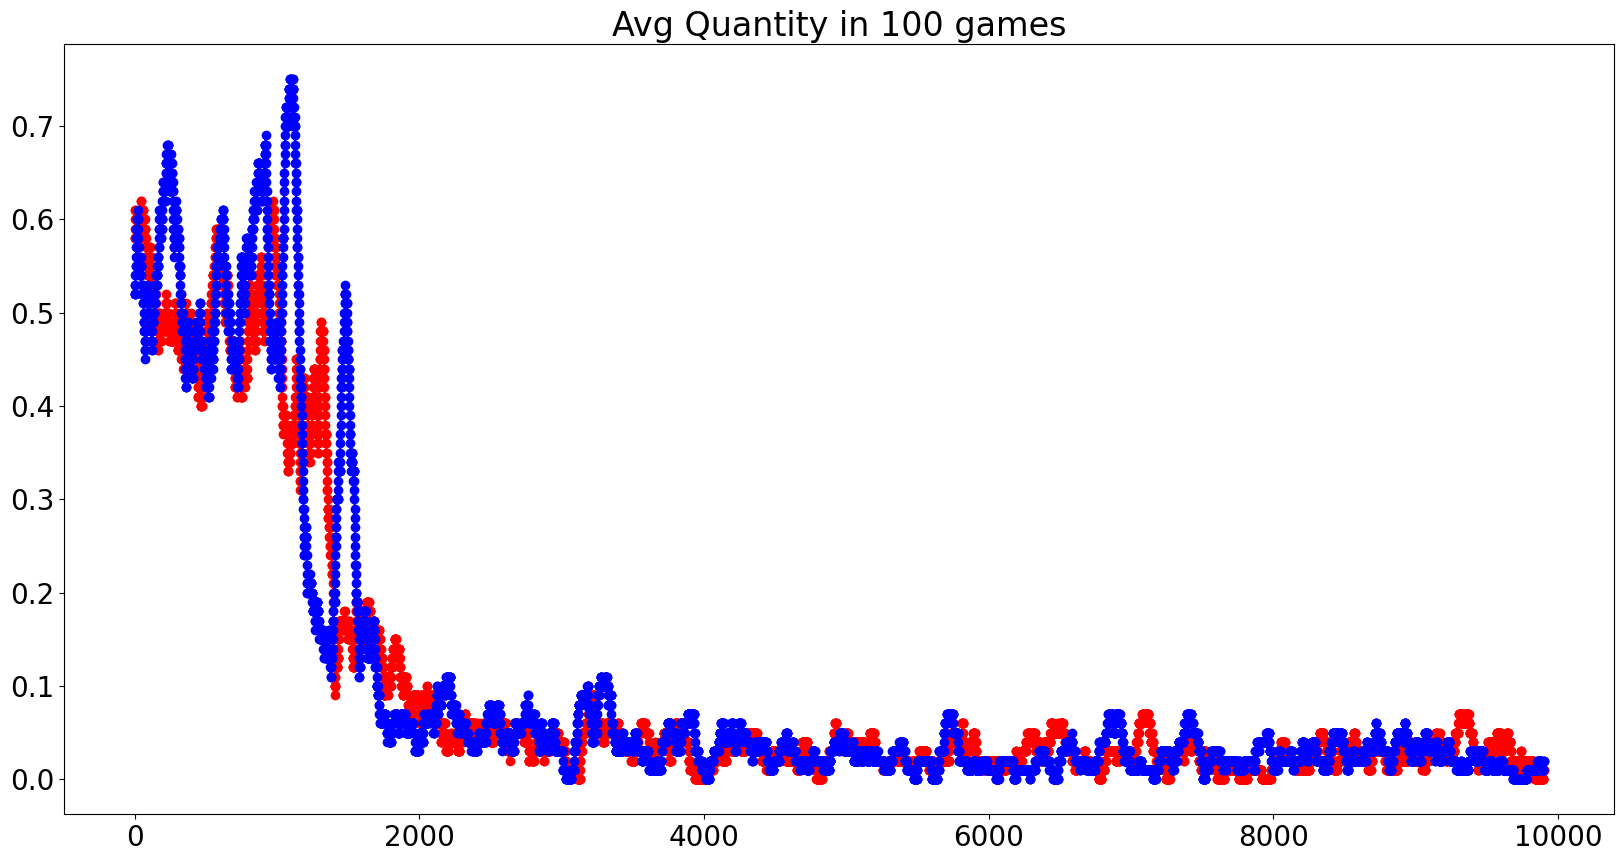

In [435]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(agent1.action_history),100), label = 'Agent 1 Quantity', marker = 'o', c = 'r')
plt.plot(moving_average(np.array(agent2.action_history),100), label = 'Agent 2 Quantity', marker = 'o', c = 'b')
plt.title('Avg Quantity in 100 games') 
plt.show()

### Case 2: 1 RL Agent vs Trainer

In [198]:
def titForTat(agent1):
    past = agent1.action_history
    if len(past) <= 2:
        return torch.tensor([[1]],dtype=torch.long)
    elif past[-1] == 0:
        if past[-2] == 0:
            return torch.tensor([[0]],dtype=torch.long)
        else: 
            return torch.tensor([[1]],dtype=torch.long)
    else:
        return torch.tensor([[1]],dtype=torch.long)

In [224]:
def track(agent, action):
    with torch.no_grad():
        test = torch.tensor([[test]], dtype = torch.float32)
        q = agent1.policy_net
        print(f'Action:{int(action.item()):0.2f}, Loss:{agent.loss.item():0.2f},BETA:{agent.BETA_THRESHOLD:0.2f},EPS:{agent.EPS_THRESHOLD:0.2f}')
        print(f'Q:{q}')

In [225]:
BATCH_SIZE = 1024 # number of transitions sampled from replay buffer
GAMMA = 0.99 # Discount factor
EPS_START = 0.99 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 10000 # controls decay rate of Epsilon
TAU = 0.005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
BETA_START = 10 # temperature of the greedy-exploratory policy
BETA_END = 0.1 # End value of temperature
BETA_DECAY = 10000 # controls decay rate of temperature
N_MEMORY = 10000
N_STATES = 2
N_ACTIONS = 2

agent1 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA, TAU, LR,
                    EPS_START, EPS_END, EPS_DECAY,
                    BETA_START, BETA_END, BETA_DECAY)
agent2 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA, TAU, LR,
                    EPS_START, EPS_END, EPS_DECAY,
                    BETA_START, BETA_END, BETA_DECAY)

In [226]:
agent1.action_history.append(1)
agent1.action_history.append(1)

past = []
epochs = 10000
for t in range(epochs):
    print('\n Iteration:',t)

    # Take action
    a1 = select_action(agent1)
    #a2 = select_action(agent2)
    a2 = titForTat(agent1)
    #q2 = torch.tensor(np.maximum(q1,0), dtype = torch.float32)
    #q2 = torch.tensor(q2c, dtype = torch.float32)
    #a2 = torch.tensor(np.where(Qgrid==find_nearest(Qgrid,q2.item()))[0])

    # Obtain Reward
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])
    #r2 = torch.tensor([r2])
    
    # Compute next state
    next_state1 = agent1.state 
    next_state1[0][-1] = a2.item()
    next_state1[0][-2] = agent1.action_history[-1]

    #next_state2 = agent2.state 
    #next_state2[0] = a1.item()  
    
    # store memory in transition
    agent1.memory.push(agent1.state, next_state1, a1, r1)
    #agent2.memory.push(agent2.state, next_state2, a2, r2)

    # move to next state
    agent1.state = next_state1
    #agent2.state = next_state2
    
    # optimize
    optimize_model(agent1)
    #optimize_model(agent2)

    # soft update target_net
    update_target_net(agent1)
    #update_target_net(agent2)
    
    # record actions
    agent1.action_history.append(a1.item())
    #agent2.action_history.append(a2.item())
    
    # print loss
    track(agent1, [0,0], a1)
    print(a1.item(), a2.item())
    #track(agent2, 0, a2)


 Iteration: 0


TypeError: track() takes 2 positional arguments but 3 were given

In [218]:
# When opponent played q2=0
test = torch.tensor([[1]], dtype = torch.float32)
agent1.policy_net(test), agent1.target_net(test)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 2x128)

/var/folders/xt/r947d5fd2yz1_fkptq29sn8r0000gn/T/ipykernel_2807/703945731.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.plot(moving_average(np.array(agent1.action_history),100), label = 'Agent 1 Quantity', marker = 'o', c = 'r')
/var/folders/xt/r947d5fd2yz1_fkptq29sn8r0000gn/T/ipykernel_2807/703945731.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt

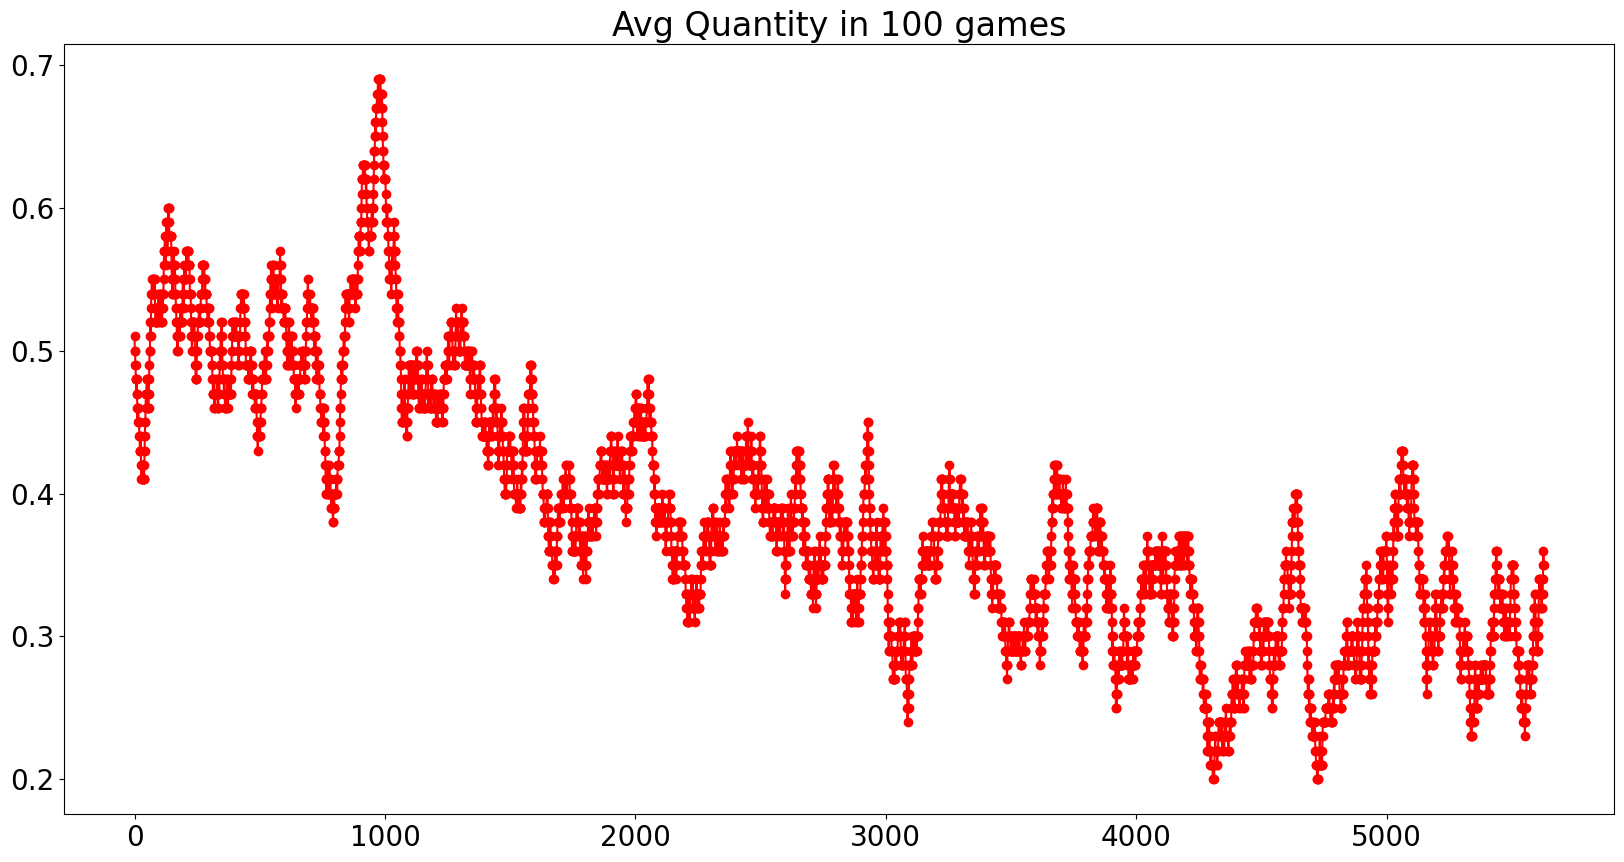

In [219]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(agent1.action_history),100), label = 'Agent 1 Quantity', marker = 'o', c = 'r')
plt.title('Avg Quantity in 100 games') 
plt.show()

### Case 3: 1 RL Agent (trained on copycat) vs itself

In [220]:
agent1.action_history

[tensor([[1]]),
 tensor([[1]]),
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
